In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

# Function to calculate brightness of an image
def calculate_brightness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

# Function to calculate image quality
def calculate_image_quality(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    return laplacian.var()

# Function to find the brightest image in a dataset
def find_max_brightness_and_quality(data_path):
    max_brightness = 0
    max_quality = 0
    
    for filename in os.listdir(data_path):
        img_path = os.path.join(data_path, filename)
        image = cv2.imread(img_path)
        
        brightness = calculate_brightness(image)
        quality = calculate_image_quality(image)
        
        max_brightness = max(max_brightness, brightness)
        max_quality = max(max_quality, quality)
            
    return max_brightness, max_quality

# Step 1: Calculate maximum brightness and quality values
data_path_closed_eye = r'C:\Users\yashu\smart_driver_guard\app\data\training\closed_eye'
data_path_yawn = r'C:\Users\yashu\smart_driver_guard\app\data\training\yawn'

max_brightness_closed_eye, max_quality_closed_eye = find_max_brightness_and_quality(data_path_closed_eye)
max_brightness_yawn, max_quality_yawn = find_max_brightness_and_quality(data_path_yawn)

print("Max Brightness (Closed Eye):", max_brightness_closed_eye)
print("Max Quality (Closed Eye):", max_quality_closed_eye)
print("Max Brightness (Yawn):", max_brightness_yawn)
print("Max Quality (Yawn):", max_quality_yawn)


Max Brightness (Closed Eye): 215.4031551582404
Max Quality (Closed Eye): 2363.0645045100396
Max Brightness (Yawn): 187.3345864661654
Max Quality (Yawn): 1356.0829749154743


In [3]:
# Step 2: Dataset Preparation
def load_and_preprocess_data(data_path, label):
    images = []
    labels = []

    for filename in os.listdir(data_path):
        img_path = os.path.join(data_path, filename)
        image = cv2.imread(img_path)
        
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(label)

    return images, labels

images_closed_eye, labels_closed_eye = load_and_preprocess_data(data_path_closed_eye, label=0)
images_yawn, labels_yawn = load_and_preprocess_data(data_path_yawn, label=1)

# Combine the datasets
all_images = images_closed_eye + images_yawn
all_labels = labels_closed_eye + labels_yawn

# Convert to NumPy arrays
X = np.array(all_images)
y = np.array(all_labels)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Model Architecture
def create_classification_model(input_shape, num_classes):
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create the model
input_shape_classification = (224, 224, 3)
num_classes_classification = 2  # Closed eye and yawn
model_classification = create_classification_model(input_shape_classification, num_classes_classification)

# Step 4: Model Training
model_classification.compile(optimizer=Adam(learning_rate=0.001),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

# Callbacks
checkpoint_classification = ModelCheckpoint('model_classification.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Training
model_classification.fit(X_train, y_train,
                          epochs=10,
                          validation_data=(X_val, y_val),
                          callbacks=[checkpoint_classification])

# Step 5: Convert the model to TensorFlow Lite format with optimization
converter = tf.lite.TFLiteConverter.from_keras_model(model_classification)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_classification = converter.convert()

# Save the TensorFlow Lite model
with open('model_classification.tflite', 'wb') as f:
    f.write(tflite_model_classification)

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9563
Epoch 1: val_accuracy improved from -inf to 0.99063, saving model to model_classification.h5


C:\Users\yashu\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 83s 2s/step - loss: 0.1109 - accuracy: 0.9563 - val_loss: 0.0172 - val_accuracy: 0.9906
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9922
Epoch 2: val_accuracy improved from 0.99063 to 0.99687, saving model to model_classification.h5
40/40 [==============================] - 66s 2s/step - loss: 0.0224 - accuracy: 0.9922 - val_loss: 0.0118 - val_accuracy: 0.9969
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9977
Epoch 3: val_accuracy did not improve from 0.99687
40/40 [==============================] - 67s 2s/step - loss: 0.0115 - accuracy: 0.9977 - val_loss: 0.0075 - val_accuracy: 0.9969
Epoch 4/10
40/40 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9937
Epoch 4: val_accuracy did not improve from 0.99687
40/40 [==============================] - 67s 2s/step - loss: 0.0176 - accuracy: 0.9937 - val_loss: 0.0244 - val_accuracy: 0.9906
Epoc

INFO:tensorflow:Assets written to: C:\Users\yashu\AppData\Local\Temp\tmp6hkljpkw\assets


In [15]:
#2
model_classification.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 4213797 (16.07 MB)
Trainable params: 16422

In [5]:
from sklearn.metrics import classification_report
y_pred = model_classification.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

3# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes))





10/10 [==============================] - 16s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       171
           1       0.99      1.00      1.00       149

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320



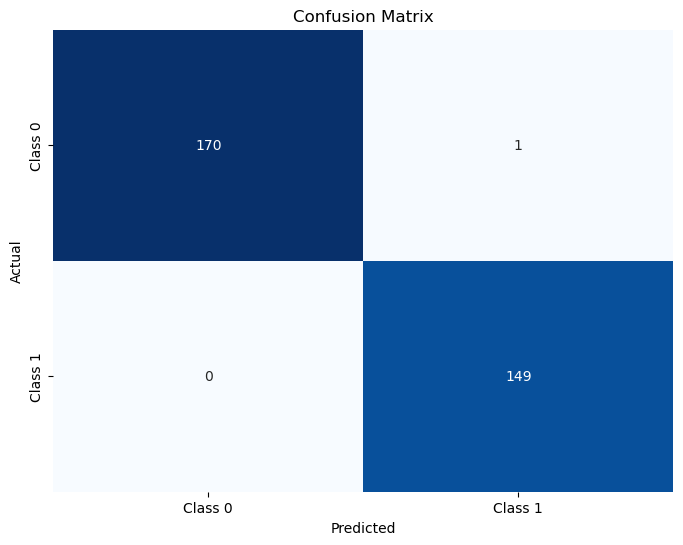

In [8]:
4# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

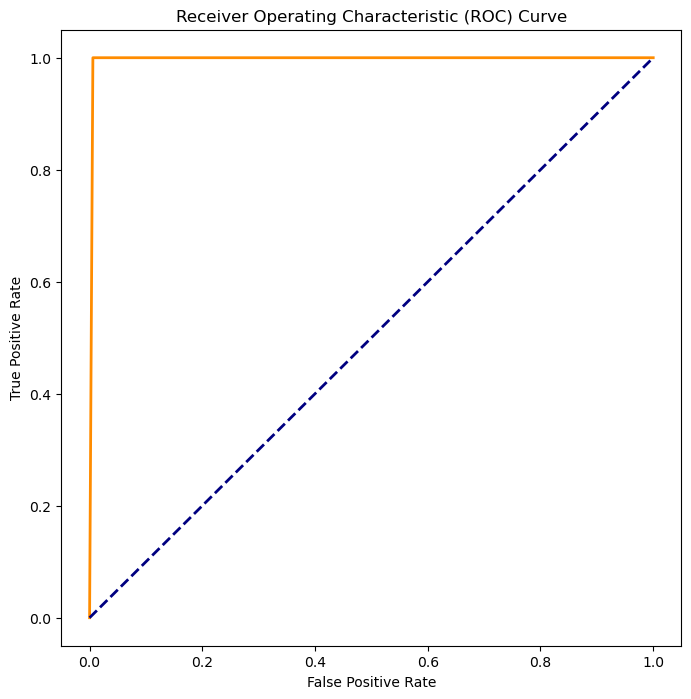

In [11]:
# Visualizations

# 5. Receiver Operating Characteristic (ROC) Curve
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_val, y_pred_classes)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

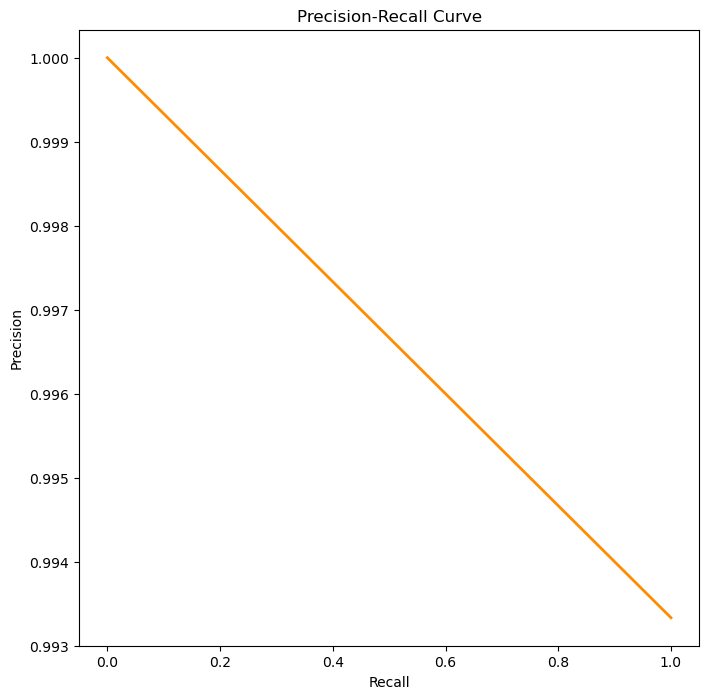

In [13]:
# 6. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_val, y_pred_classes)
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


1/1 [==============================] - 3s 3s/step


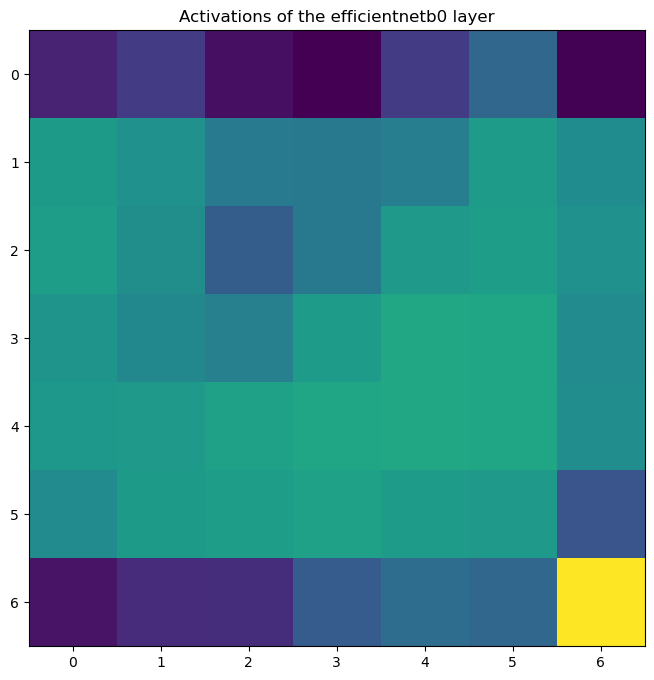

In [17]:
# 7. Visualizing Filters or Activations of Convolutional Layers
layer_name = 'efficientnetb0'
layer = model_classification.get_layer(name=layer_name)

# Create a model without the Rescaling layer
activations_model = models.Model(inputs=layer.input, outputs=layer.output)
activations = activations_model.predict(X_val[:1])    # Considering the first sample for visualization
plt.figure(figsize=(8, 8))
plt.imshow(activations[0, :, :, 0], cmap='viridis')  # Visualizing the activations of the first filter
plt.title(f'Activations of the {layer_name} layer')
plt.show()


1/1 [==============================] - 3s 3s/step


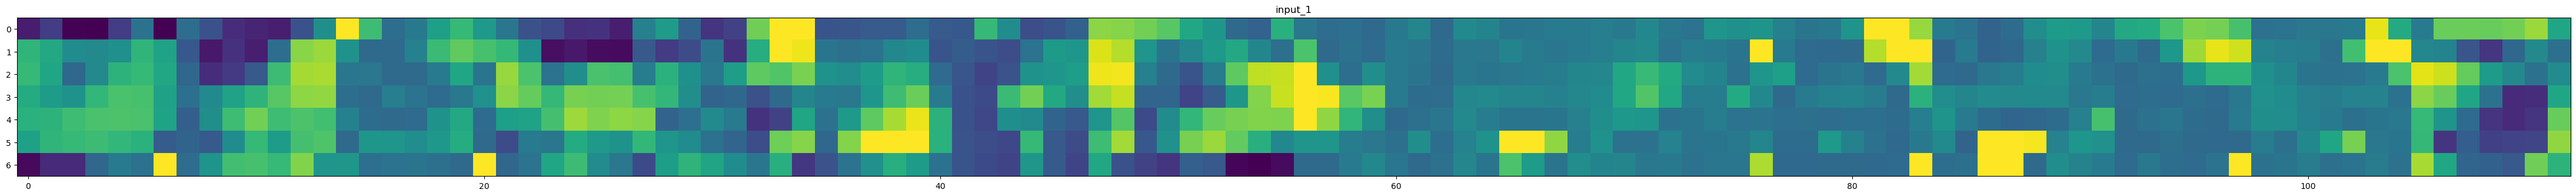

1/1 [==============================] - 0s 119ms/step


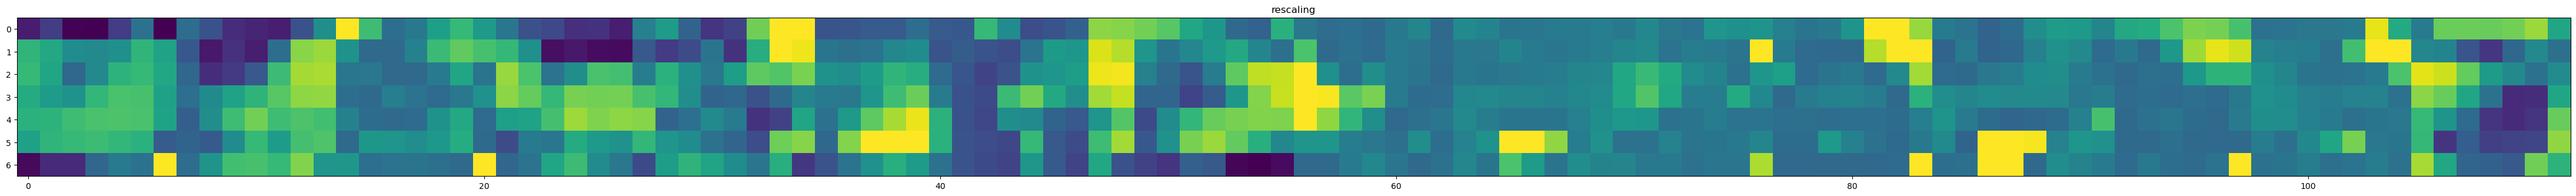

1/1 [==============================] - 0s 119ms/step


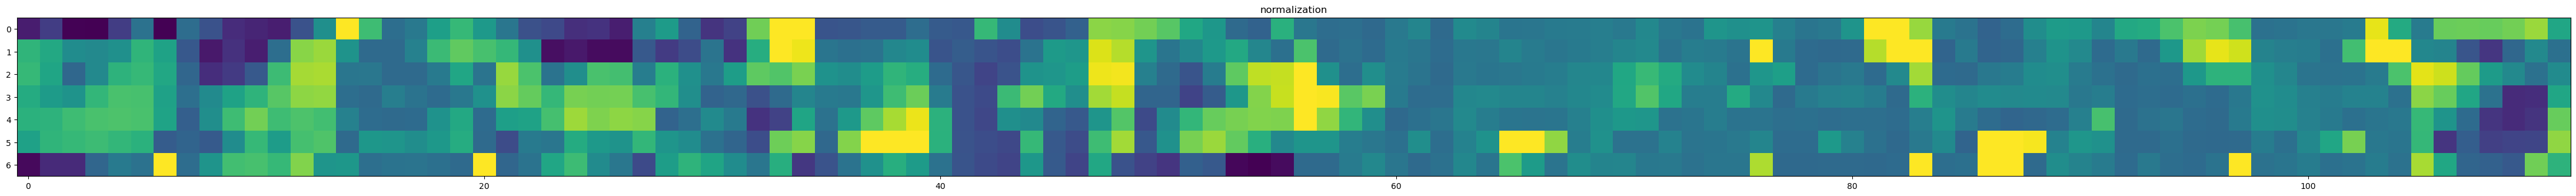

1/1 [==============================] - 0s 119ms/step


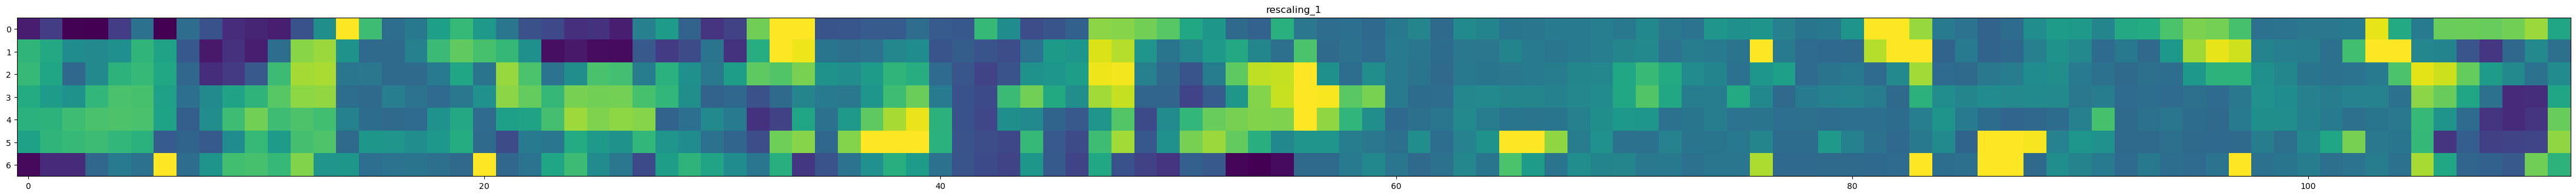

1/1 [==============================] - 0s 133ms/step


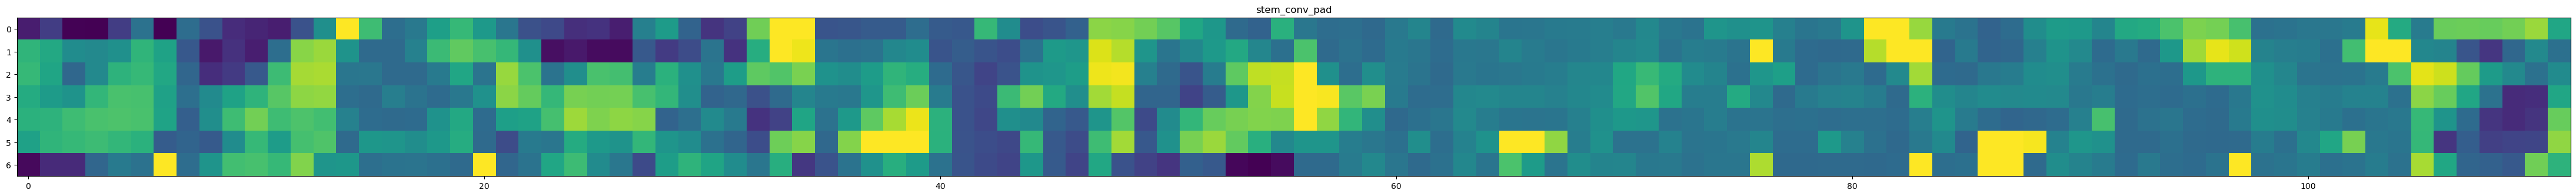

1/1 [==============================] - 0s 123ms/step


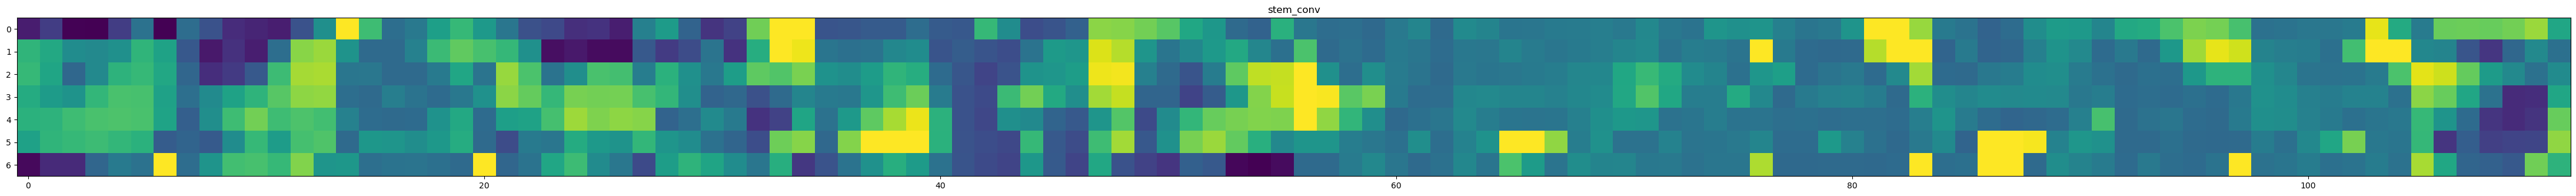

1/1 [==============================] - 0s 126ms/step


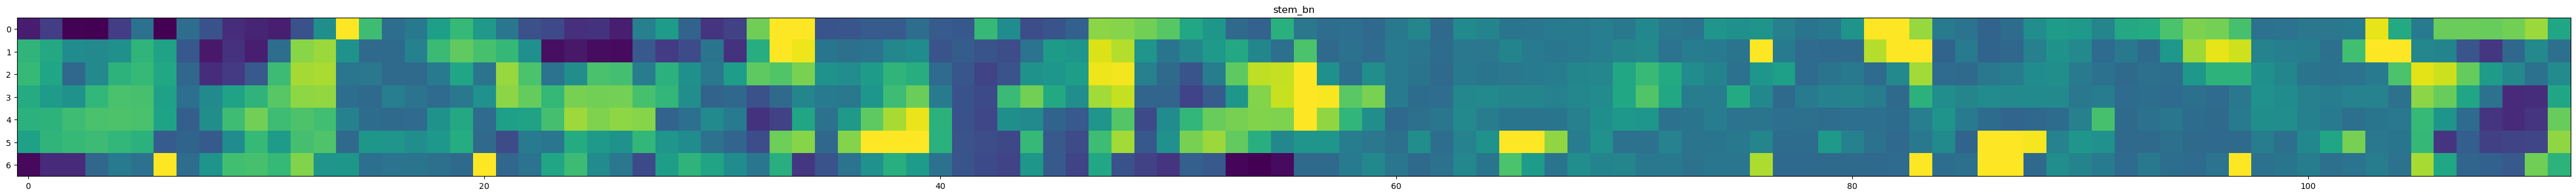

1/1 [==============================] - 0s 125ms/step


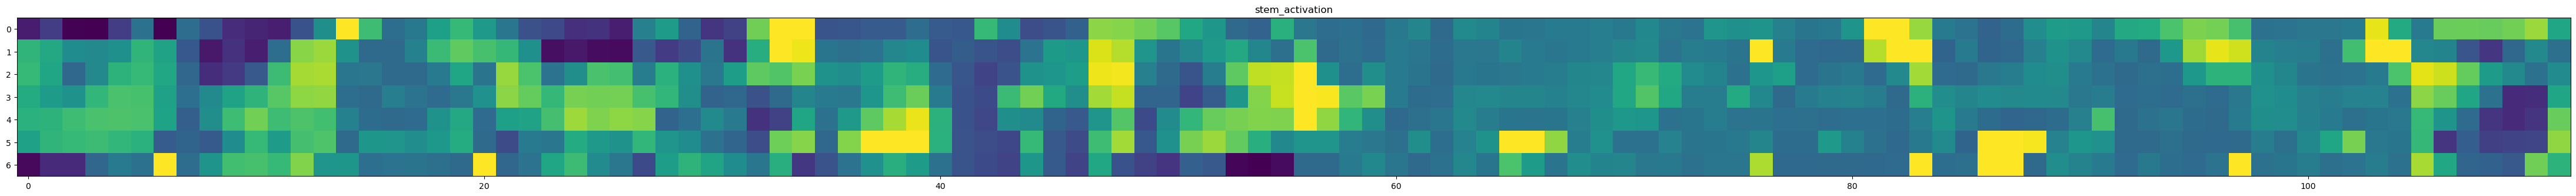

1/1 [==============================] - 0s 135ms/step


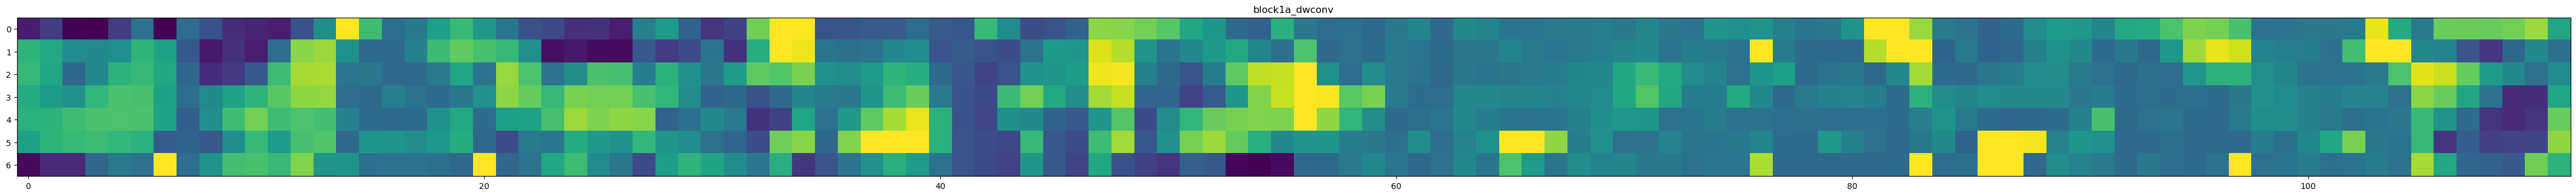

1/1 [==============================] - 0s 126ms/step


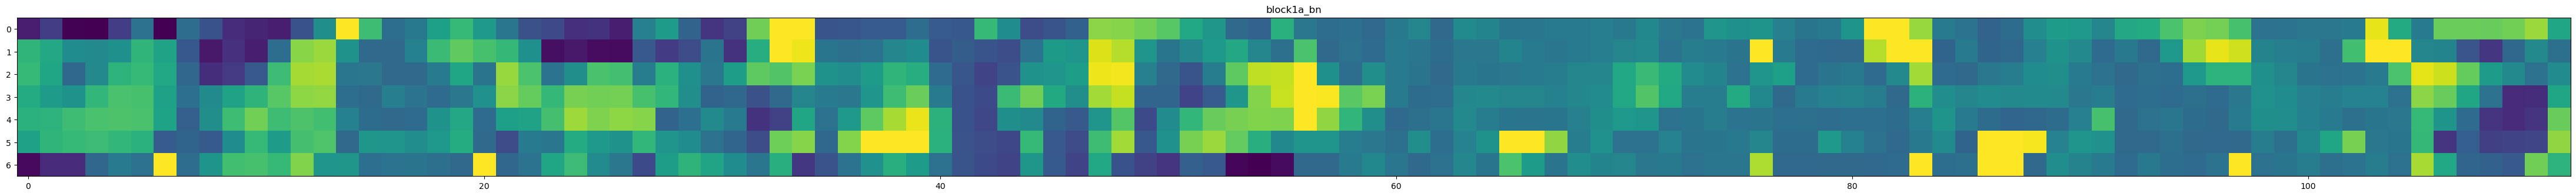

1/1 [==============================] - 0s 118ms/step


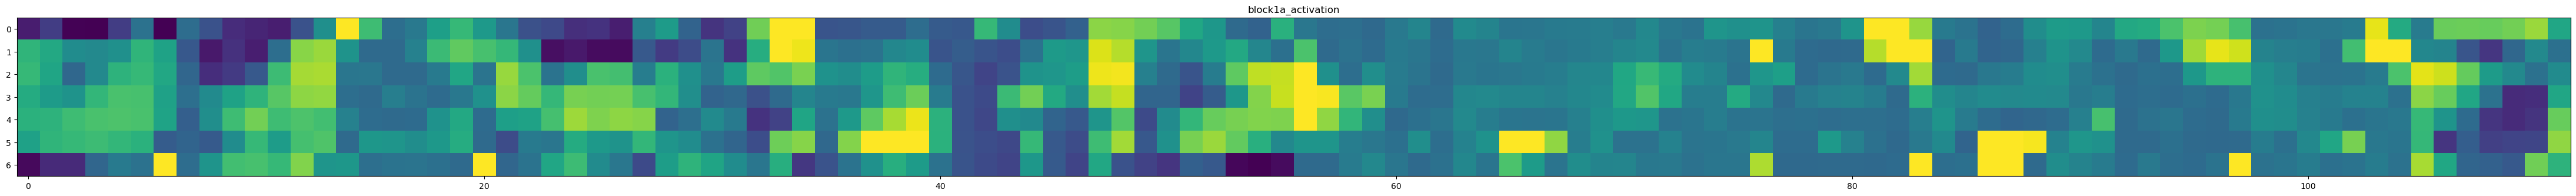

1/1 [==============================] - 0s 127ms/step


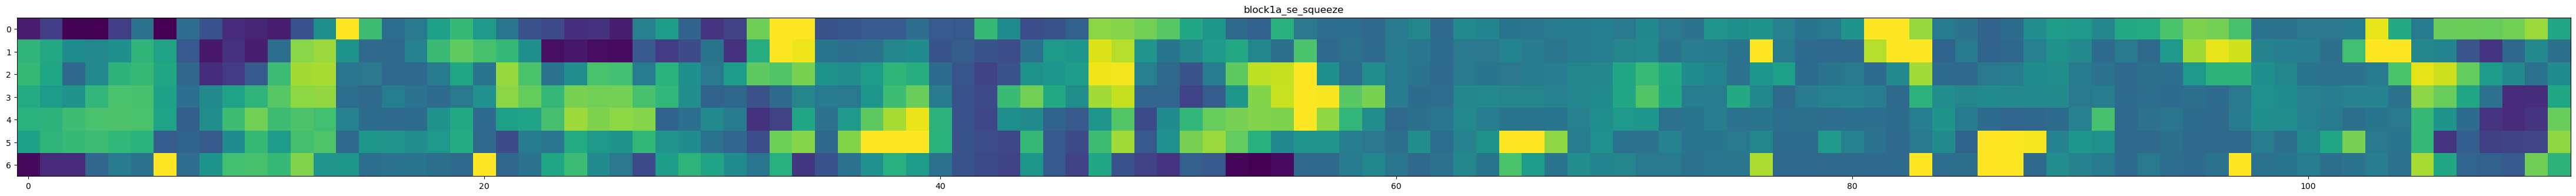

1/1 [==============================] - 0s 121ms/step


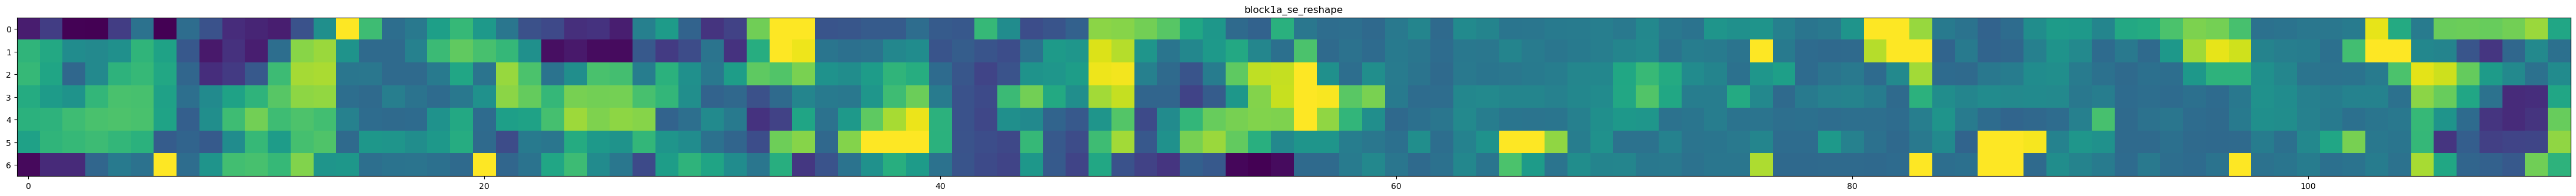

1/1 [==============================] - 0s 128ms/step


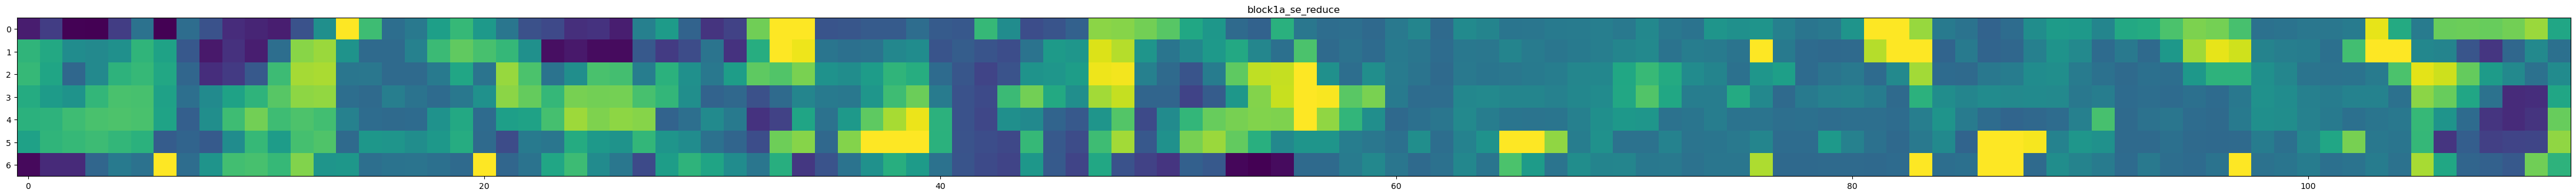

1/1 [==============================] - 0s 182ms/step


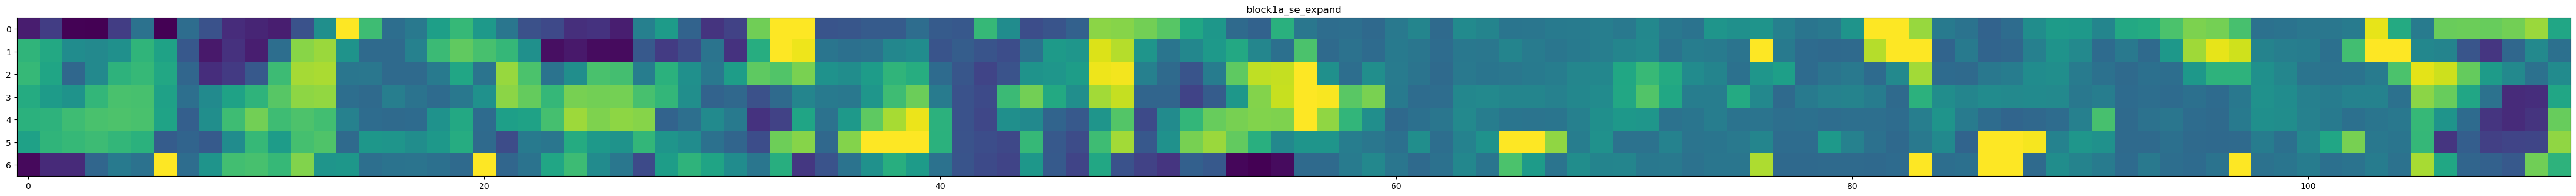

1/1 [==============================] - 0s 126ms/step


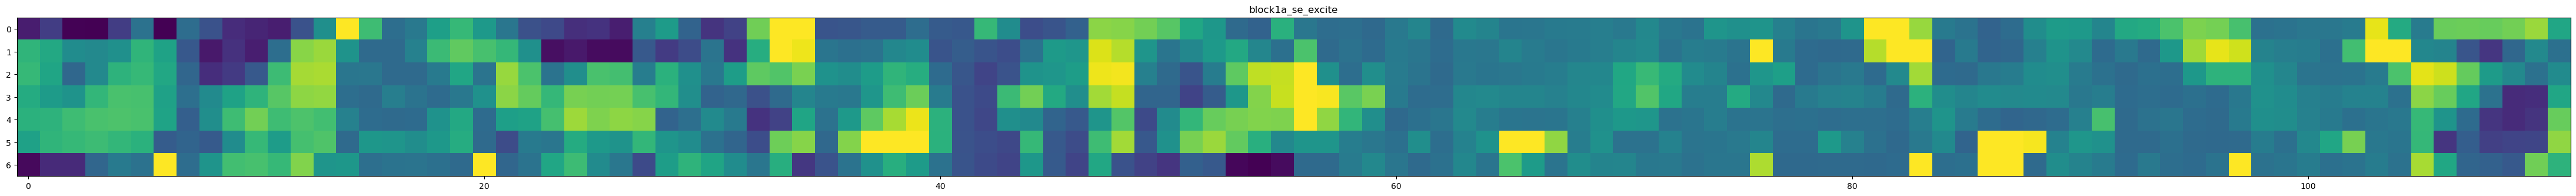

1/1 [==============================] - 0s 127ms/step


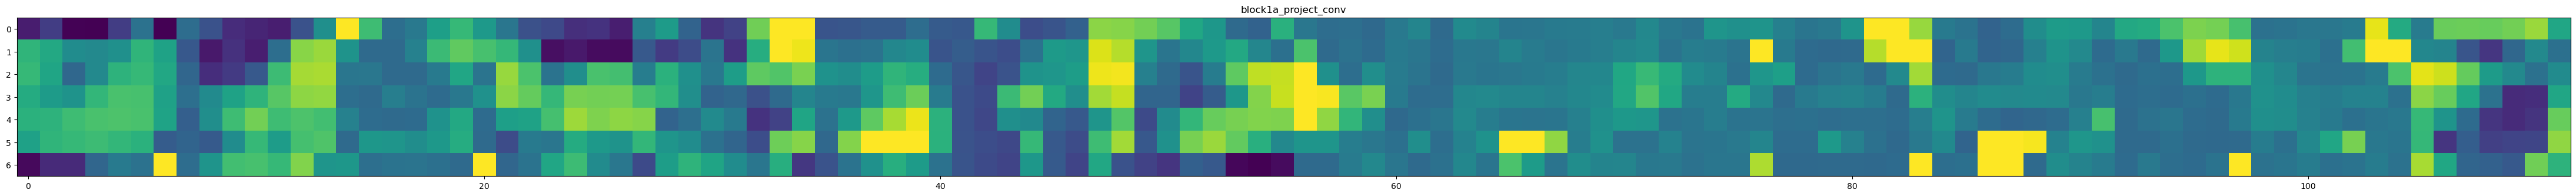

1/1 [==============================] - 0s 118ms/step


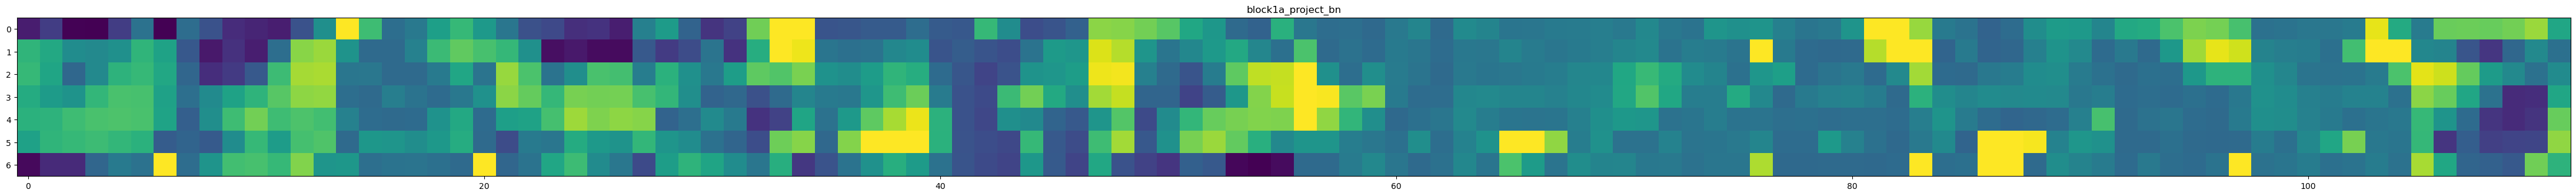

1/1 [==============================] - 0s 117ms/step


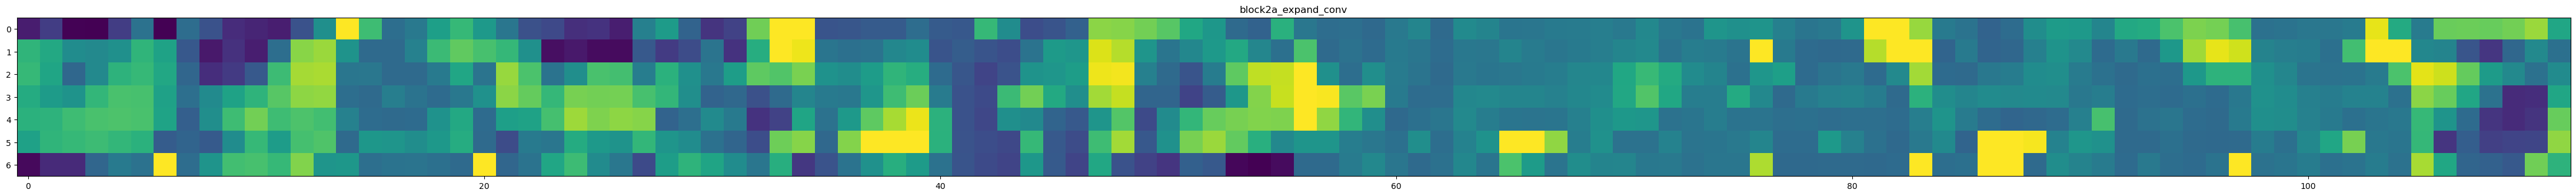

1/1 [==============================] - 0s 117ms/step


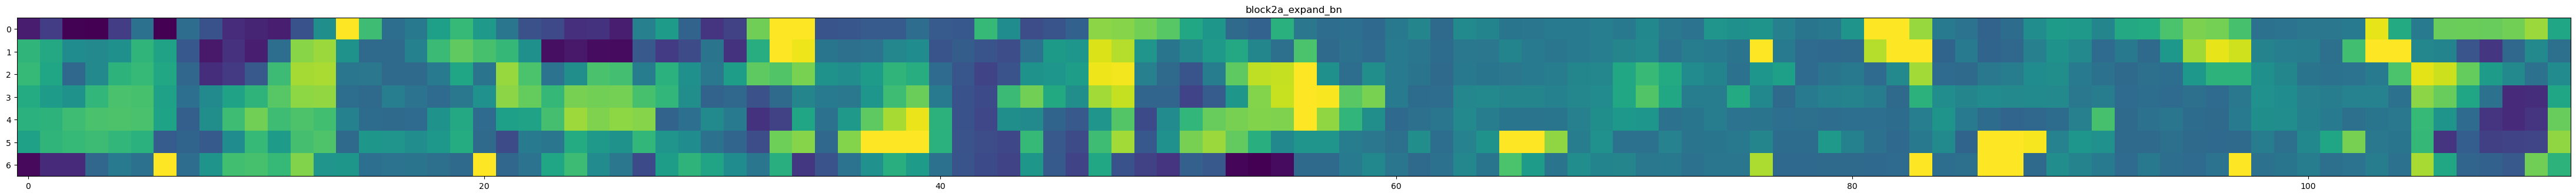

1/1 [==============================] - 0s 135ms/step


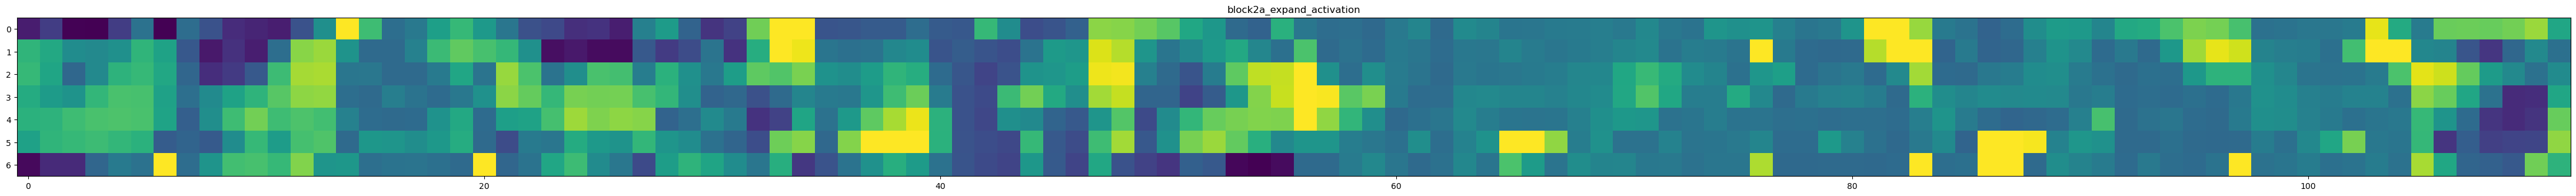

1/1 [==============================] - 0s 106ms/step


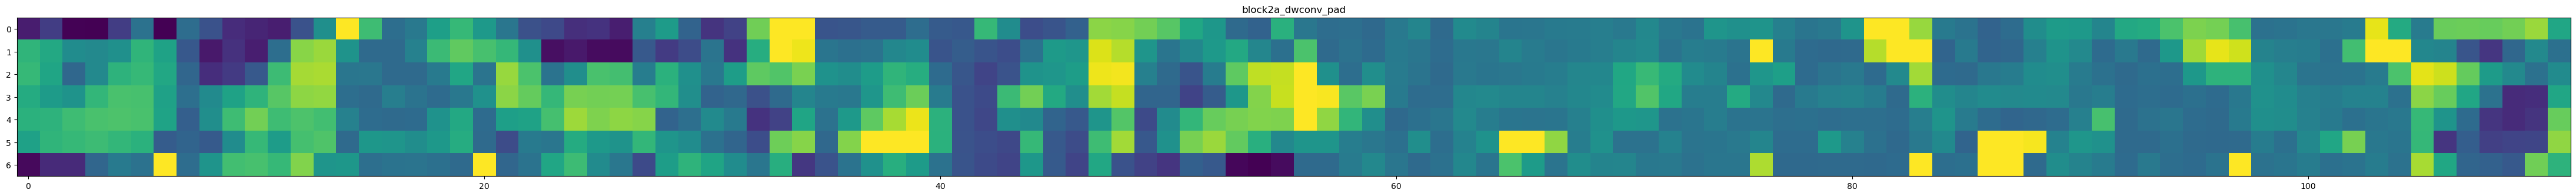

1/1 [==============================] - 0s 114ms/step


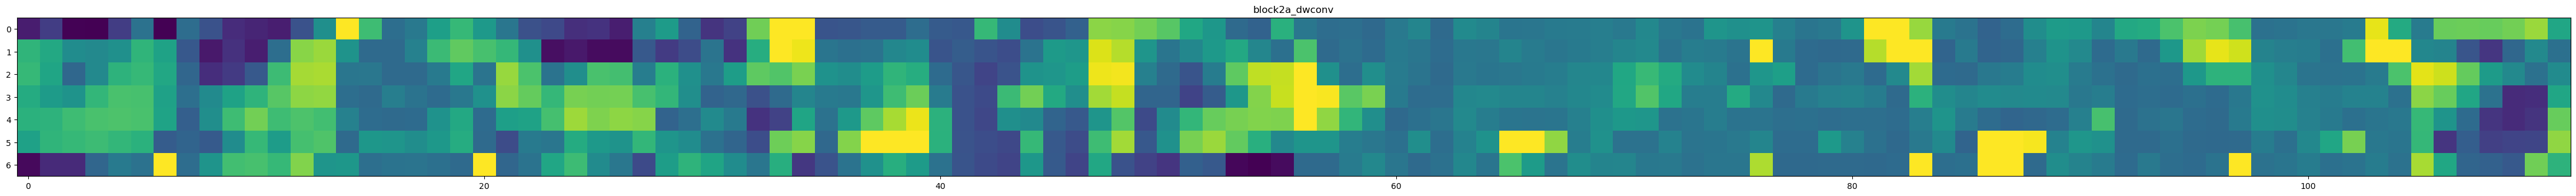

1/1 [==============================] - 0s 110ms/step


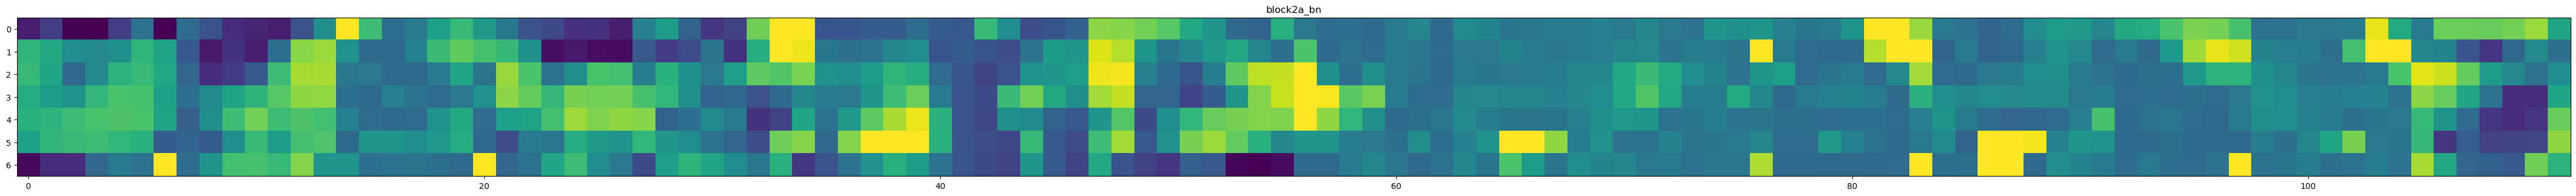

1/1 [==============================] - 0s 129ms/step


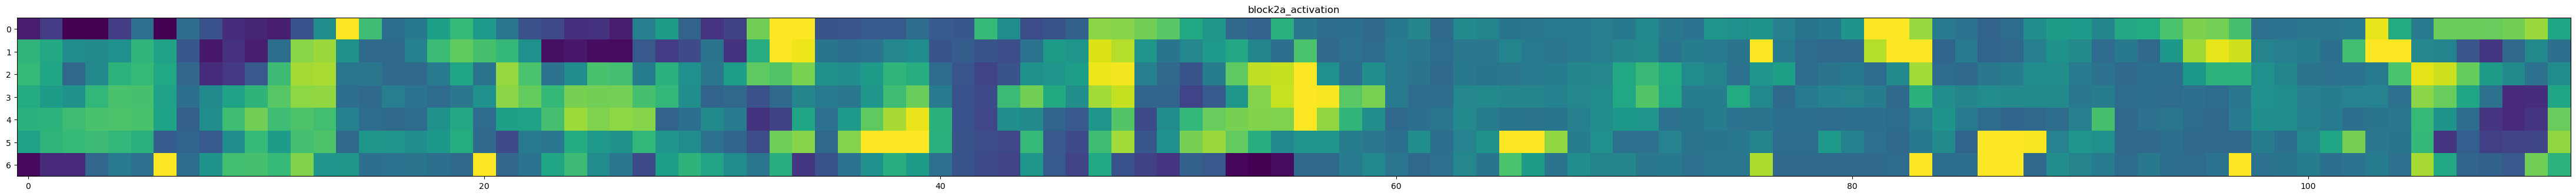

1/1 [==============================] - 0s 126ms/step


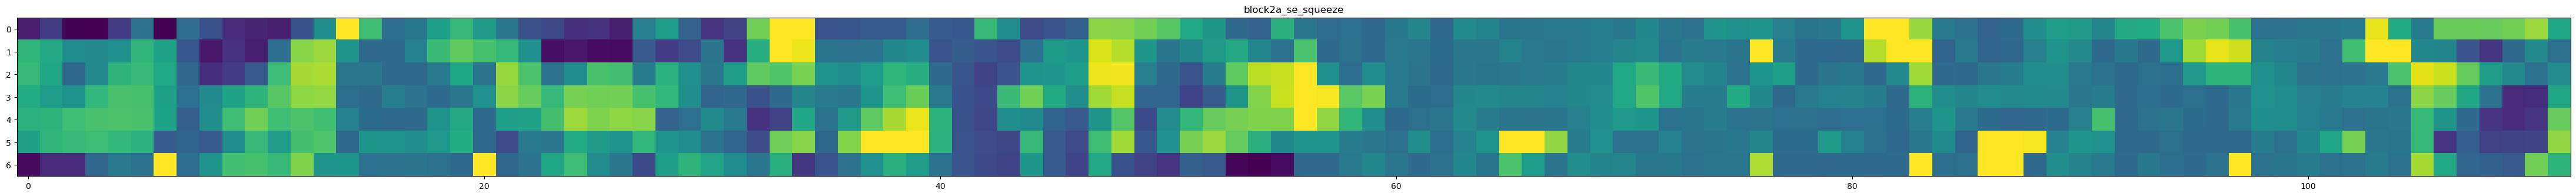

1/1 [==============================] - 0s 120ms/step


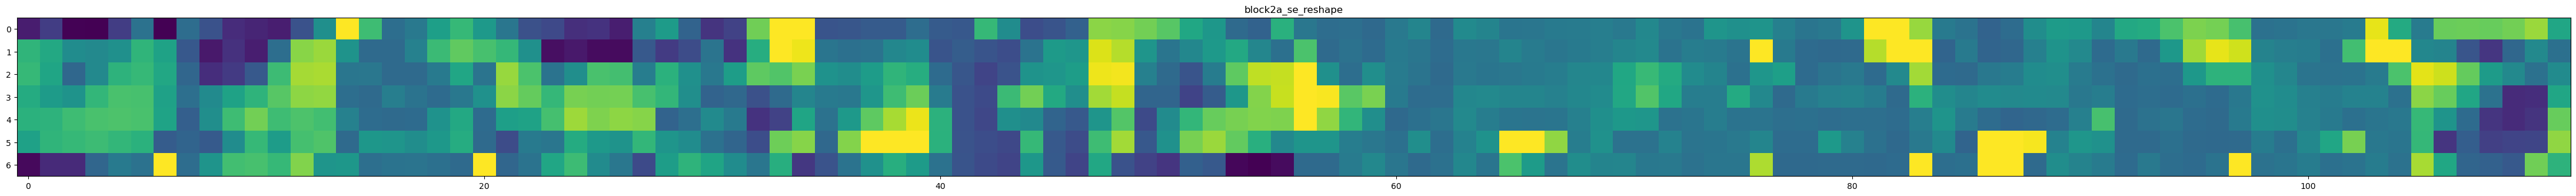

1/1 [==============================] - 0s 127ms/step


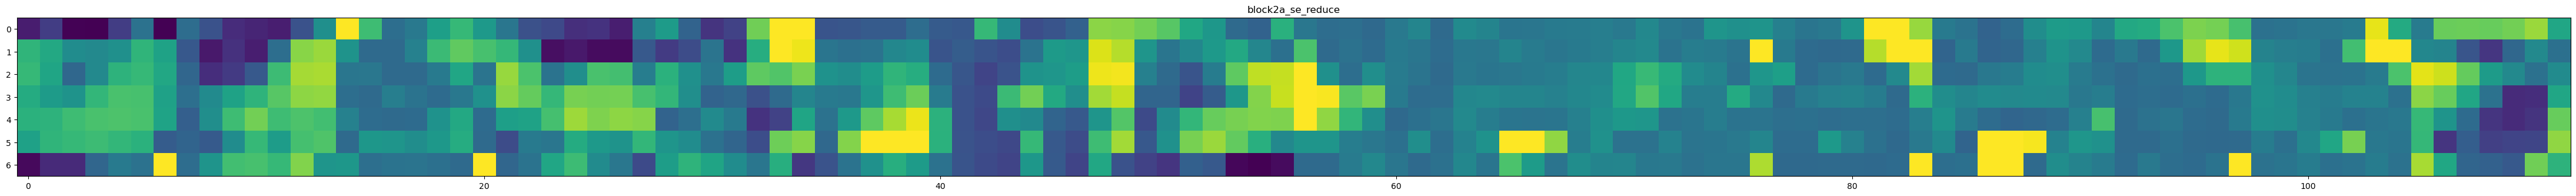

1/1 [==============================] - 0s 127ms/step


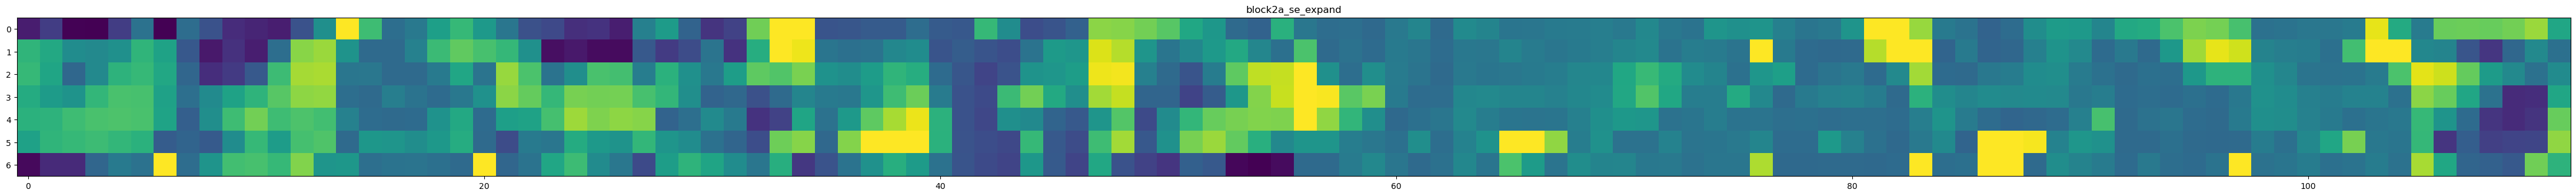

1/1 [==============================] - 0s 128ms/step


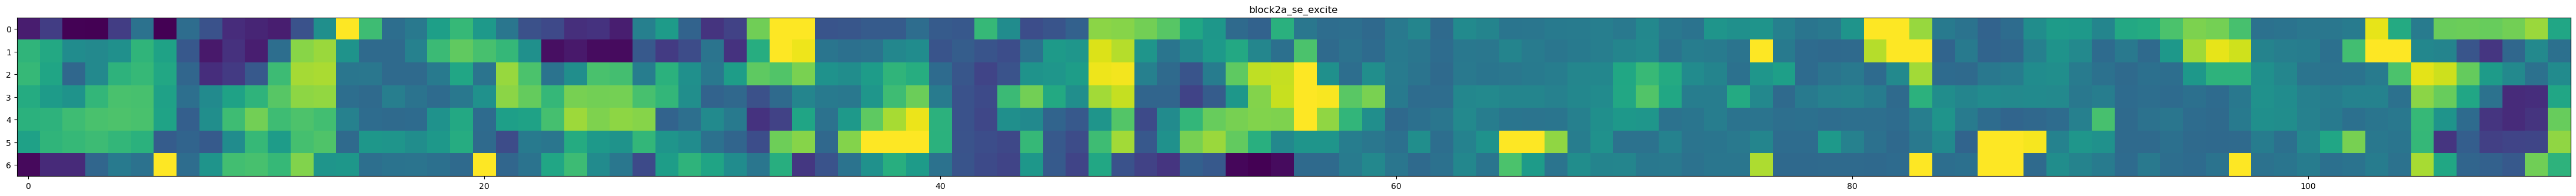

1/1 [==============================] - 0s 123ms/step


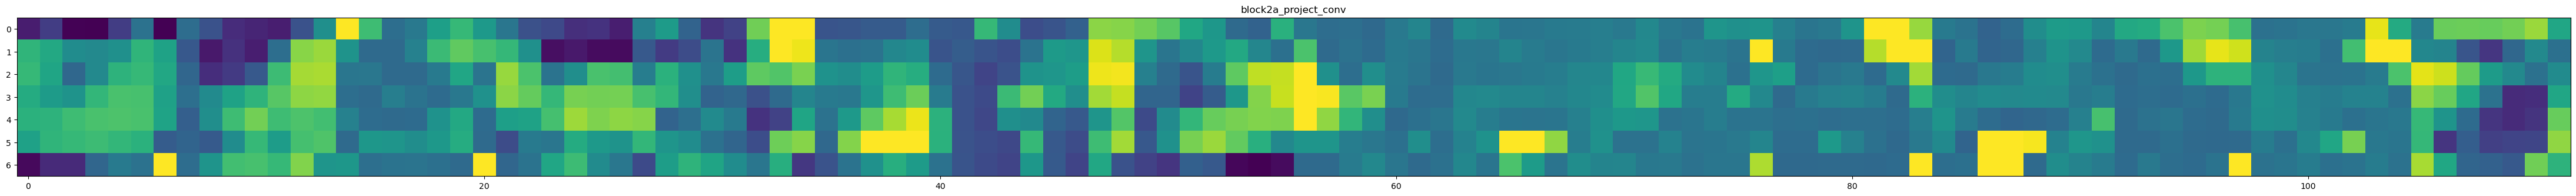

1/1 [==============================] - 0s 120ms/step


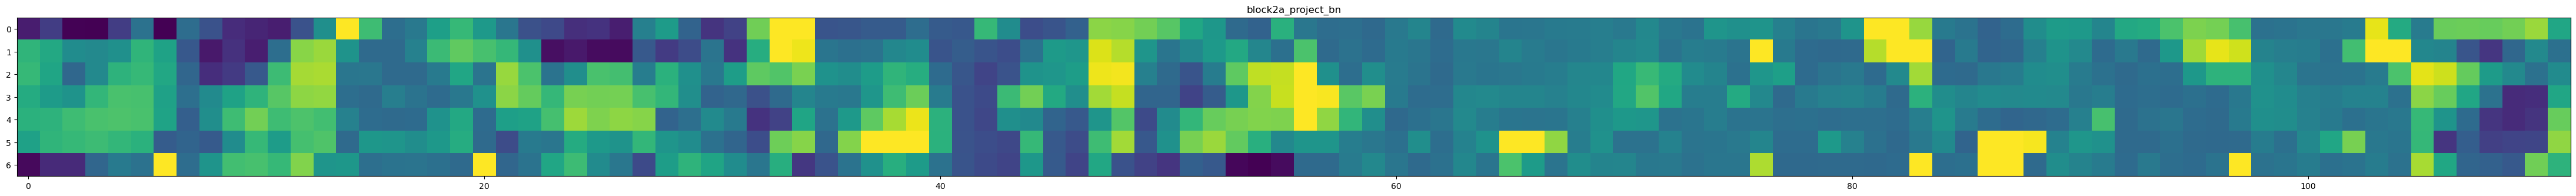

1/1 [==============================] - 0s 121ms/step


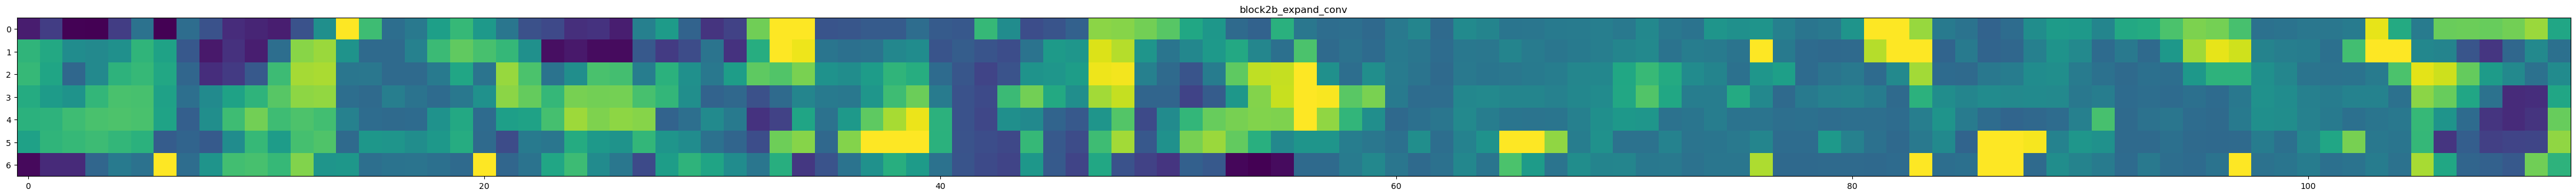

1/1 [==============================] - 0s 125ms/step


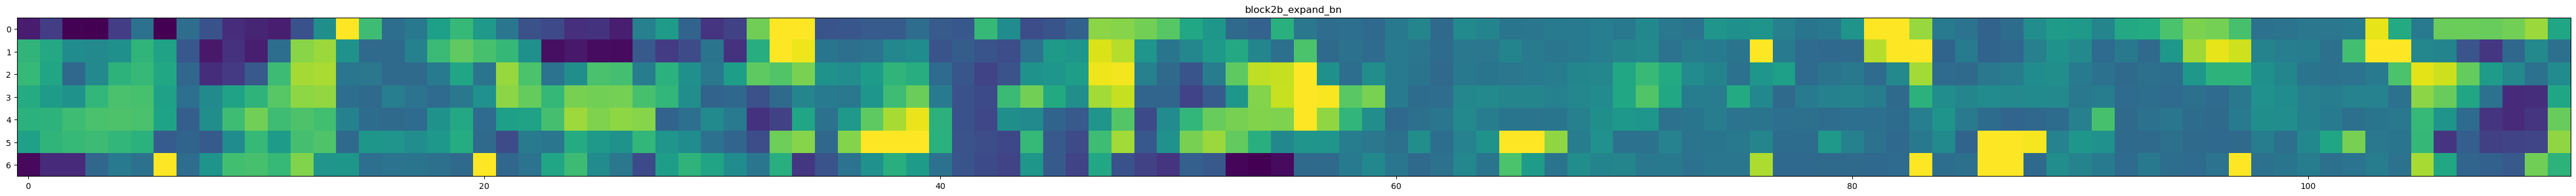

1/1 [==============================] - 0s 118ms/step


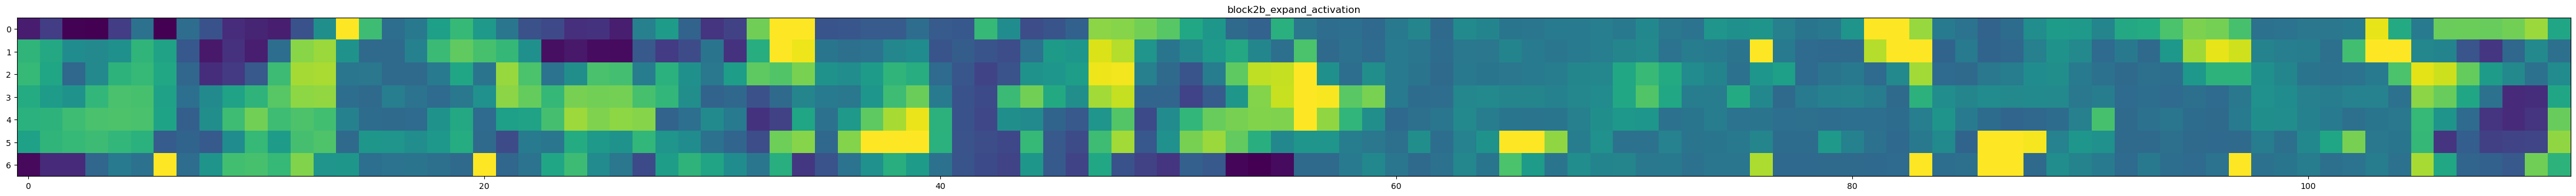

1/1 [==============================] - 0s 100ms/step


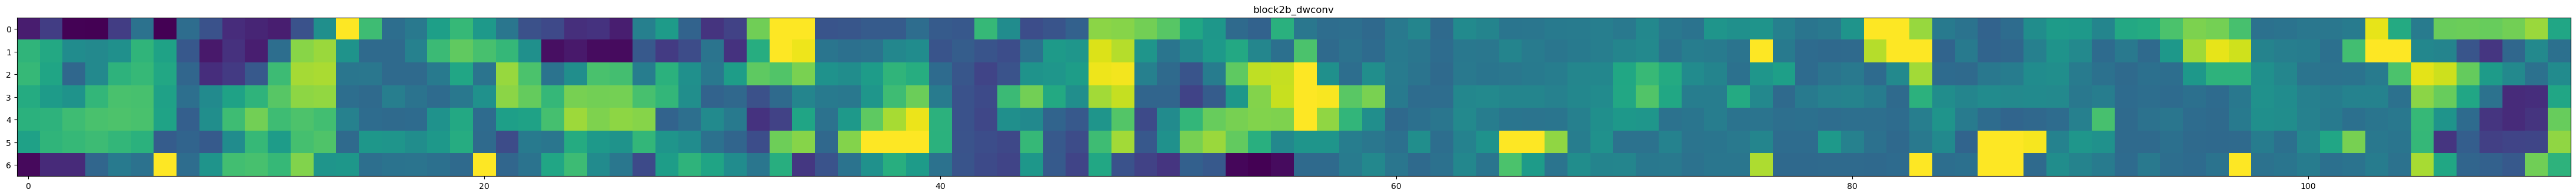

1/1 [==============================] - 0s 129ms/step


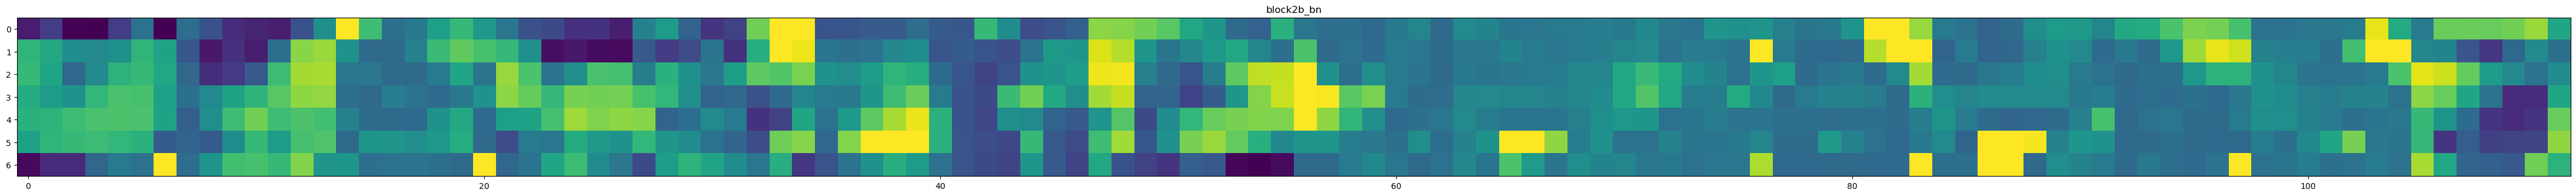

1/1 [==============================] - 0s 118ms/step


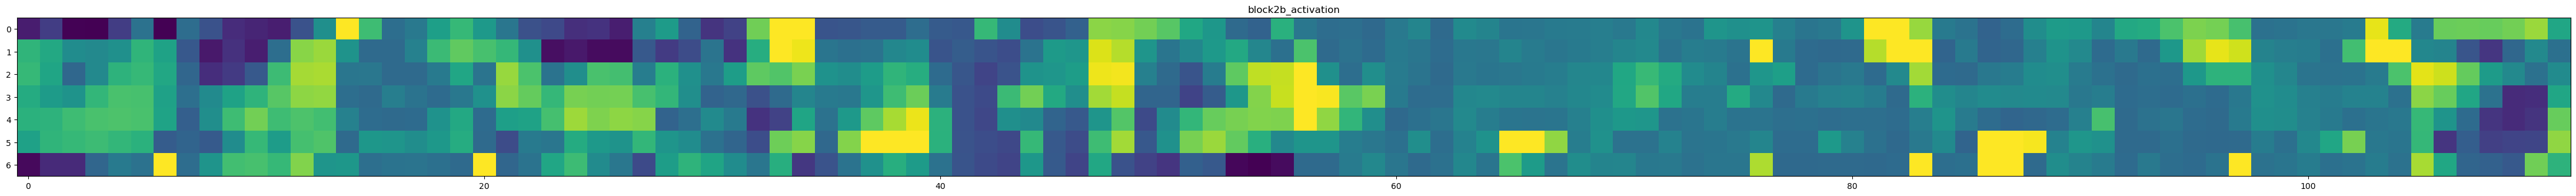

1/1 [==============================] - 0s 116ms/step


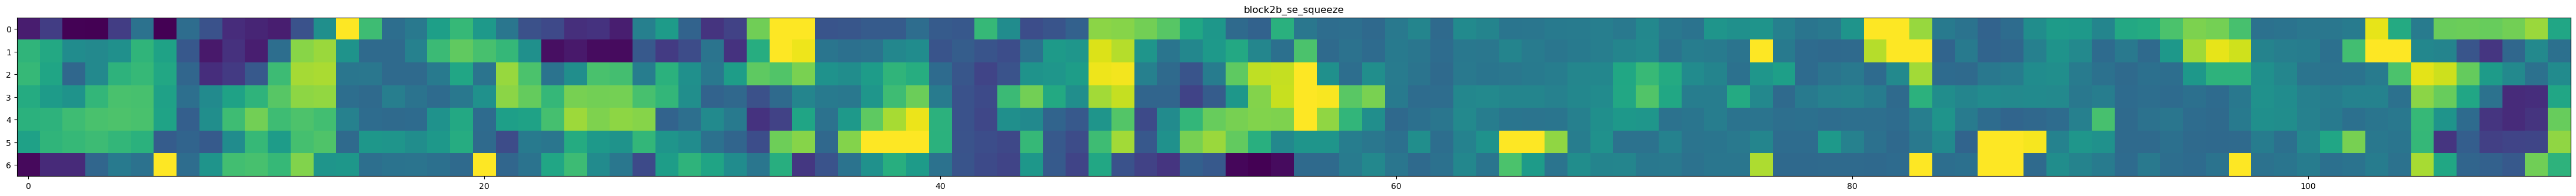

1/1 [==============================] - 0s 117ms/step


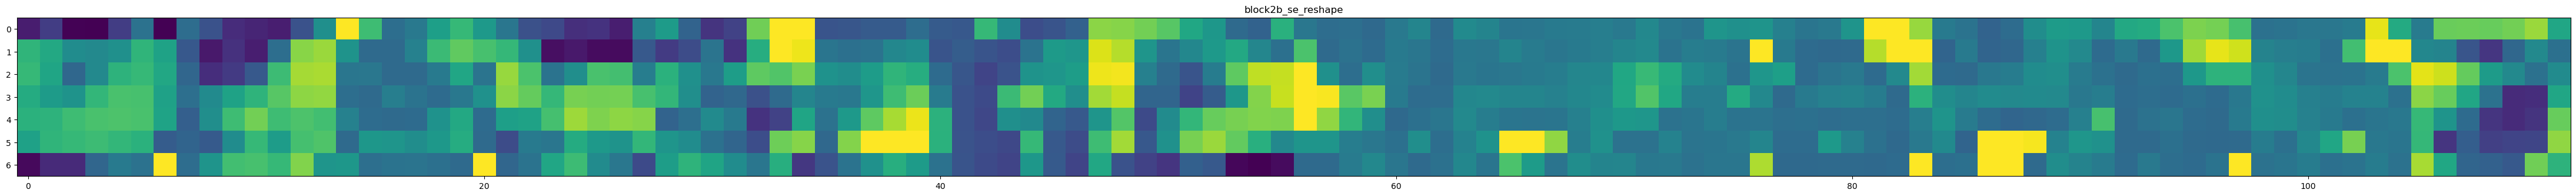

1/1 [==============================] - 0s 110ms/step


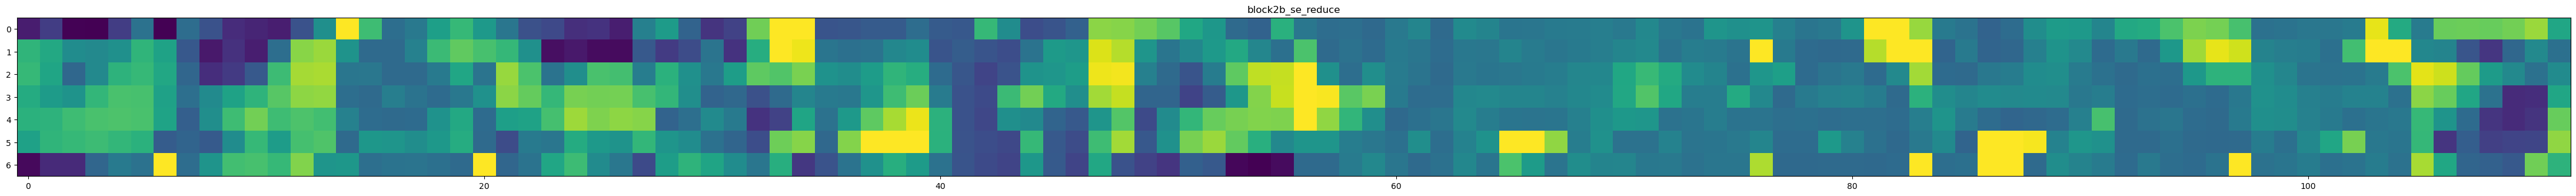

1/1 [==============================] - 0s 125ms/step


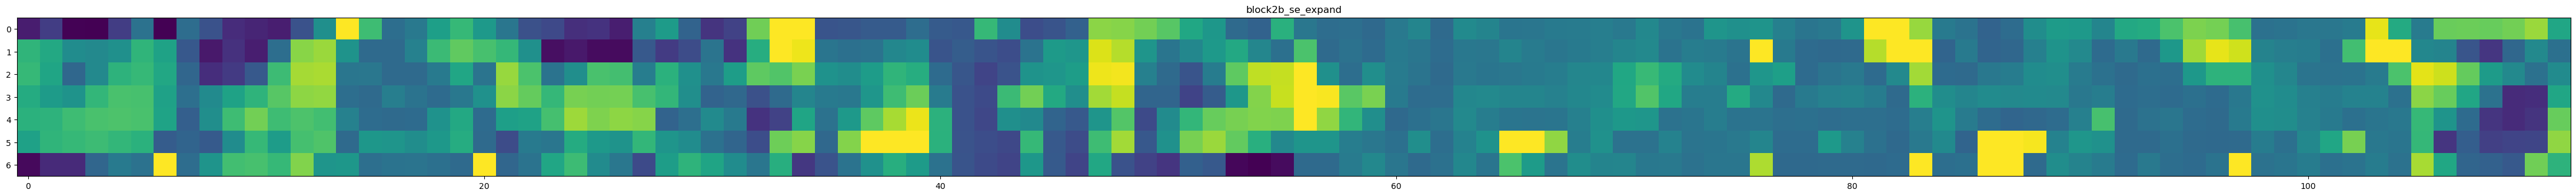

1/1 [==============================] - 0s 125ms/step


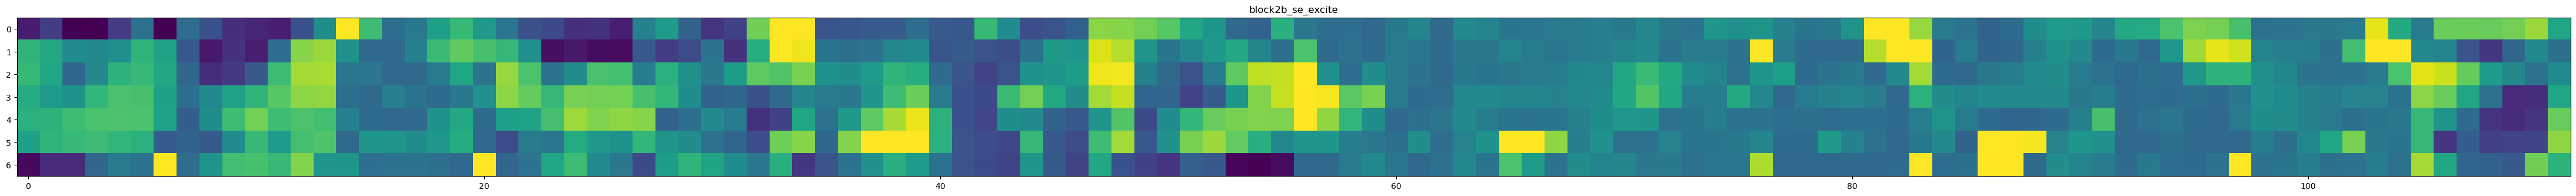

1/1 [==============================] - 0s 125ms/step


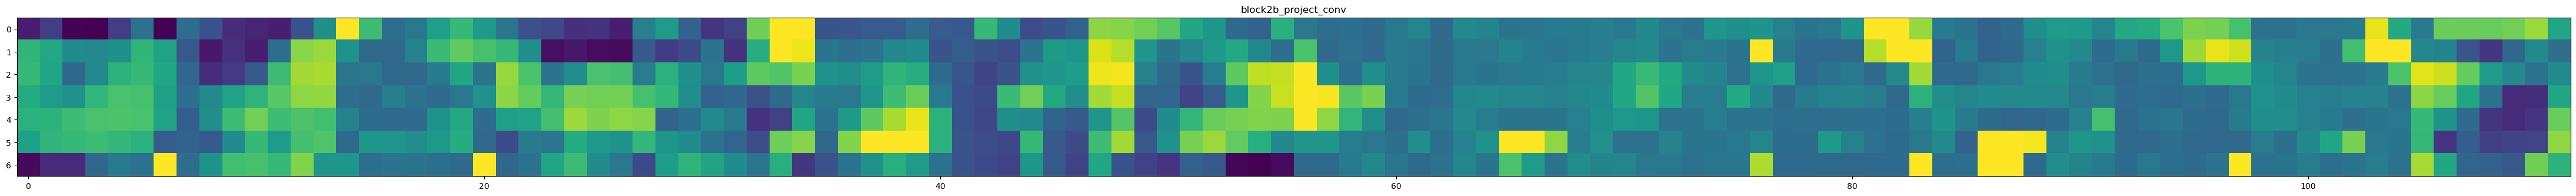

1/1 [==============================] - 0s 124ms/step


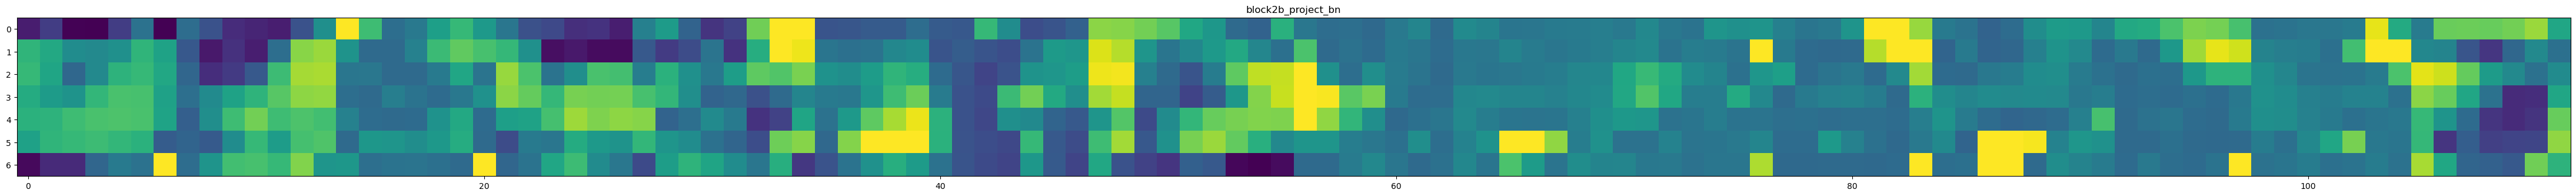

1/1 [==============================] - 0s 122ms/step


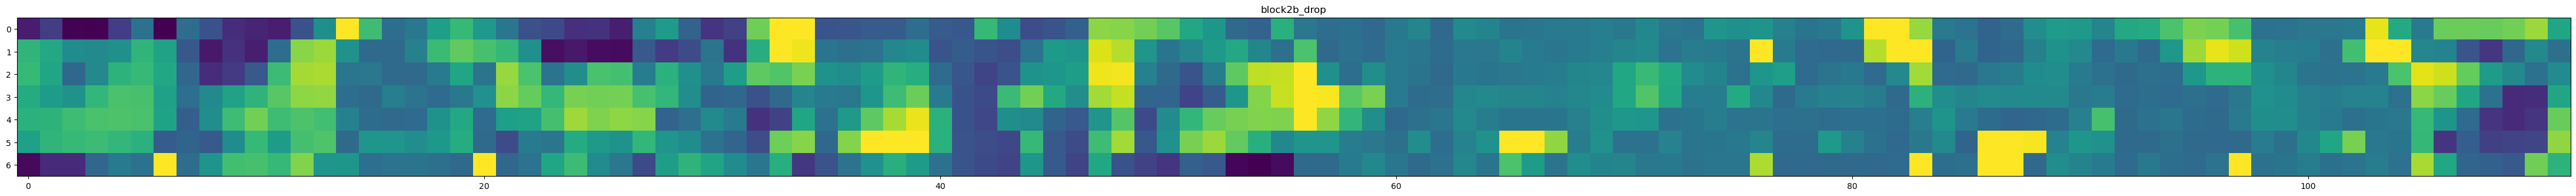

1/1 [==============================] - 0s 142ms/step


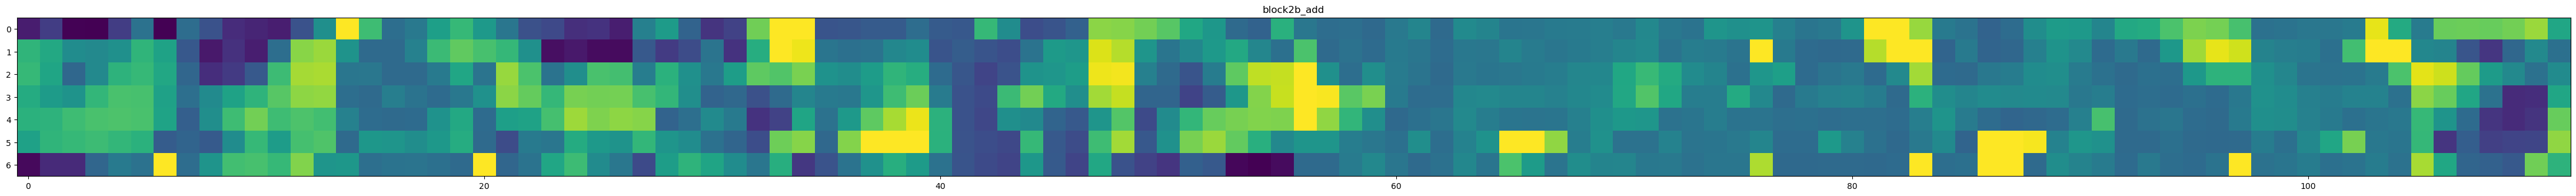

1/1 [==============================] - 0s 118ms/step


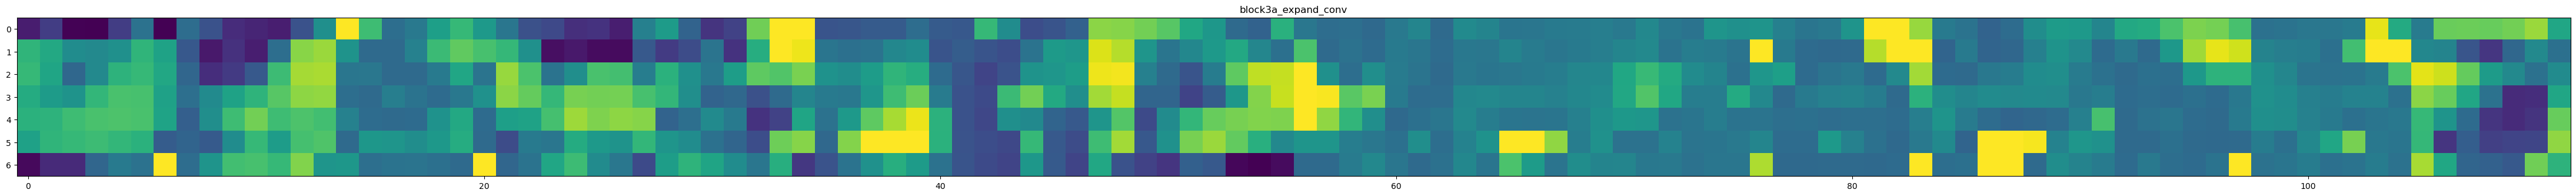

1/1 [==============================] - 0s 141ms/step


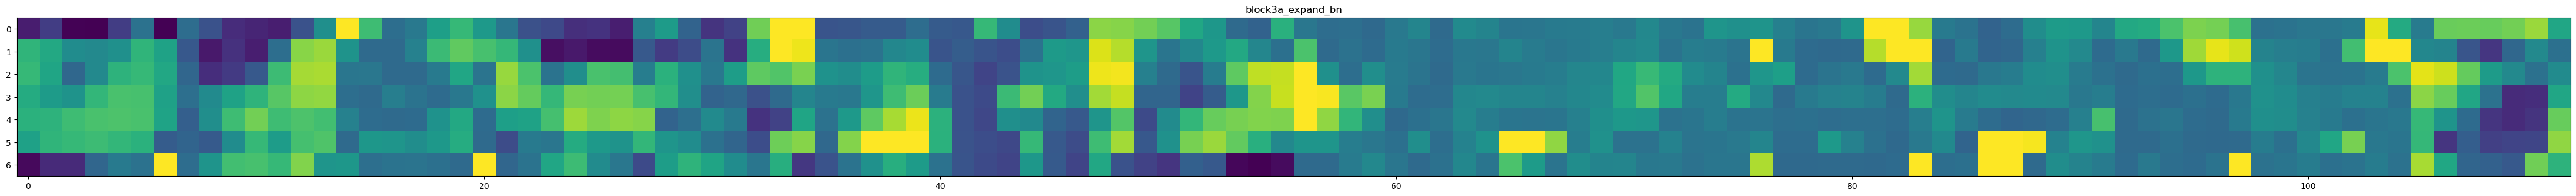

1/1 [==============================] - 0s 118ms/step


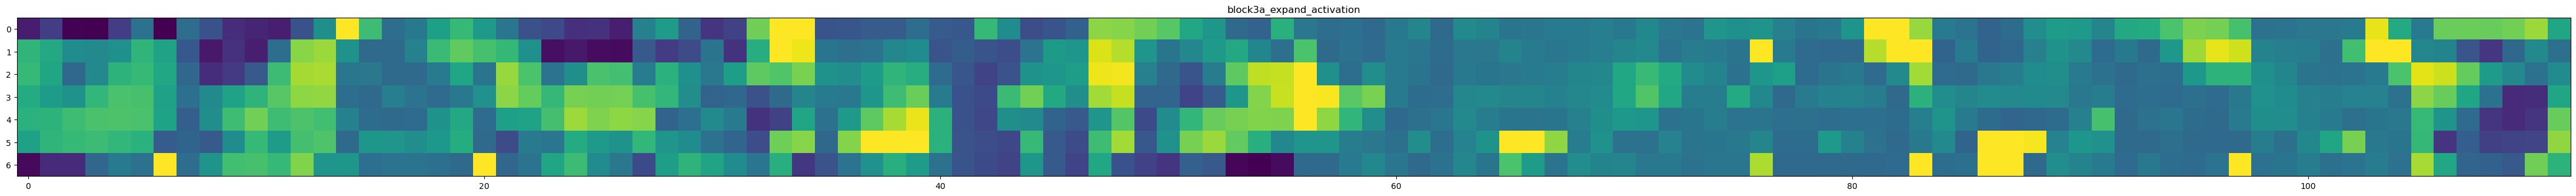

1/1 [==============================] - 0s 125ms/step


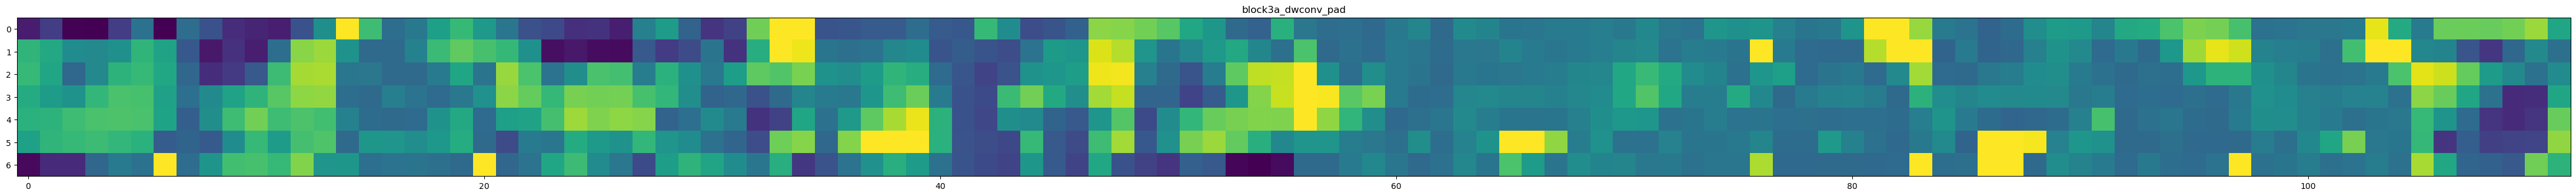

1/1 [==============================] - 0s 118ms/step


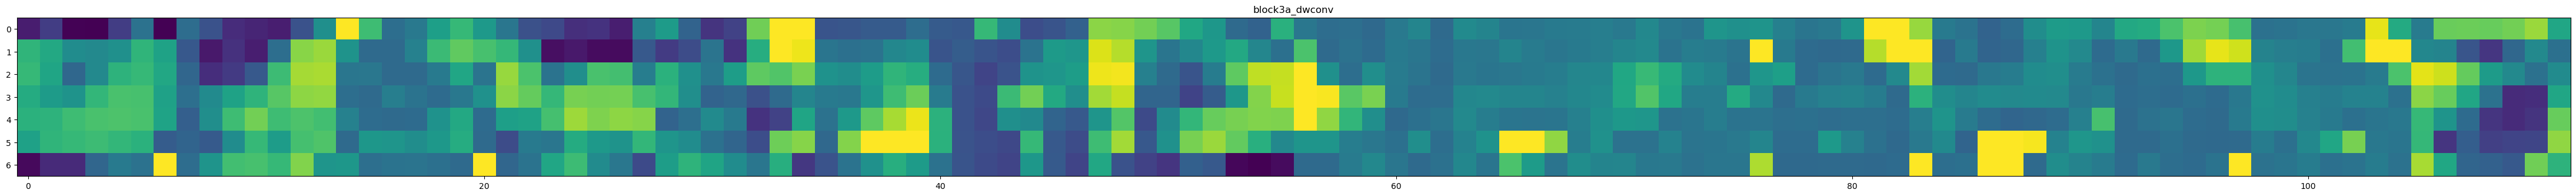

1/1 [==============================] - 0s 118ms/step


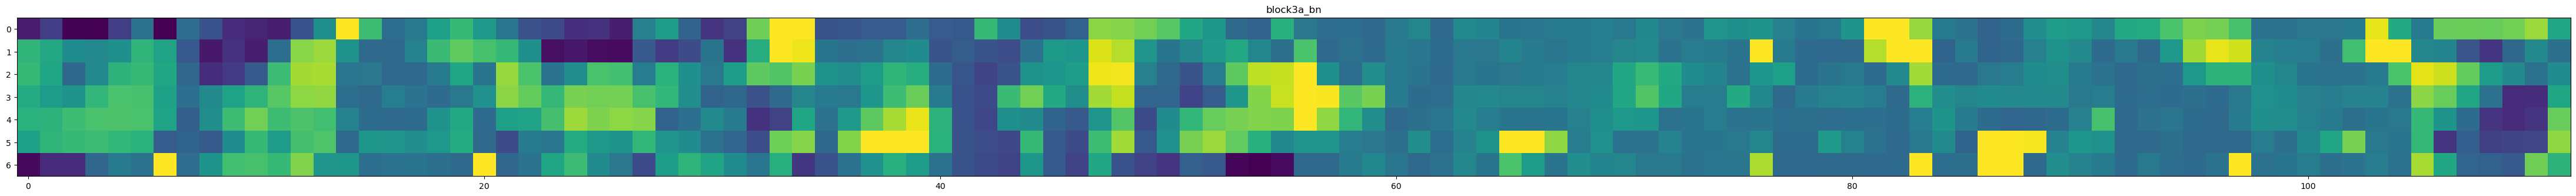

1/1 [==============================] - 0s 125ms/step


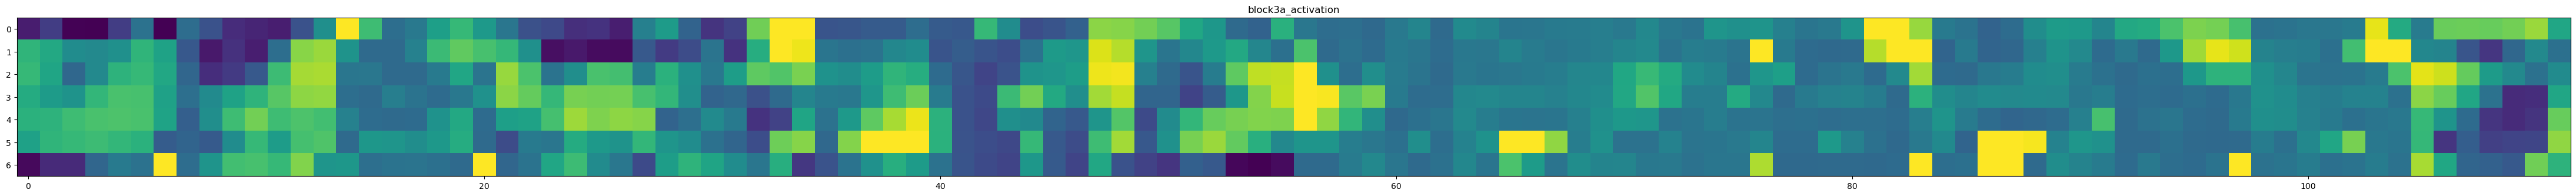

1/1 [==============================] - 0s 110ms/step


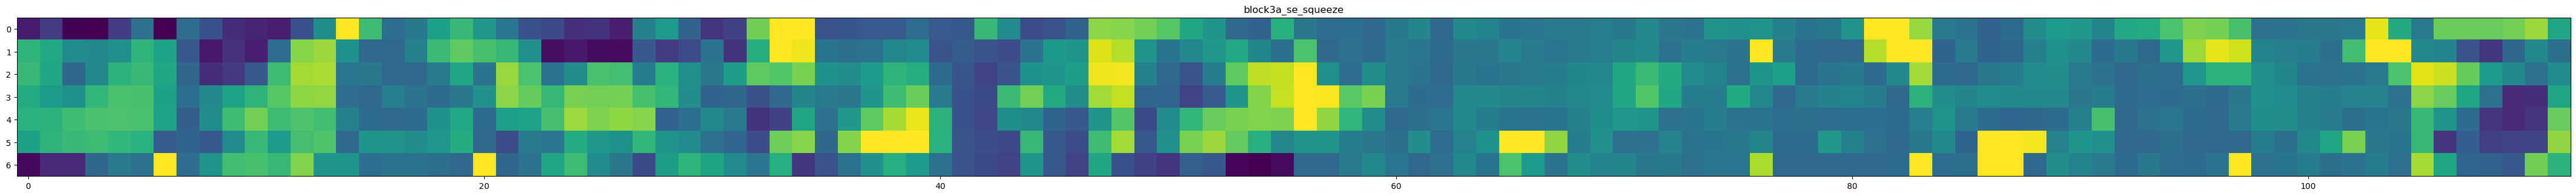

1/1 [==============================] - 0s 172ms/step


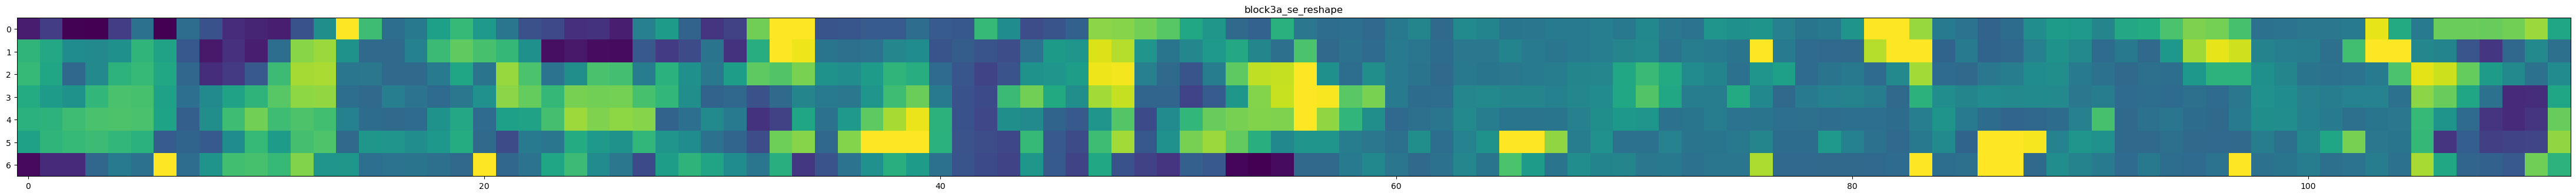

1/1 [==============================] - 0s 124ms/step


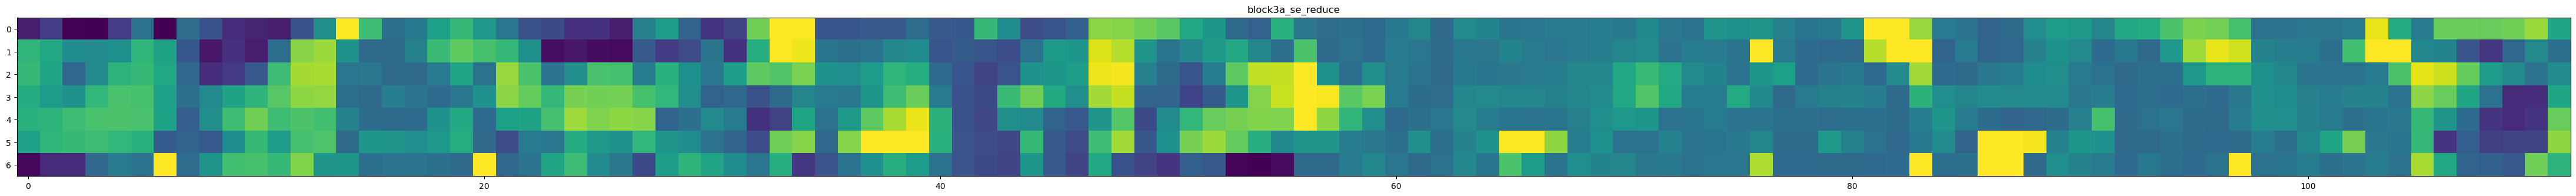

1/1 [==============================] - 0s 109ms/step


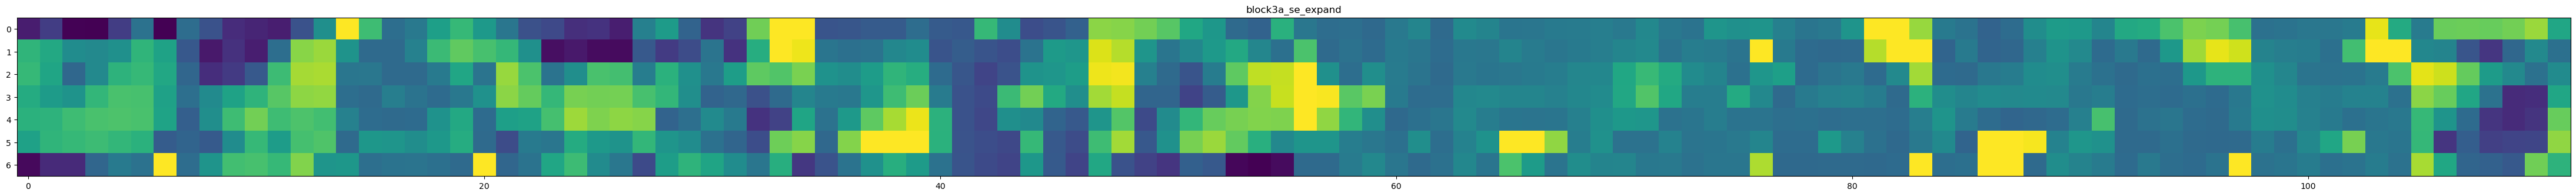

1/1 [==============================] - 0s 120ms/step


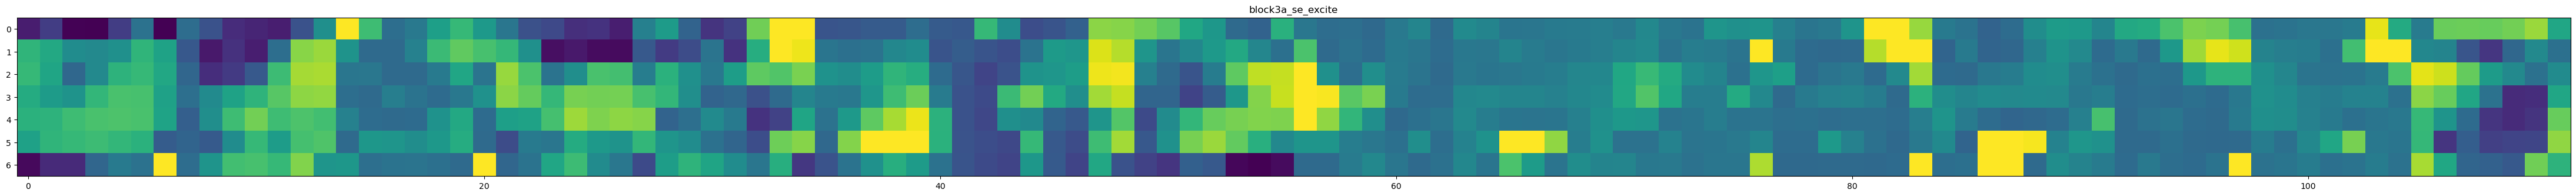

1/1 [==============================] - 0s 122ms/step


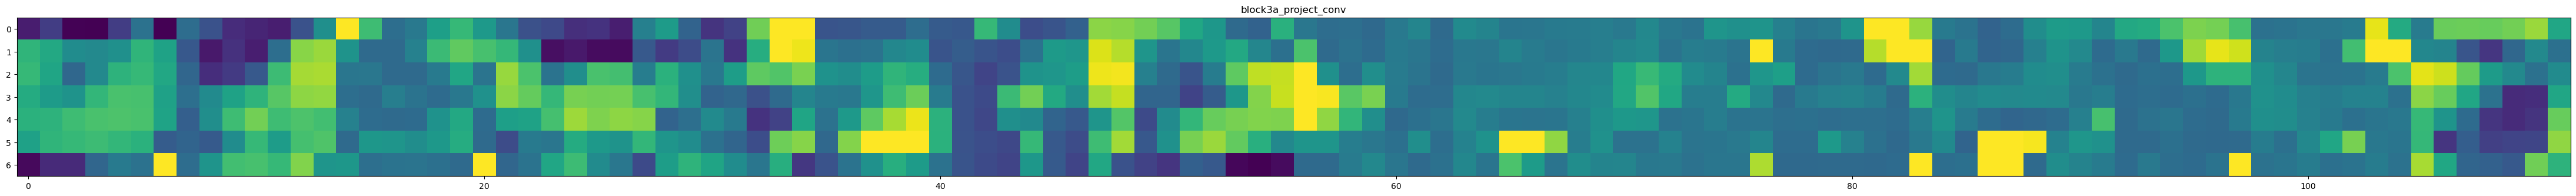

1/1 [==============================] - 0s 122ms/step


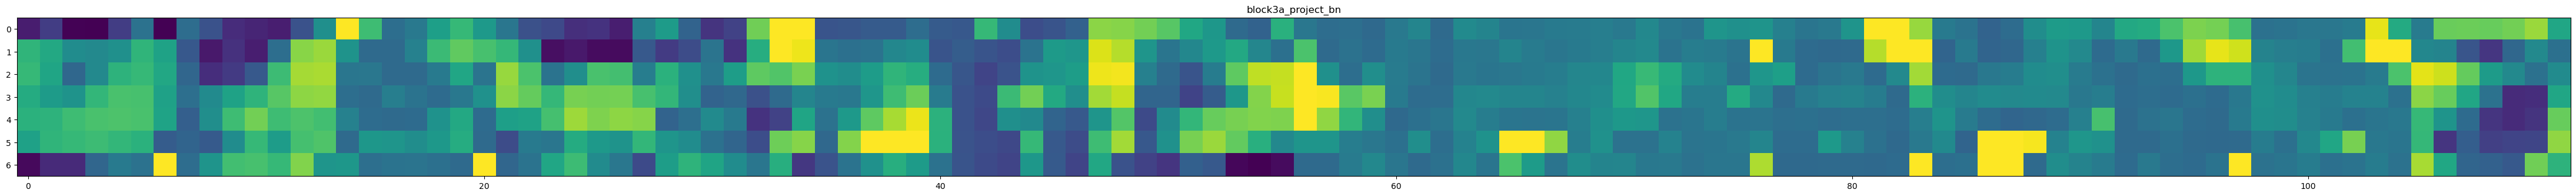

1/1 [==============================] - 0s 101ms/step


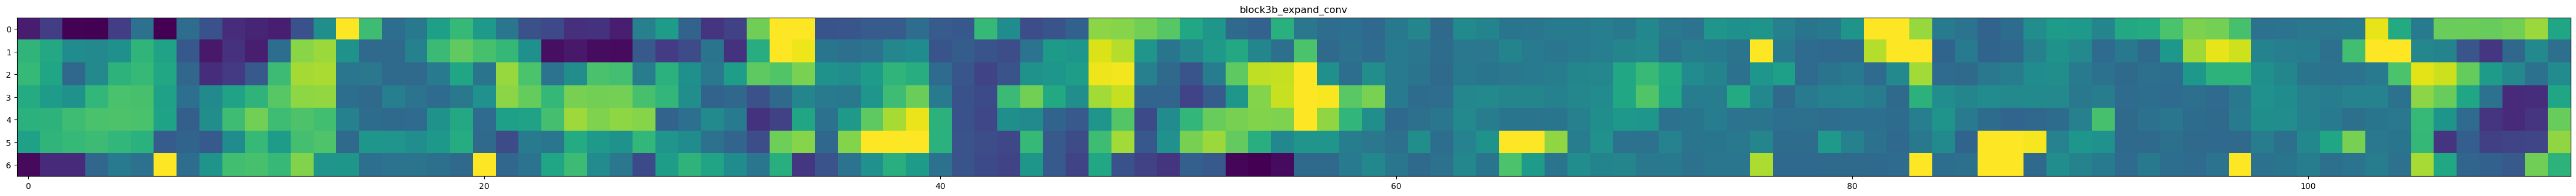

1/1 [==============================] - 0s 123ms/step


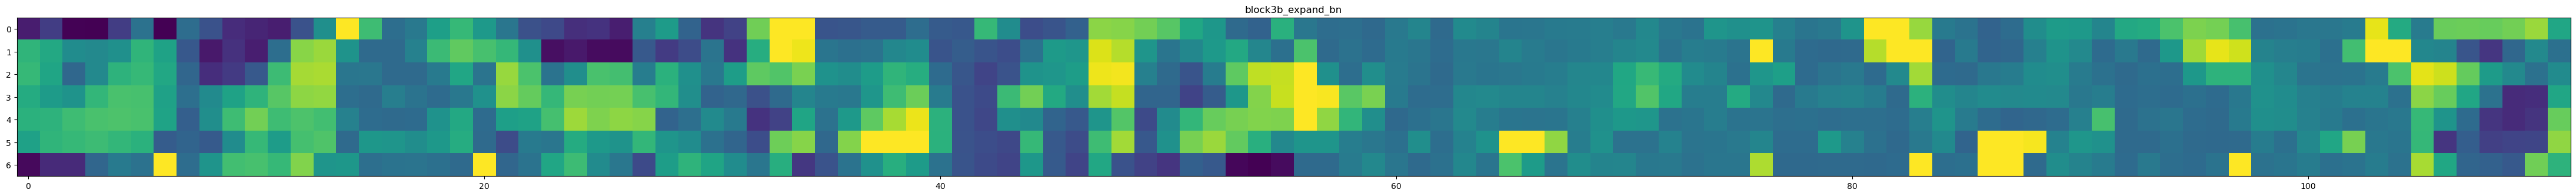

1/1 [==============================] - 0s 121ms/step


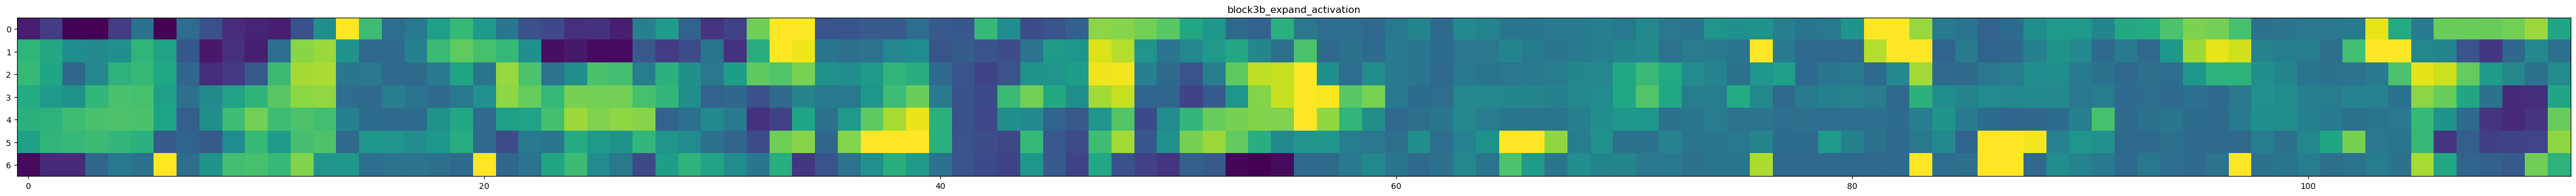

1/1 [==============================] - 0s 129ms/step


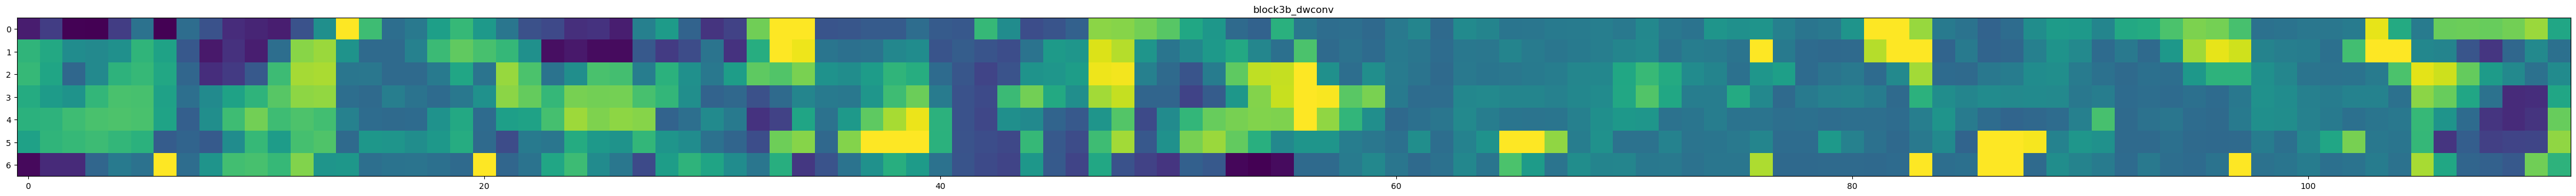

1/1 [==============================] - 0s 122ms/step


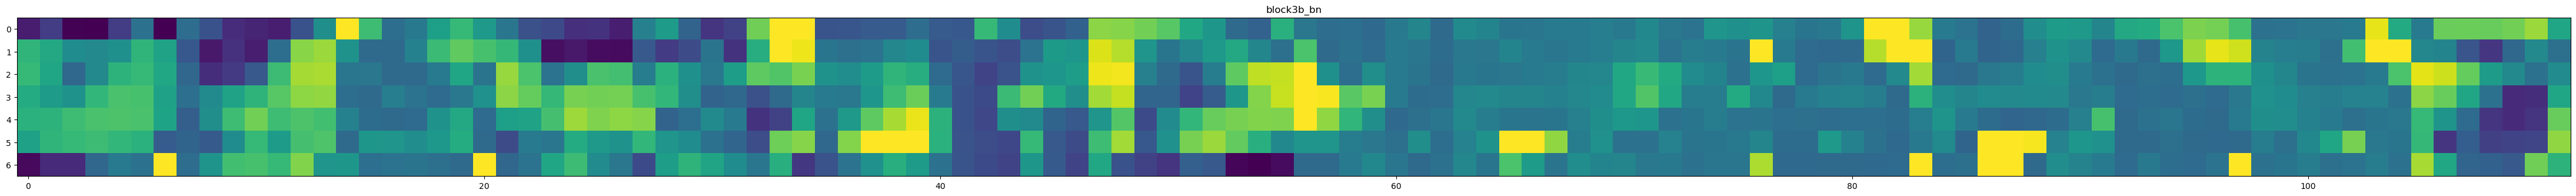

1/1 [==============================] - 0s 126ms/step


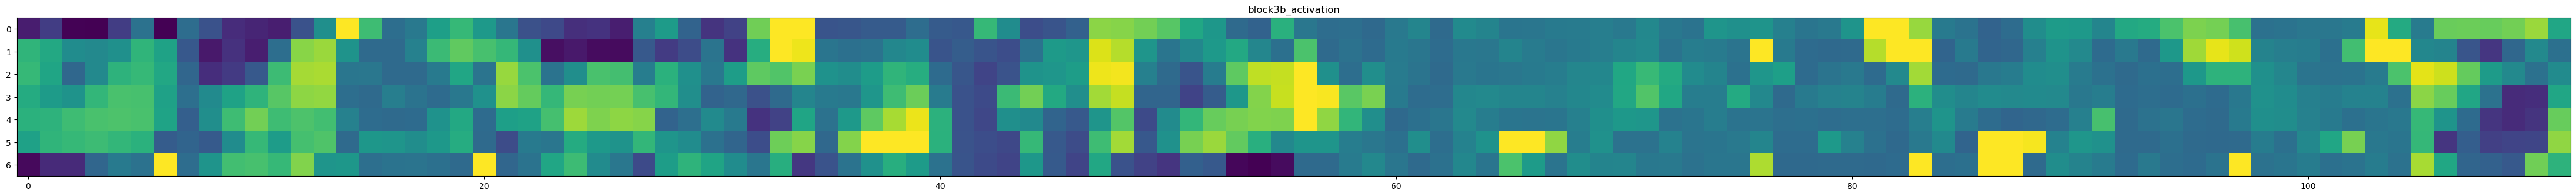

1/1 [==============================] - 0s 123ms/step


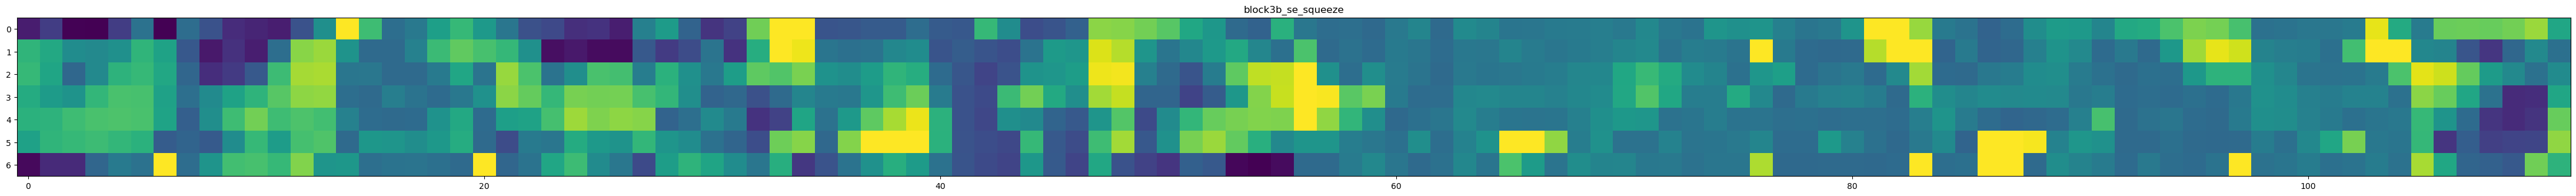

1/1 [==============================] - 0s 124ms/step


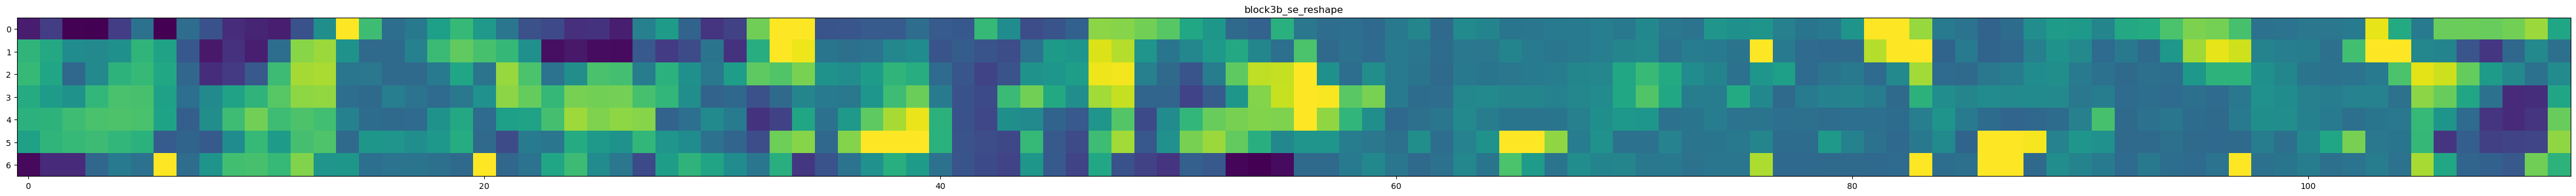

1/1 [==============================] - 0s 182ms/step


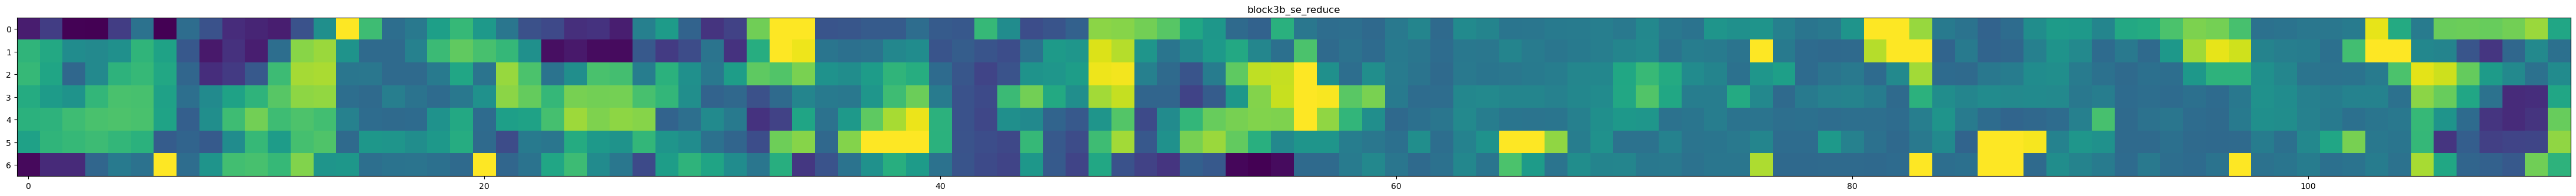

1/1 [==============================] - 0s 115ms/step


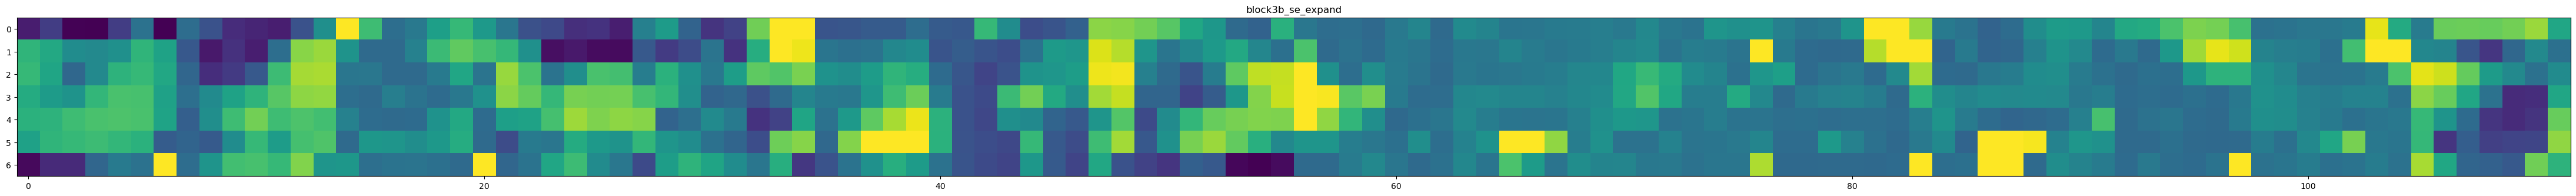

1/1 [==============================] - 0s 127ms/step


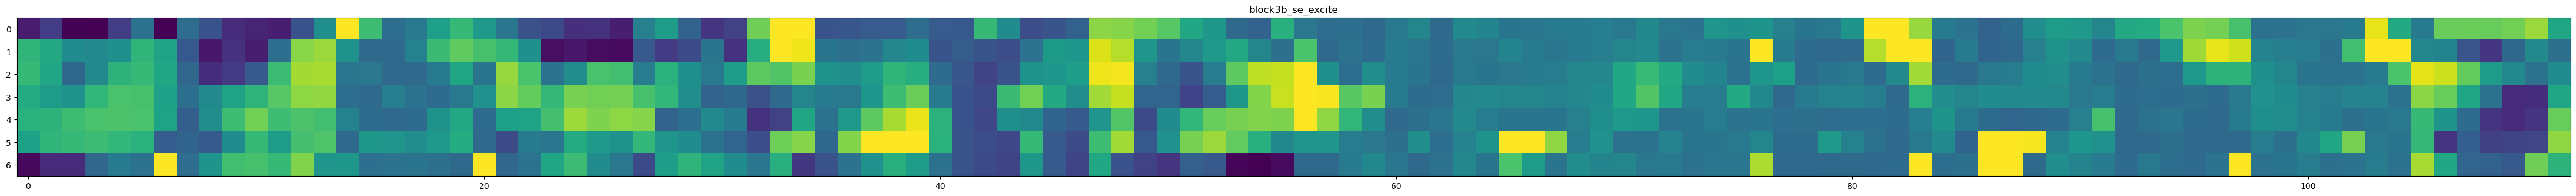

1/1 [==============================] - 0s 133ms/step


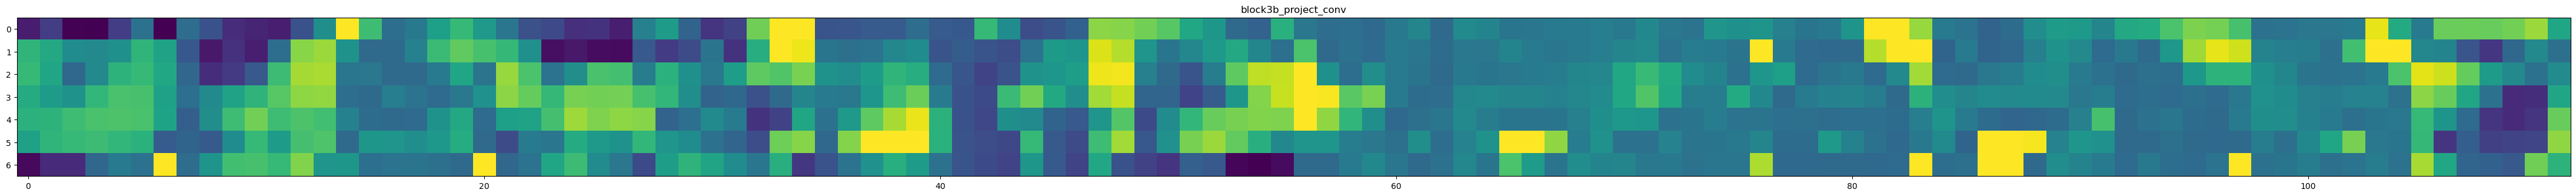

1/1 [==============================] - 0s 112ms/step


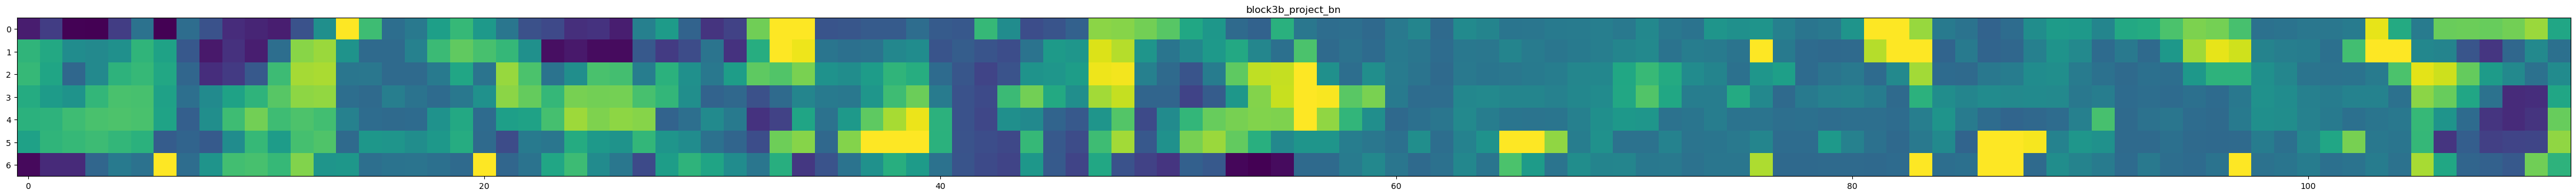

1/1 [==============================] - 0s 142ms/step


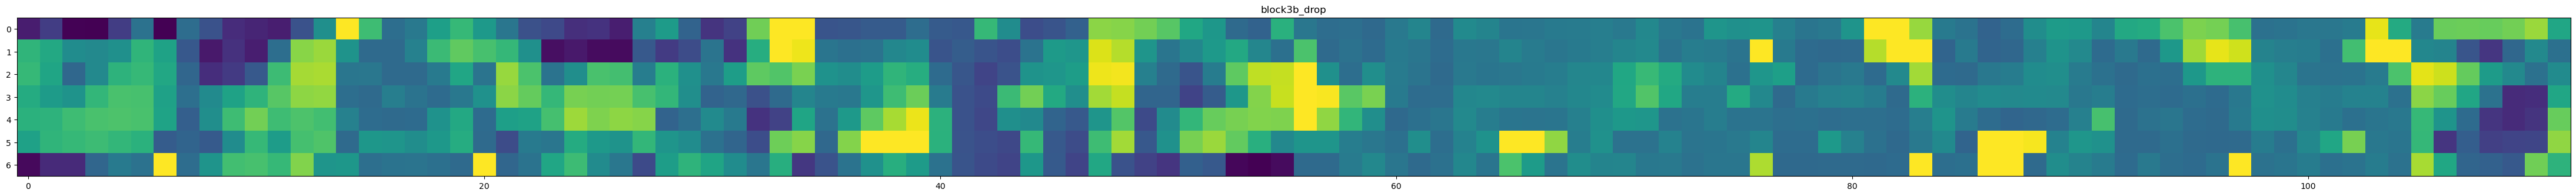

1/1 [==============================] - 0s 122ms/step


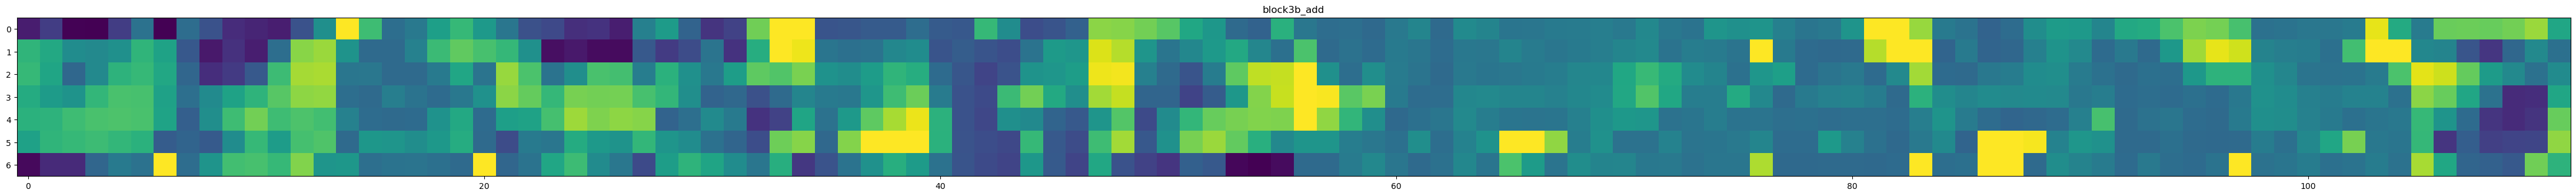

1/1 [==============================] - 0s 128ms/step


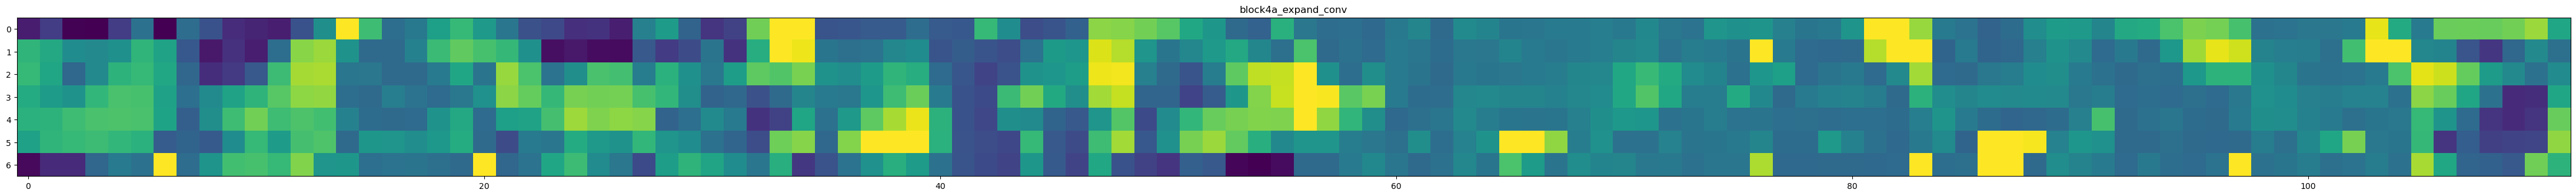

1/1 [==============================] - 0s 135ms/step


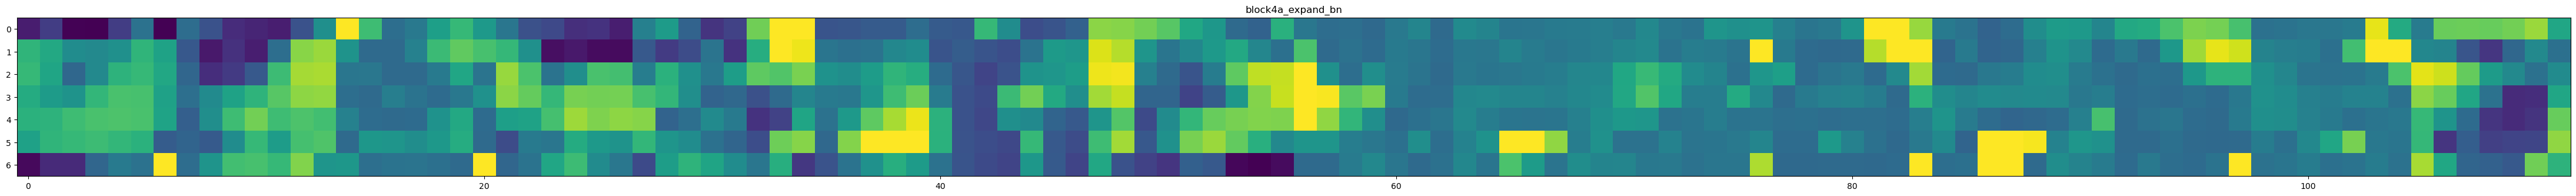

1/1 [==============================] - 0s 123ms/step


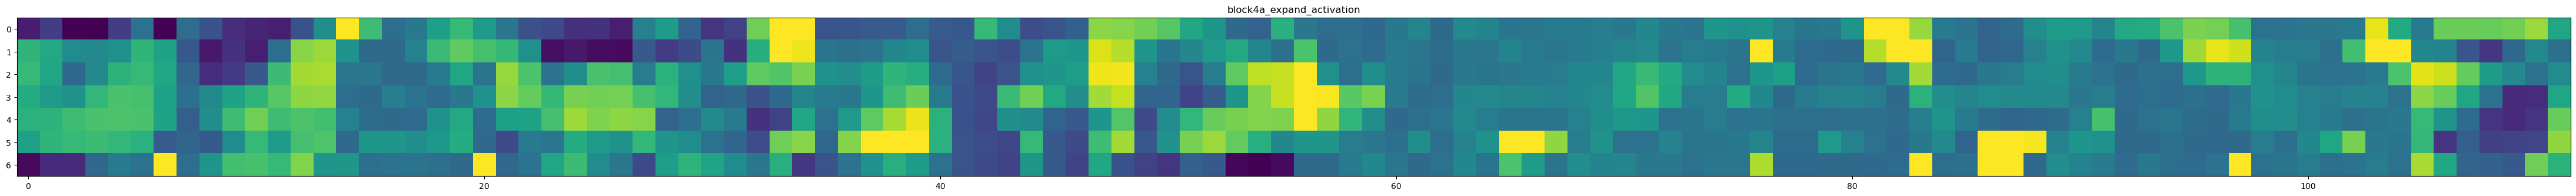

1/1 [==============================] - 0s 124ms/step


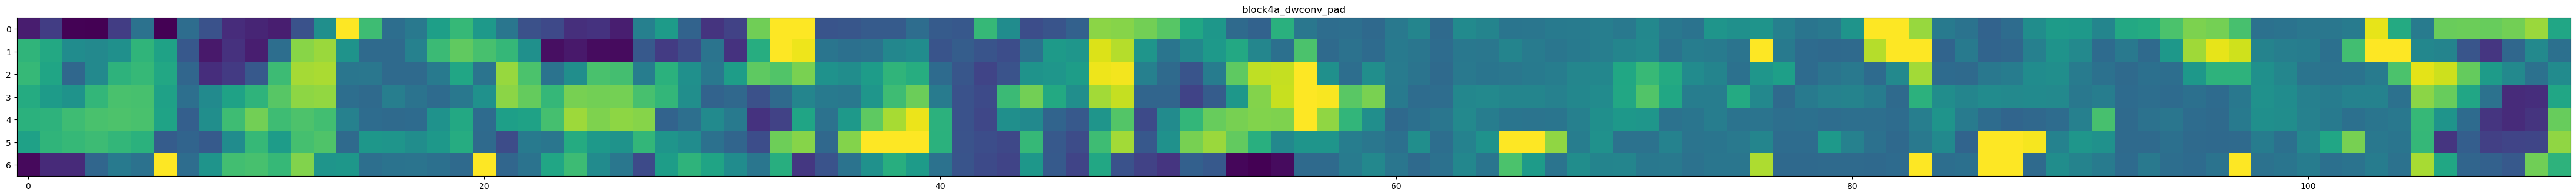

1/1 [==============================] - 0s 126ms/step


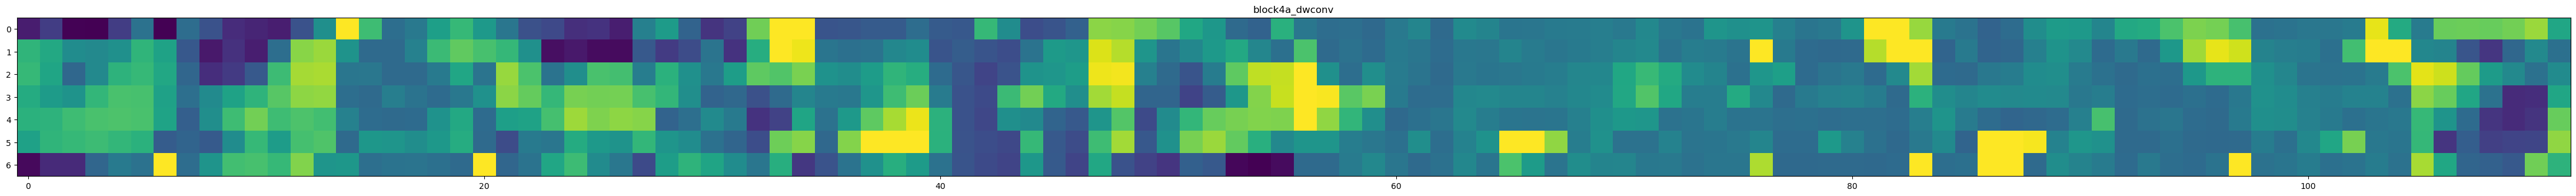

1/1 [==============================] - 0s 117ms/step


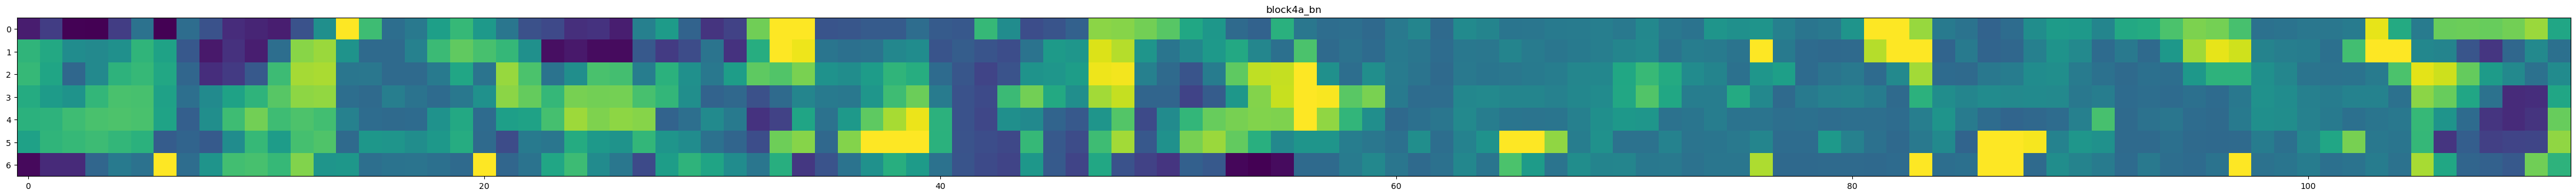

1/1 [==============================] - 0s 119ms/step


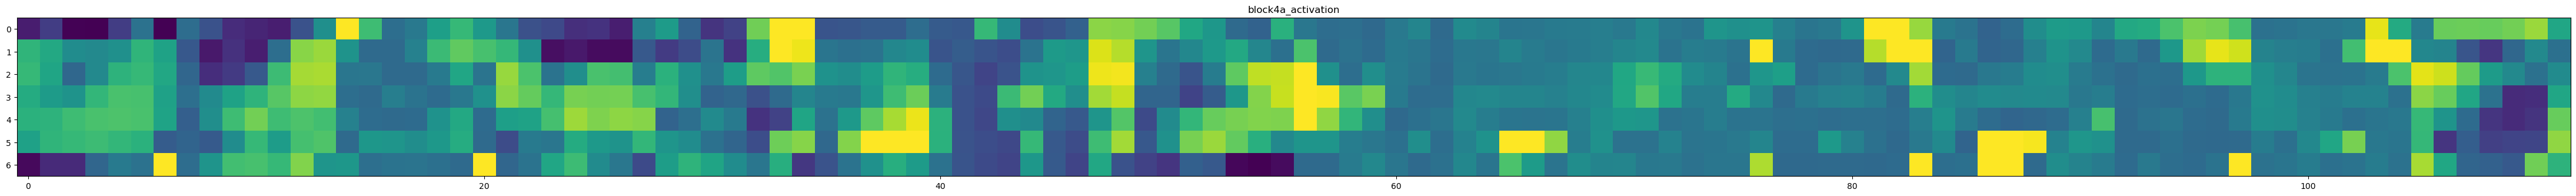

1/1 [==============================] - 0s 119ms/step


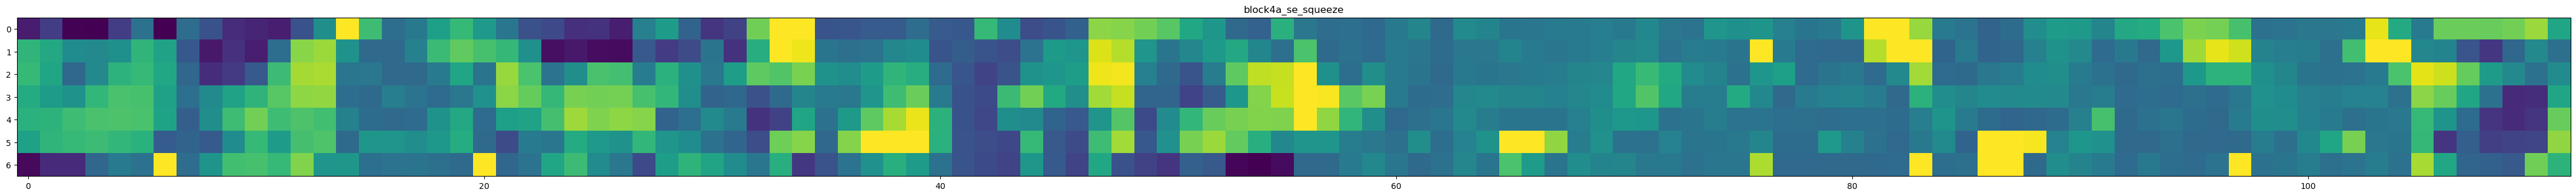

1/1 [==============================] - 0s 120ms/step


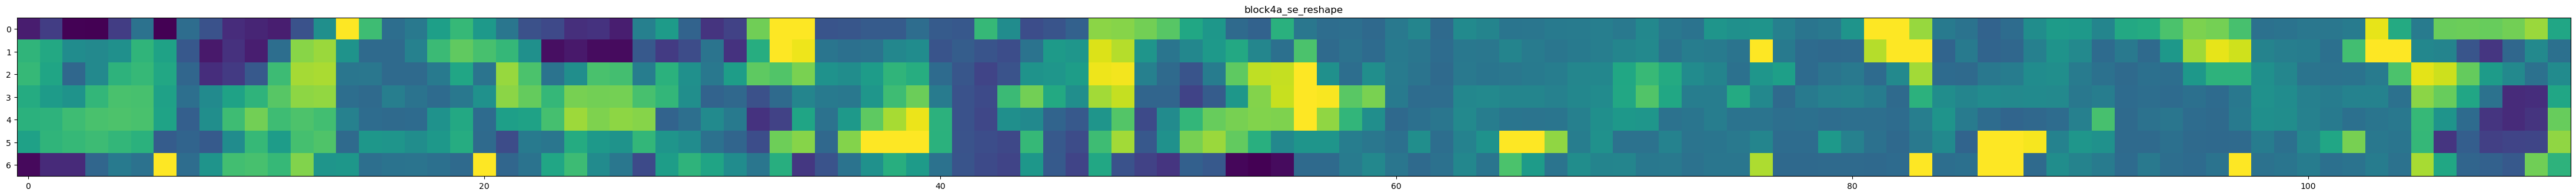

1/1 [==============================] - 0s 116ms/step


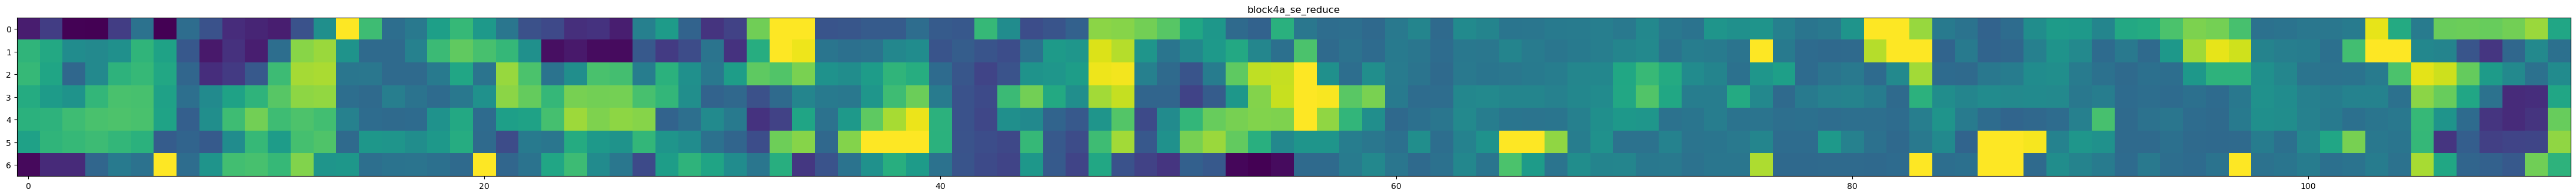

1/1 [==============================] - 0s 141ms/step


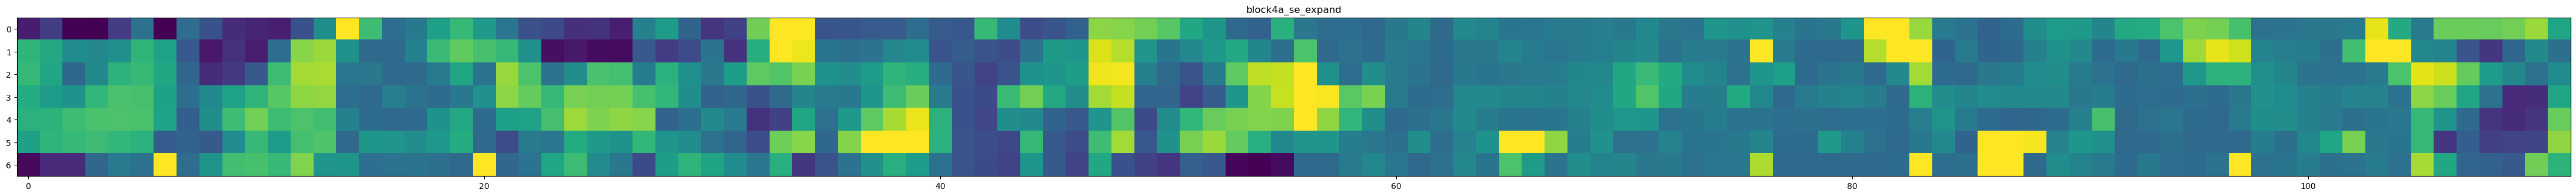

1/1 [==============================] - 0s 123ms/step


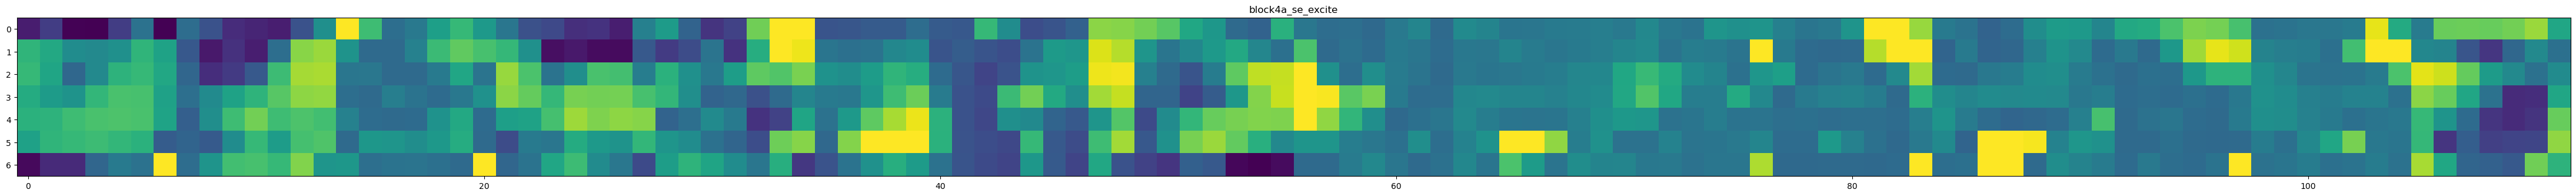

1/1 [==============================] - 0s 118ms/step


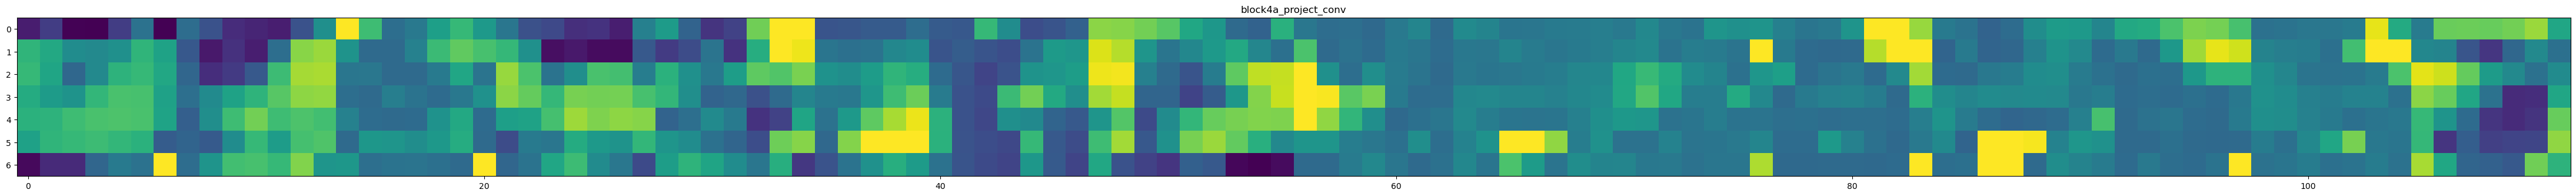

1/1 [==============================] - 0s 110ms/step


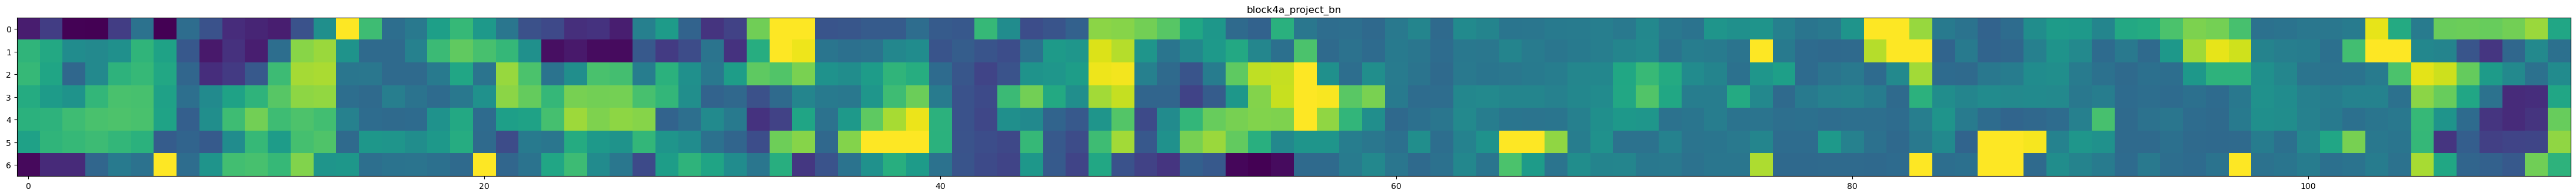

1/1 [==============================] - 0s 121ms/step


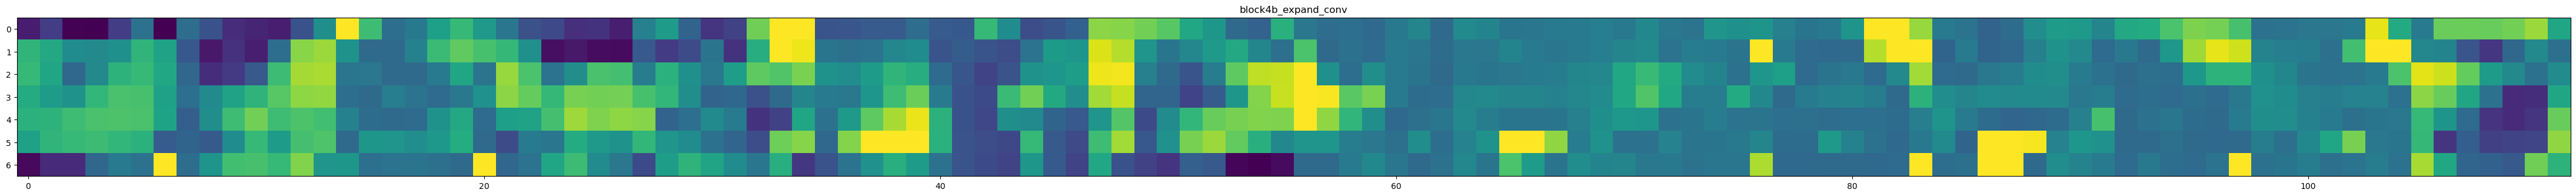

1/1 [==============================] - 0s 126ms/step


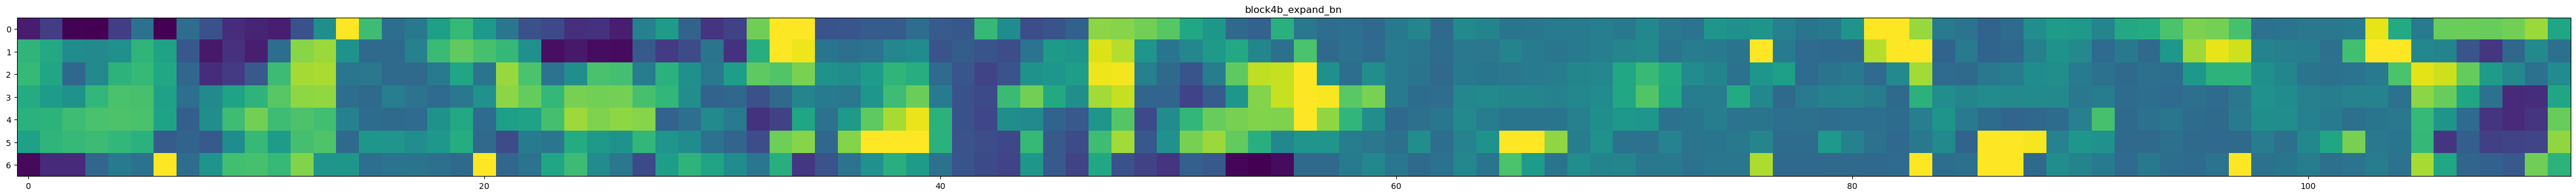

1/1 [==============================] - 0s 131ms/step


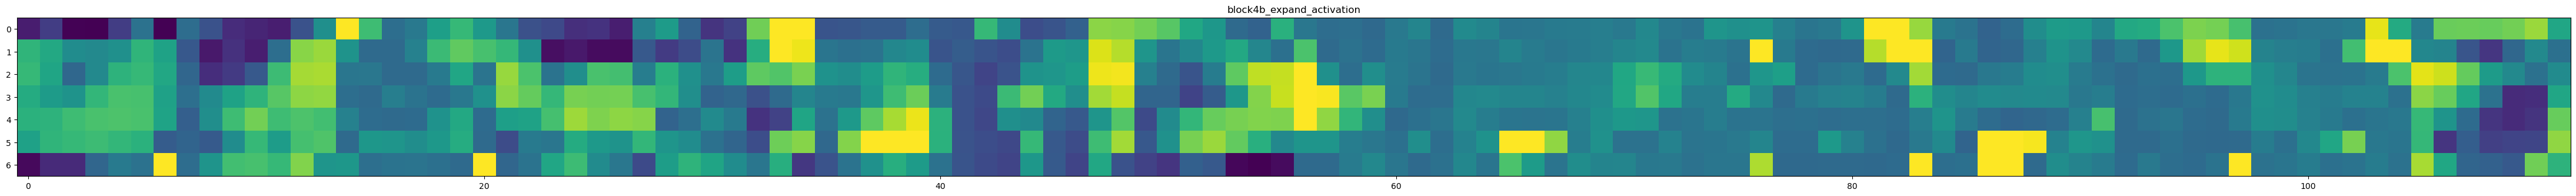

1/1 [==============================] - 0s 116ms/step


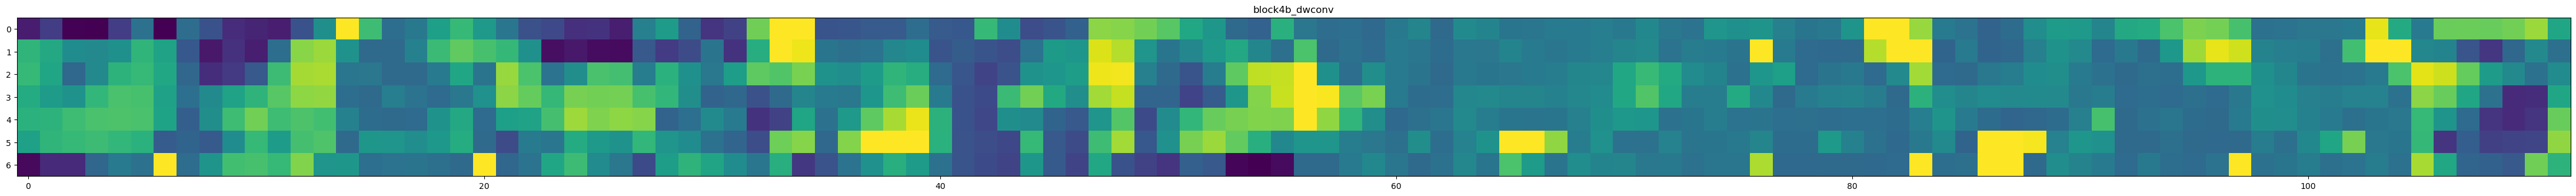

1/1 [==============================] - 0s 119ms/step


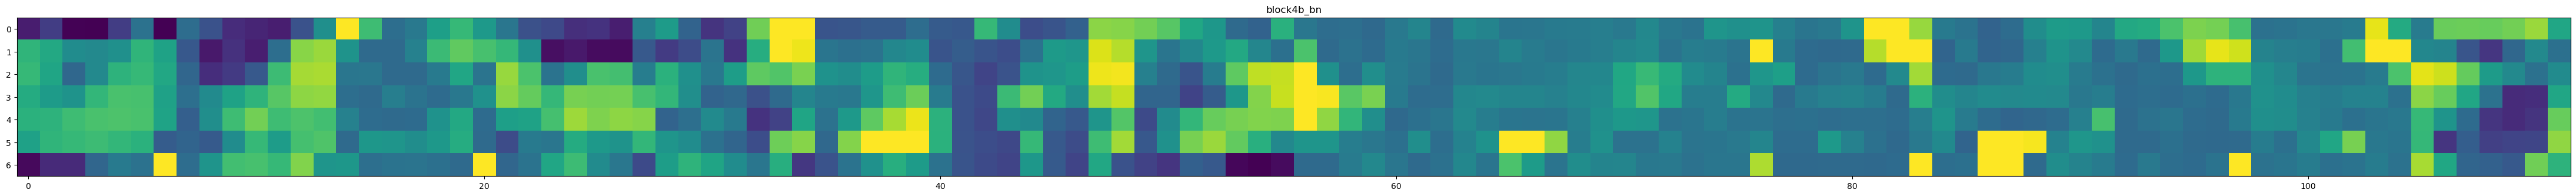

1/1 [==============================] - 0s 119ms/step


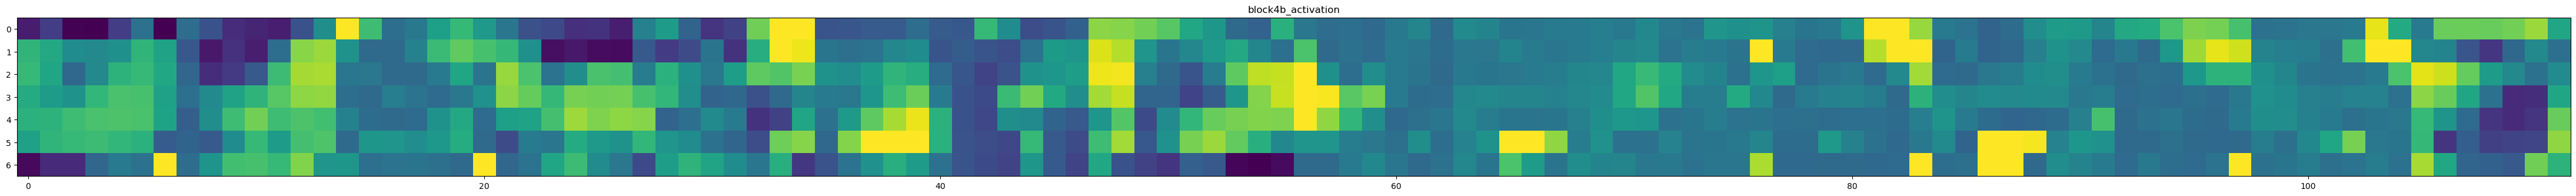

1/1 [==============================] - 0s 126ms/step


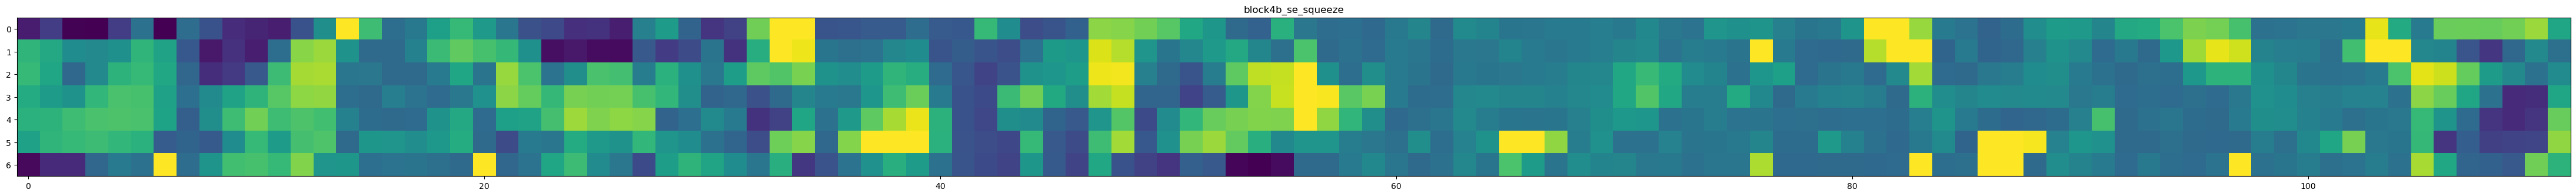

1/1 [==============================] - 0s 118ms/step


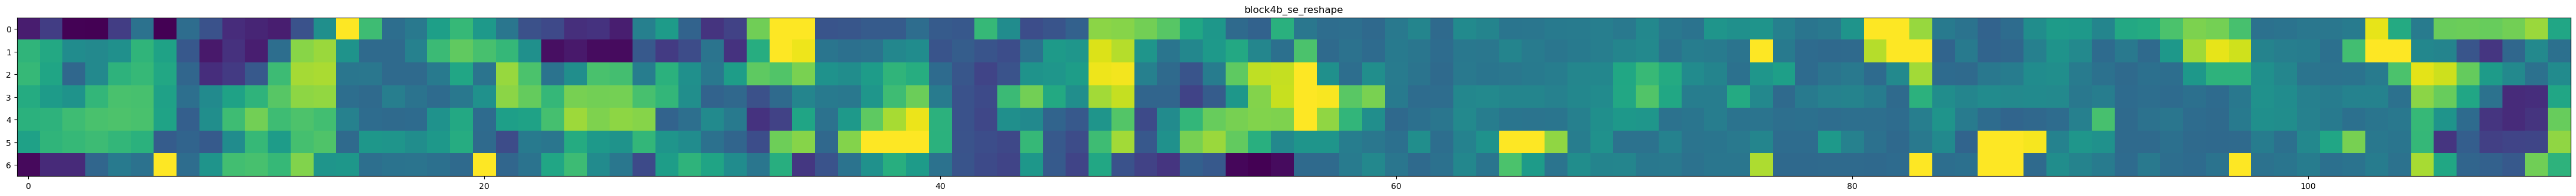

1/1 [==============================] - 0s 130ms/step


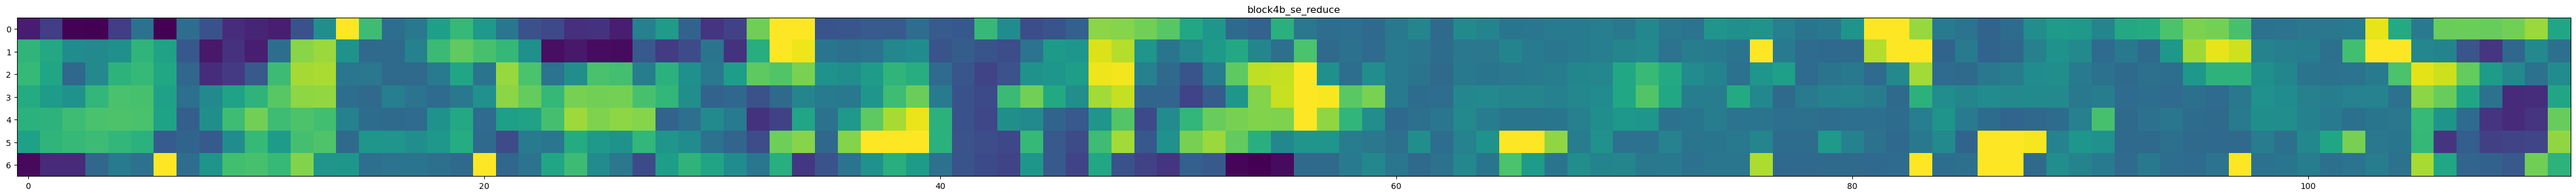

1/1 [==============================] - 0s 123ms/step


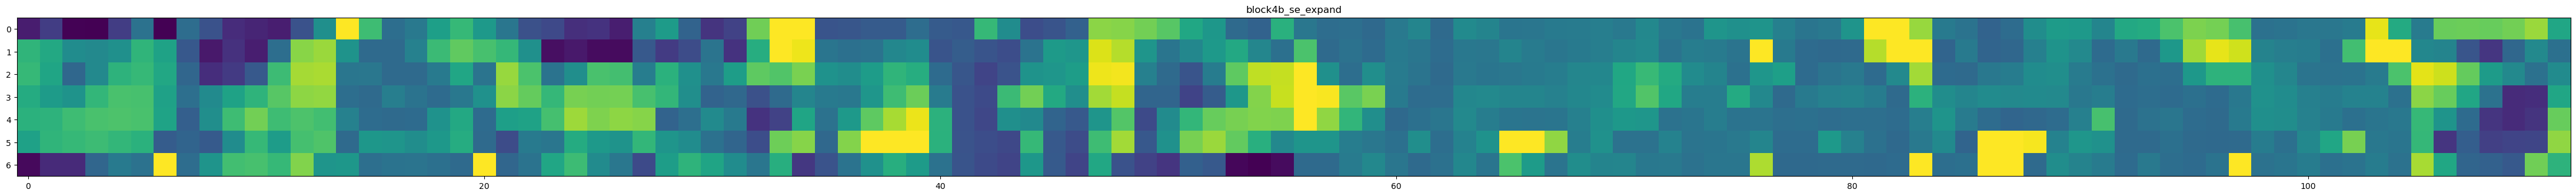

1/1 [==============================] - 0s 118ms/step


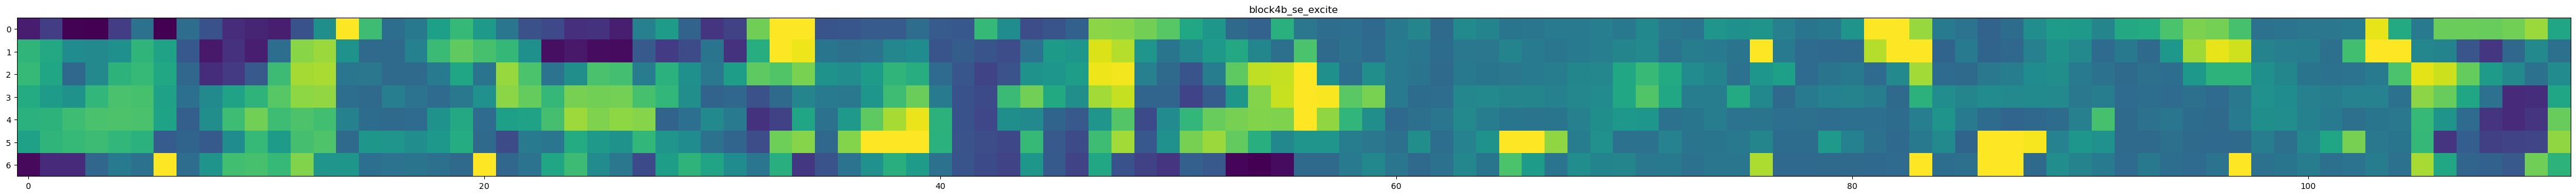

1/1 [==============================] - 0s 130ms/step


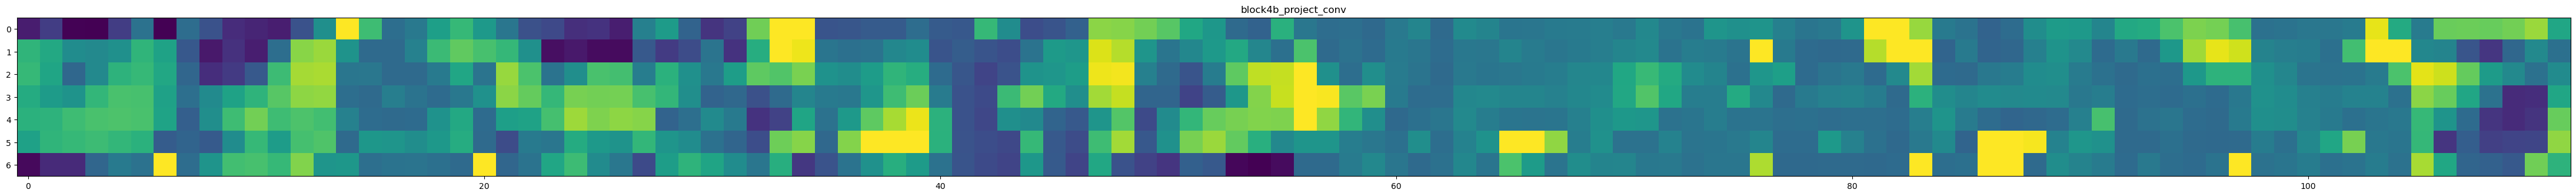

1/1 [==============================] - 0s 114ms/step


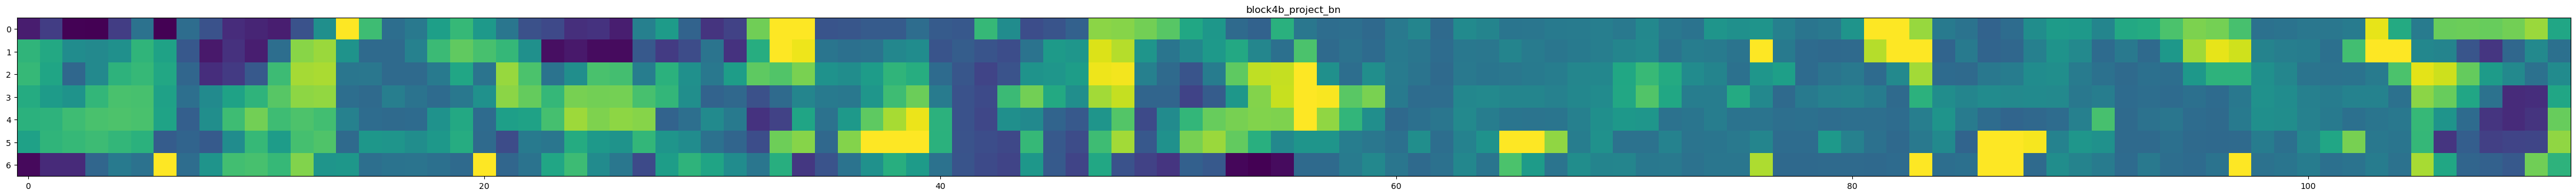

1/1 [==============================] - 0s 127ms/step


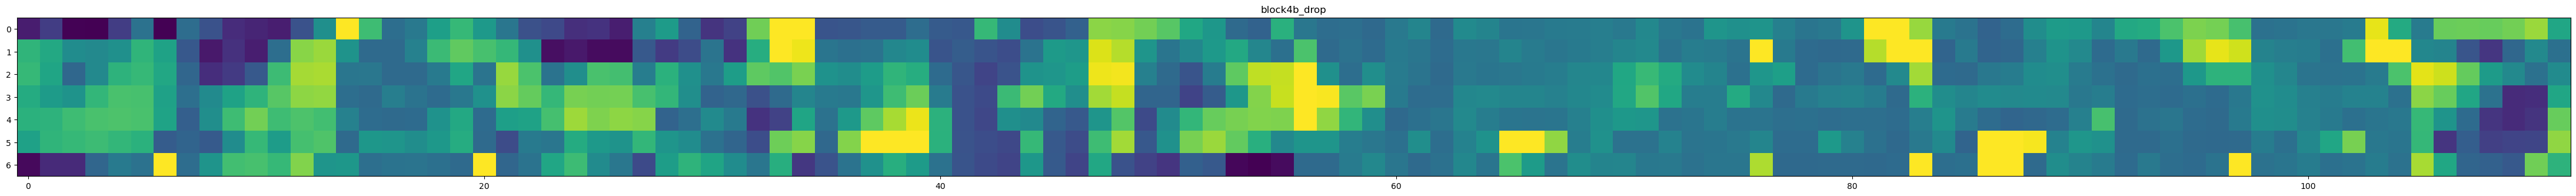

1/1 [==============================] - 0s 110ms/step


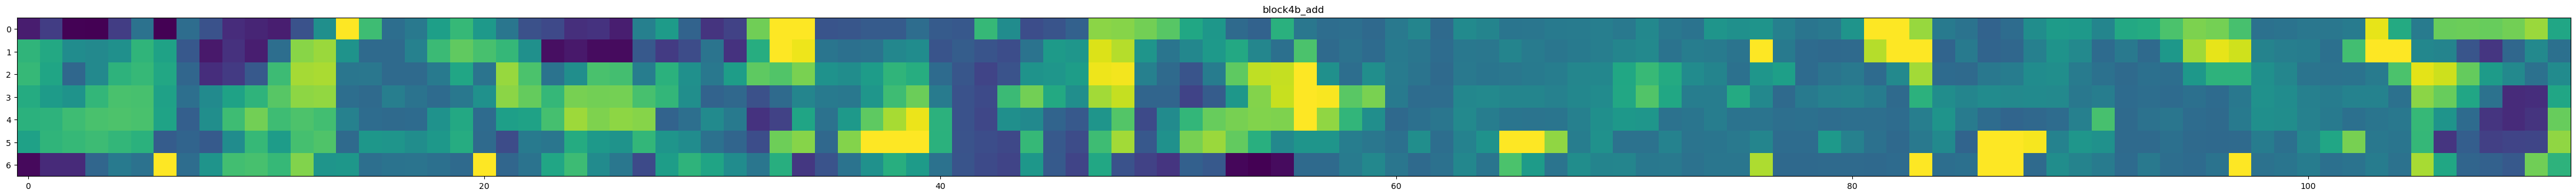

1/1 [==============================] - 0s 122ms/step


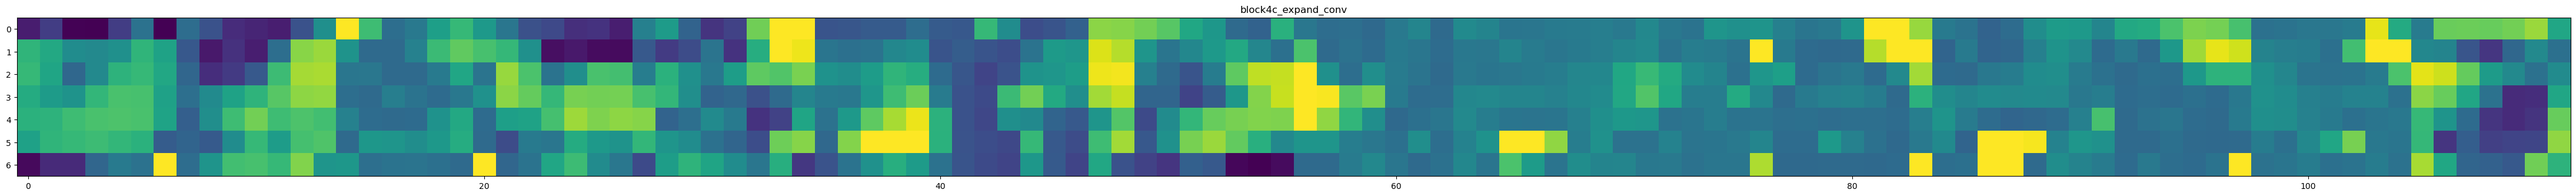

1/1 [==============================] - 0s 126ms/step


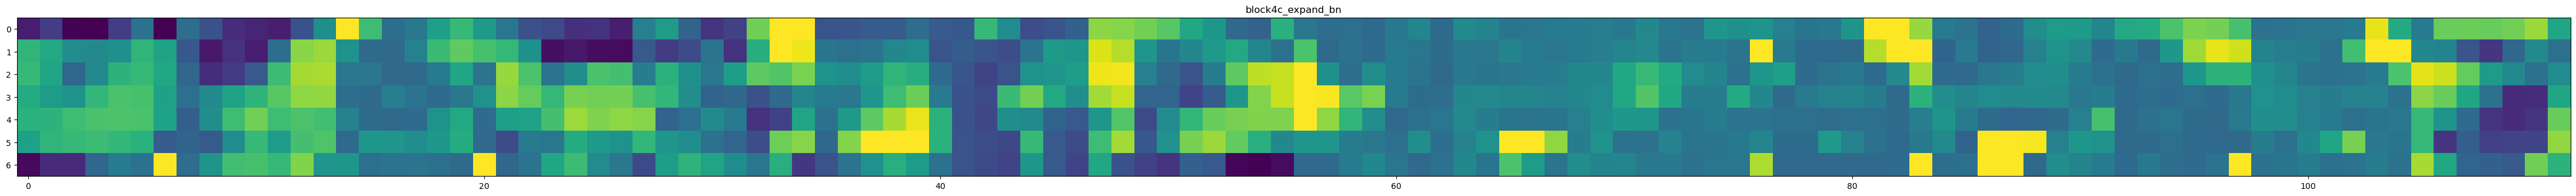

1/1 [==============================] - 0s 124ms/step


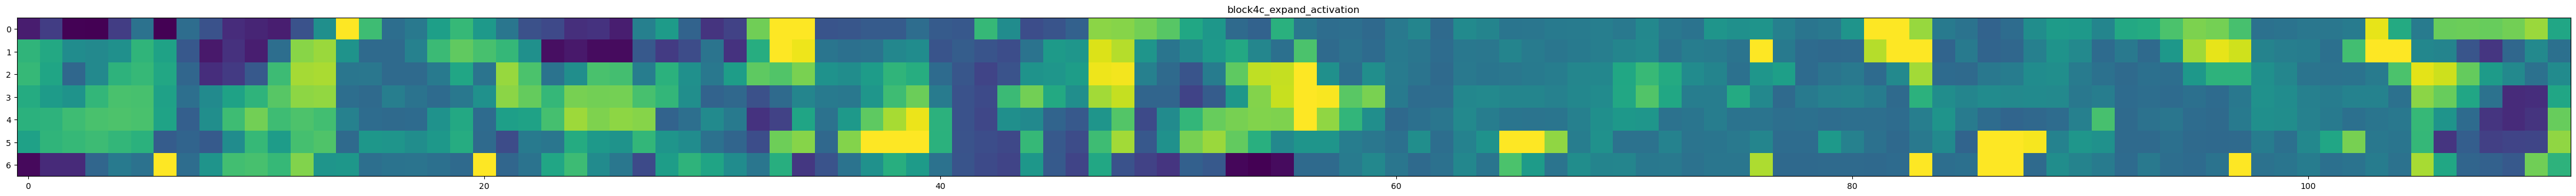

1/1 [==============================] - 0s 111ms/step


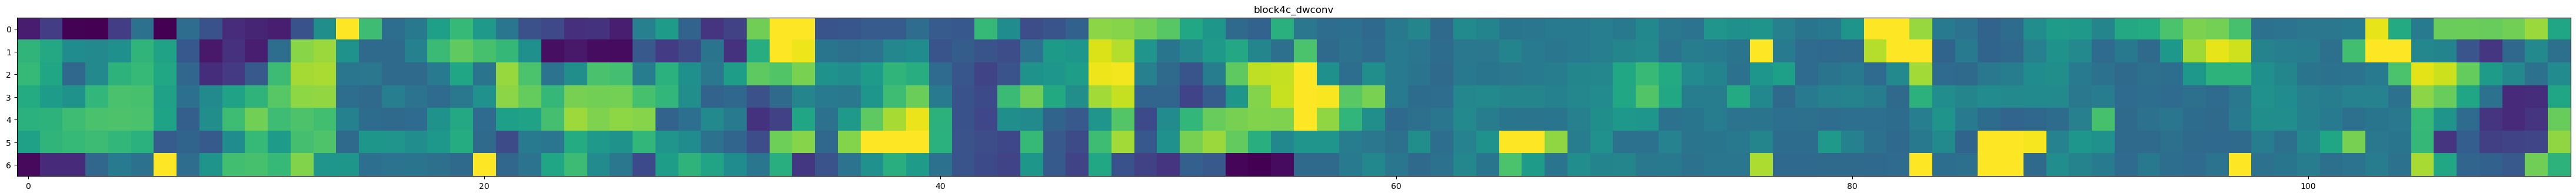

1/1 [==============================] - 0s 126ms/step


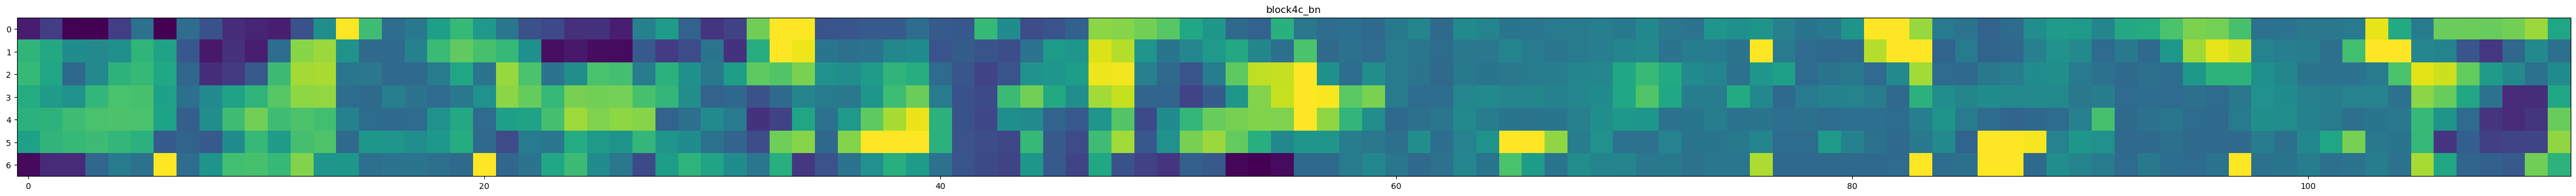

1/1 [==============================] - 0s 121ms/step


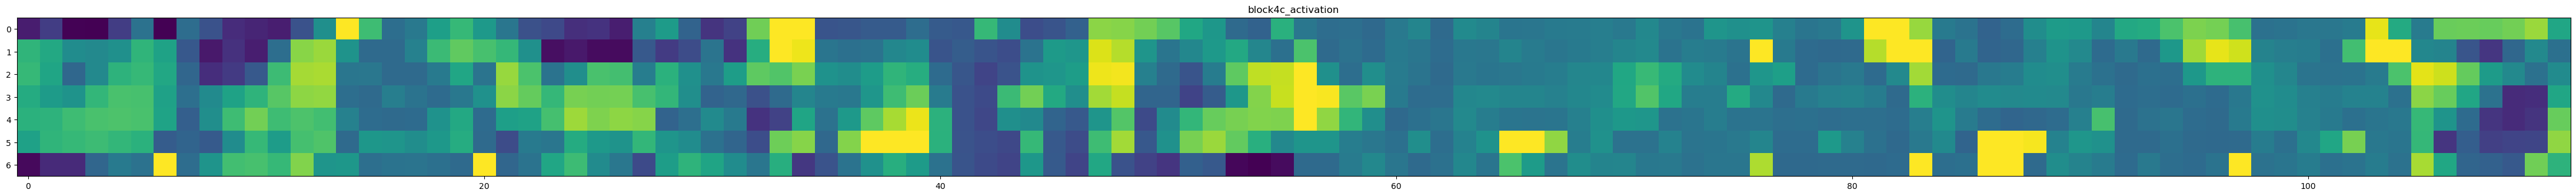

1/1 [==============================] - 0s 116ms/step


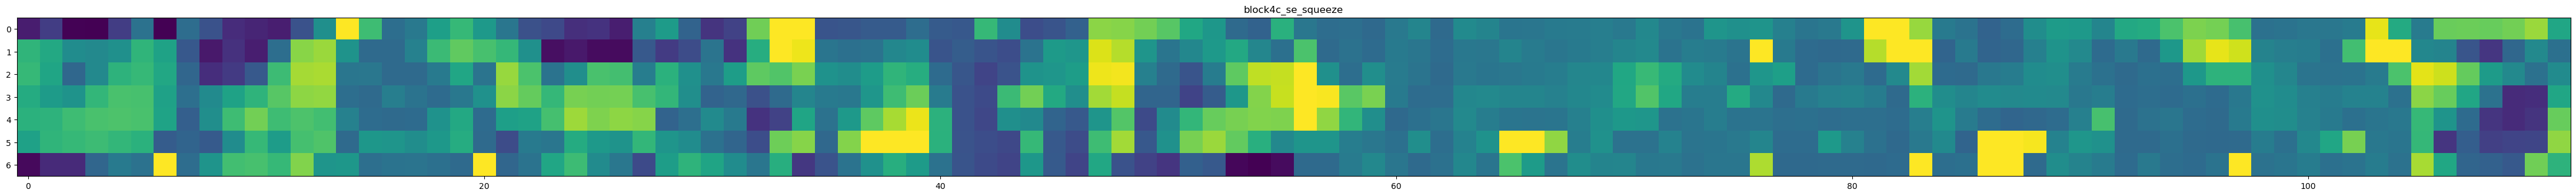

1/1 [==============================] - 0s 125ms/step


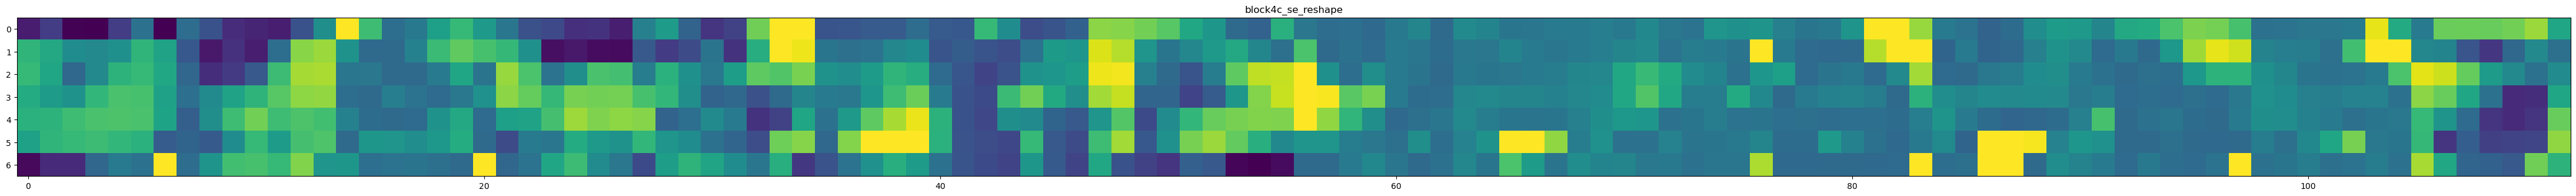

1/1 [==============================] - 0s 120ms/step


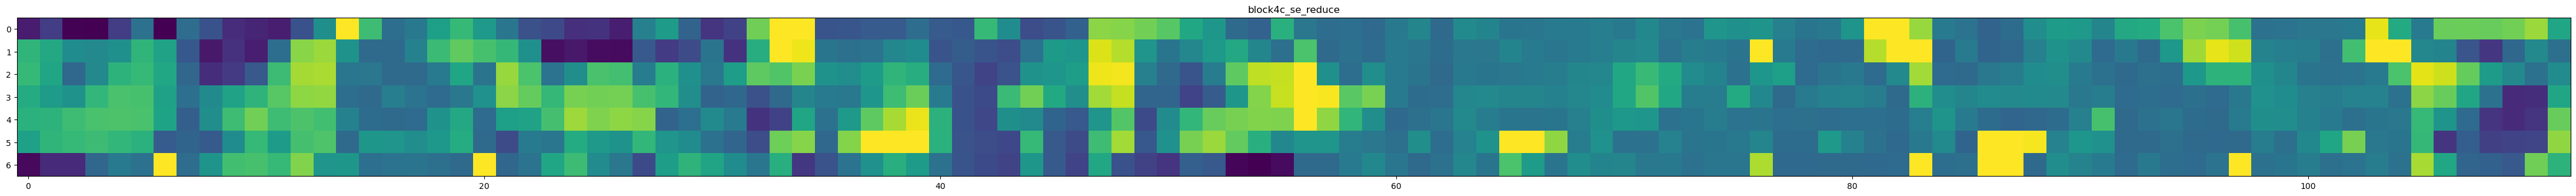

1/1 [==============================] - 0s 115ms/step


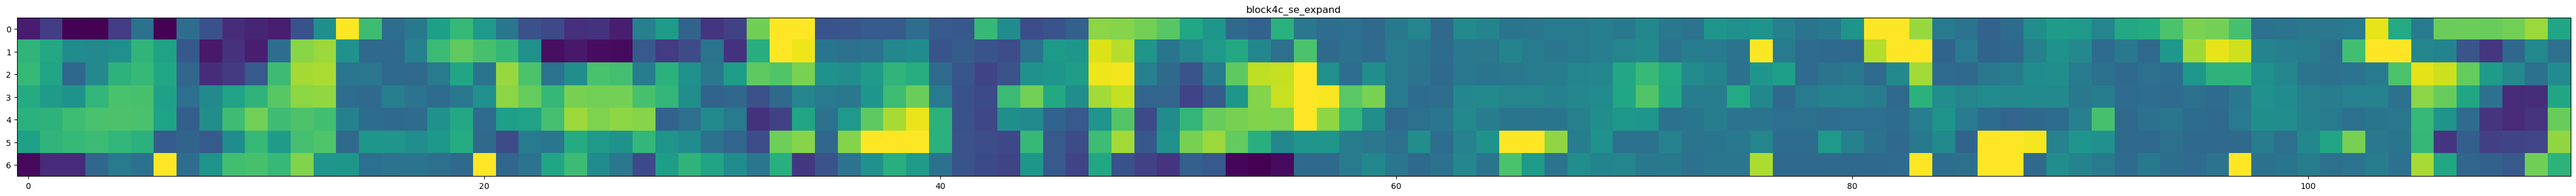

1/1 [==============================] - 0s 129ms/step


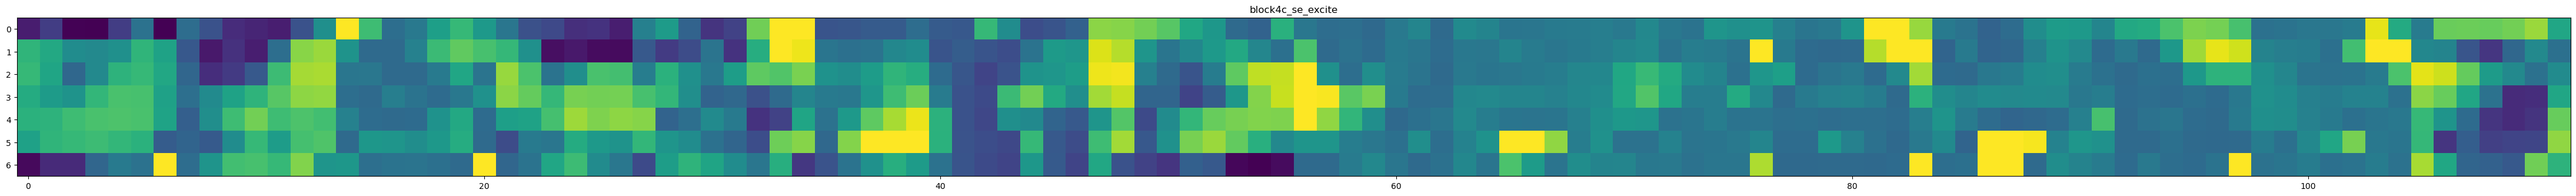

1/1 [==============================] - 0s 126ms/step


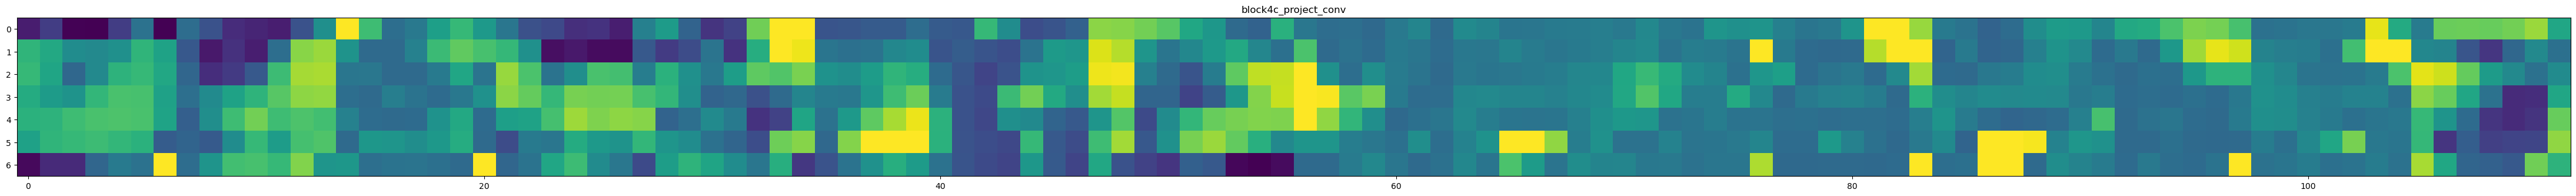

1/1 [==============================] - 0s 109ms/step


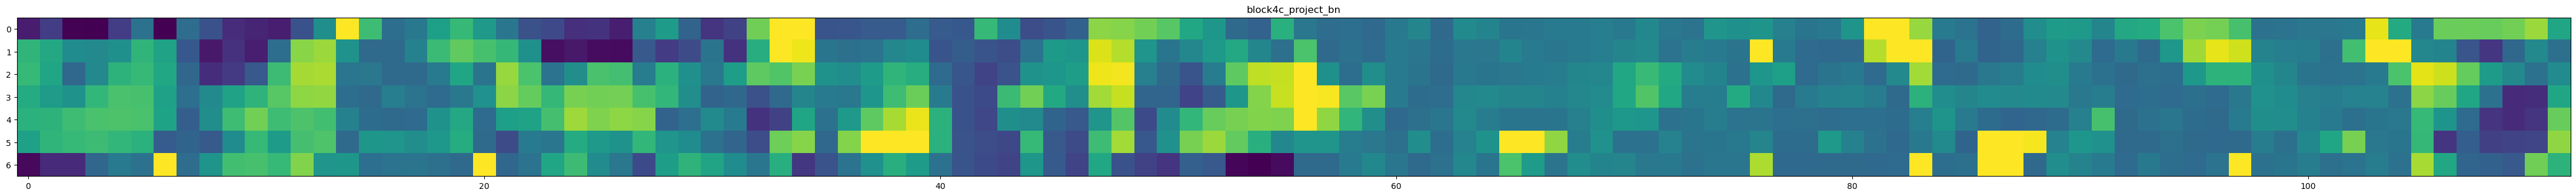

1/1 [==============================] - 0s 119ms/step


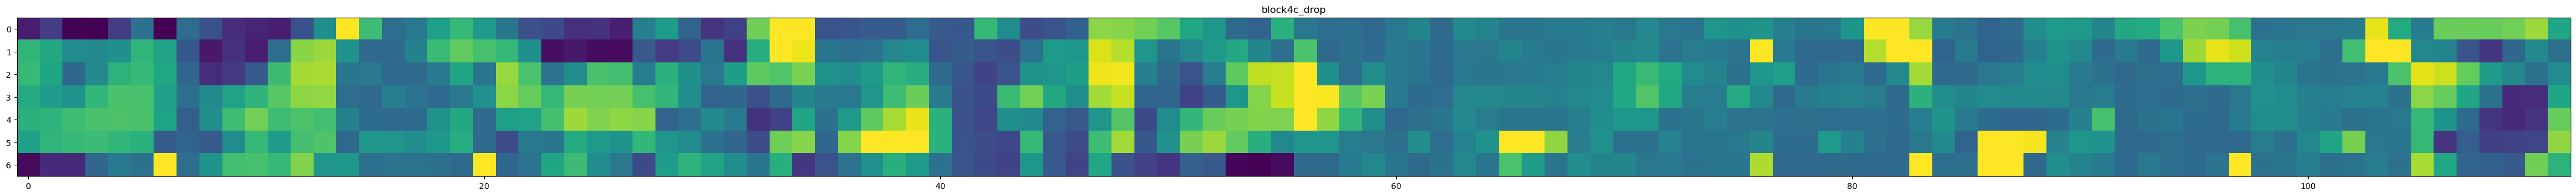

1/1 [==============================] - 0s 117ms/step


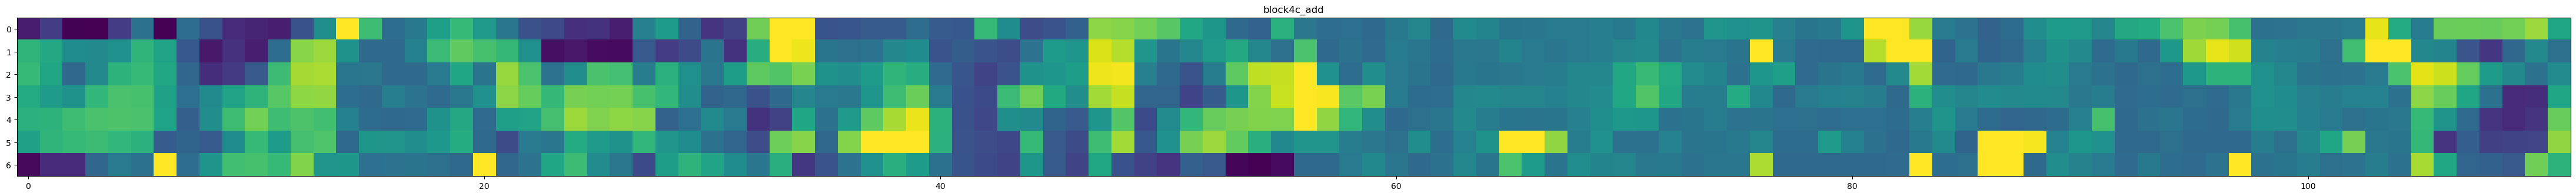

1/1 [==============================] - 0s 111ms/step


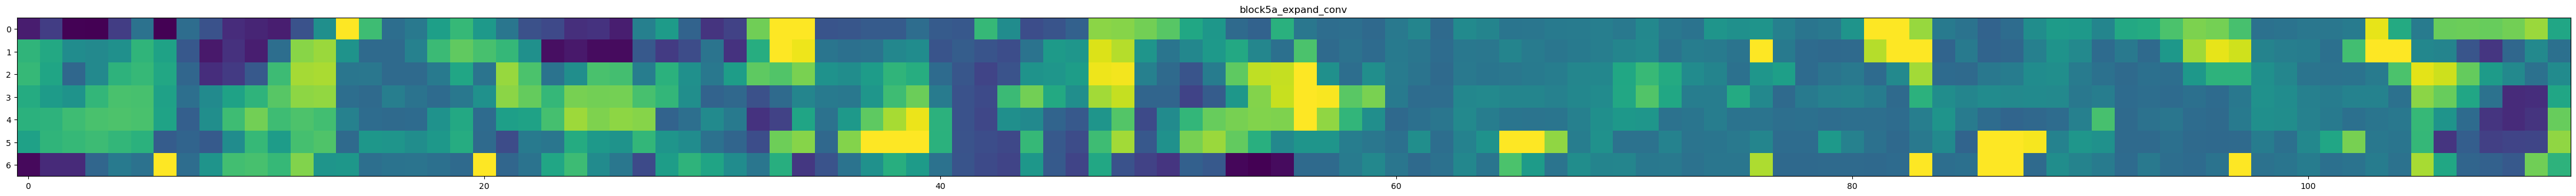

1/1 [==============================] - 0s 117ms/step


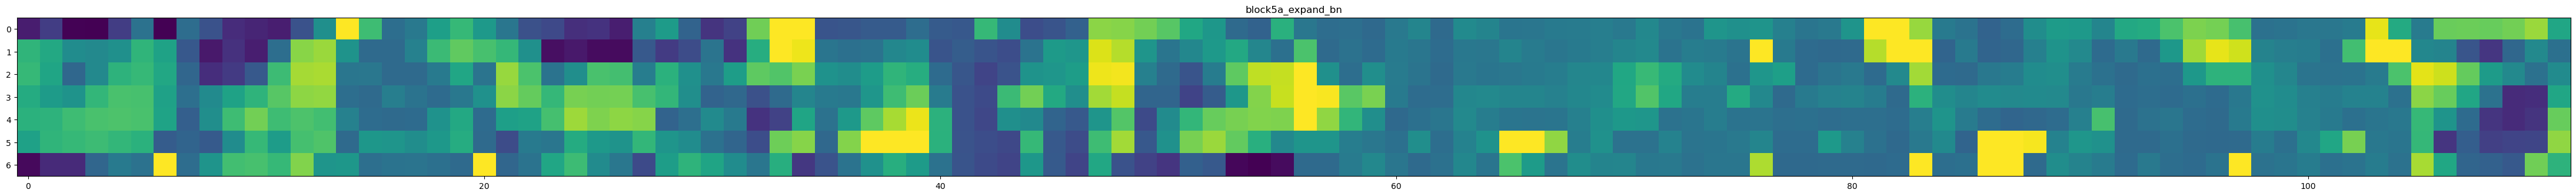

1/1 [==============================] - 0s 121ms/step


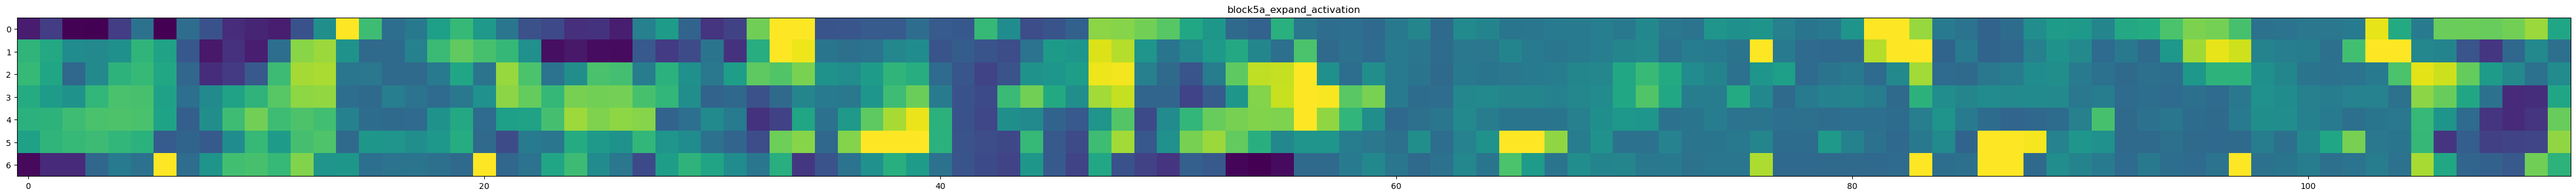

1/1 [==============================] - 0s 122ms/step


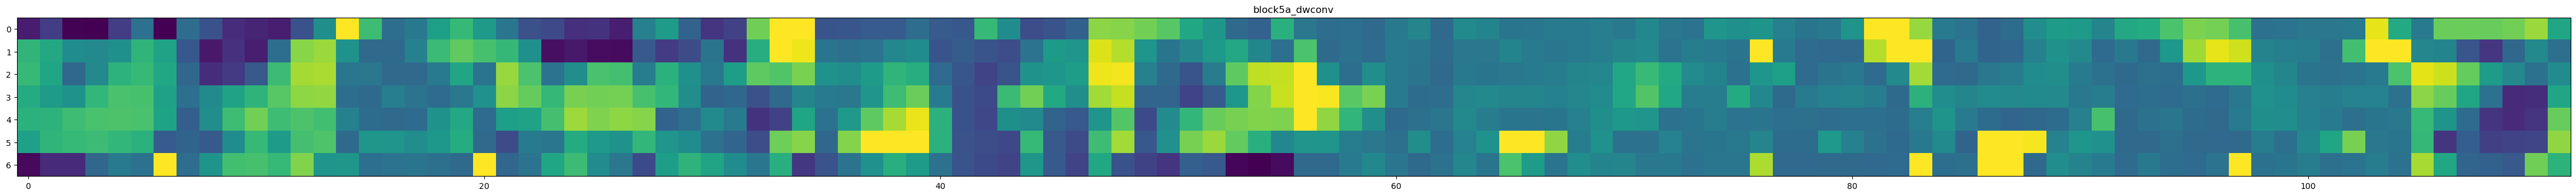

1/1 [==============================] - 0s 132ms/step


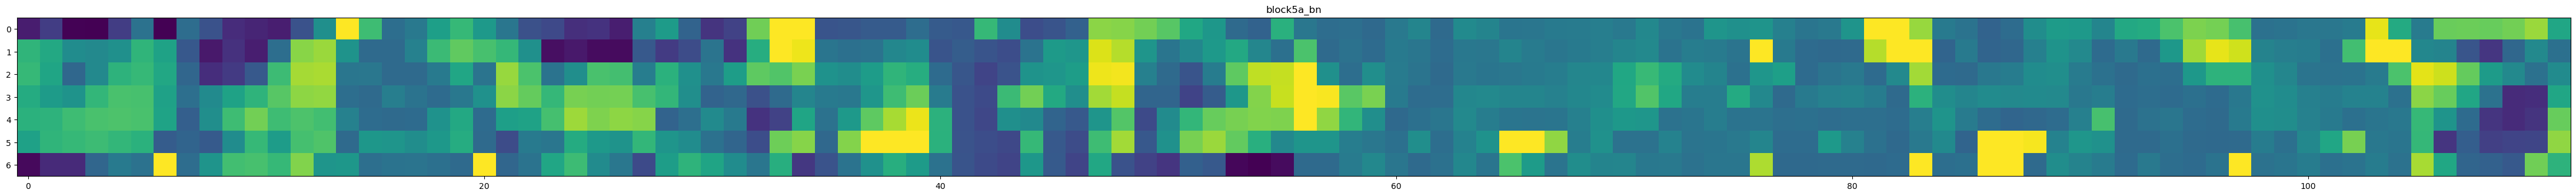

1/1 [==============================] - 0s 117ms/step


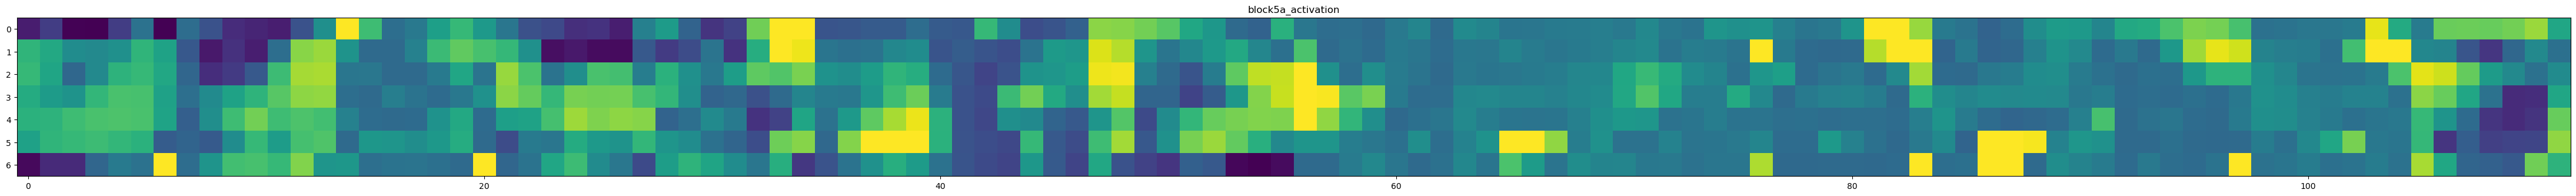

1/1 [==============================] - 0s 118ms/step


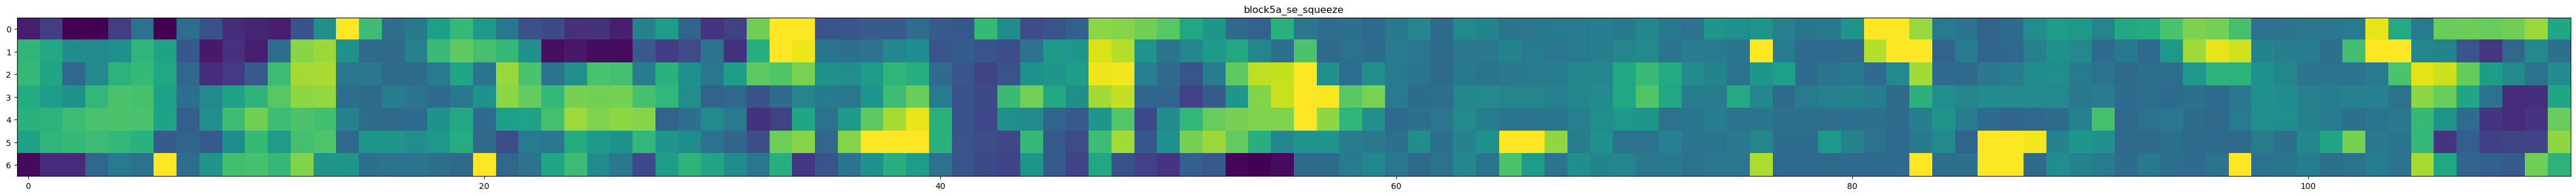

1/1 [==============================] - 0s 126ms/step


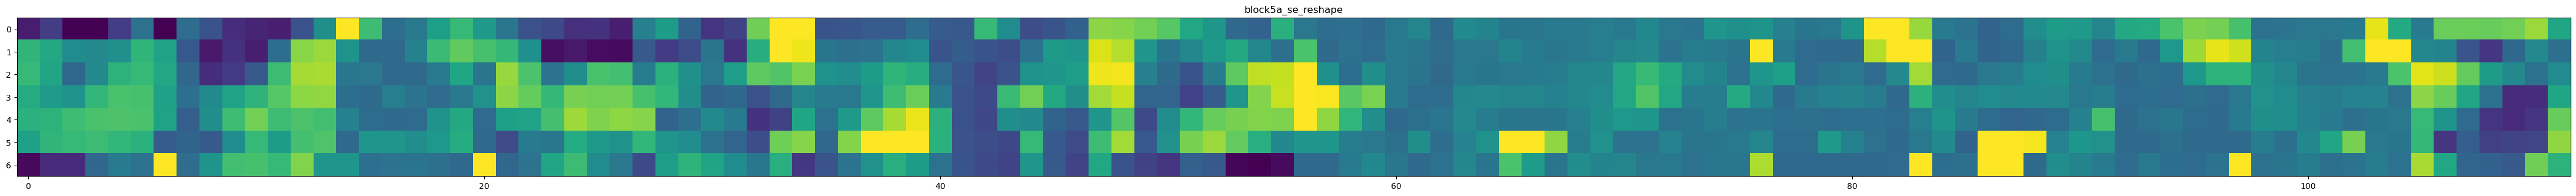

1/1 [==============================] - 0s 120ms/step


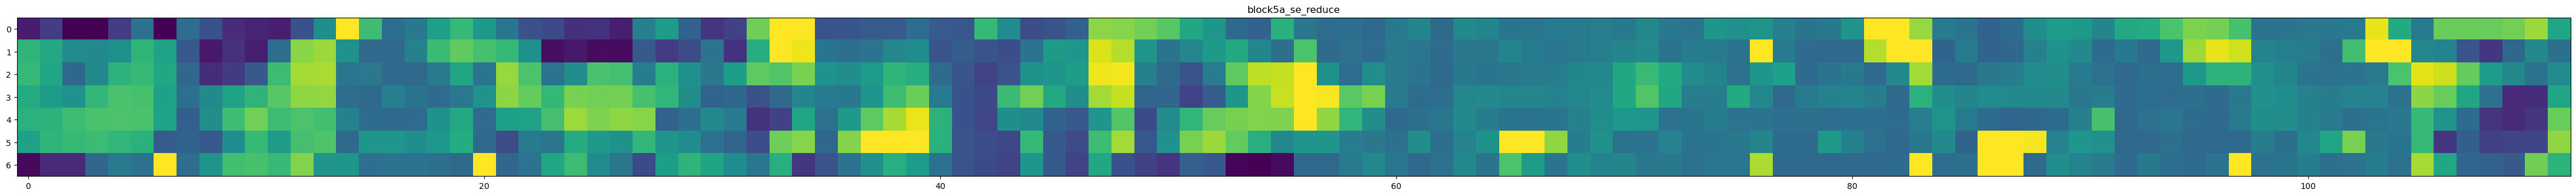

1/1 [==============================] - 0s 126ms/step


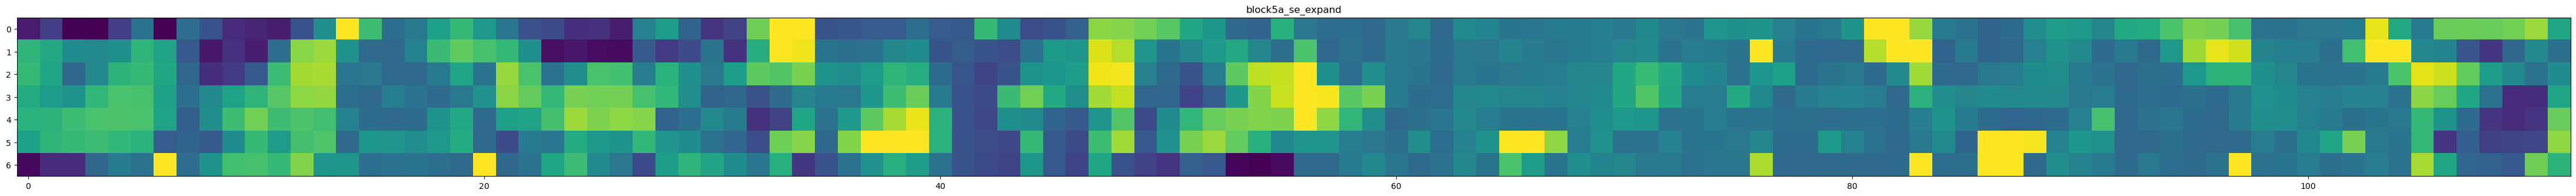

1/1 [==============================] - 0s 110ms/step


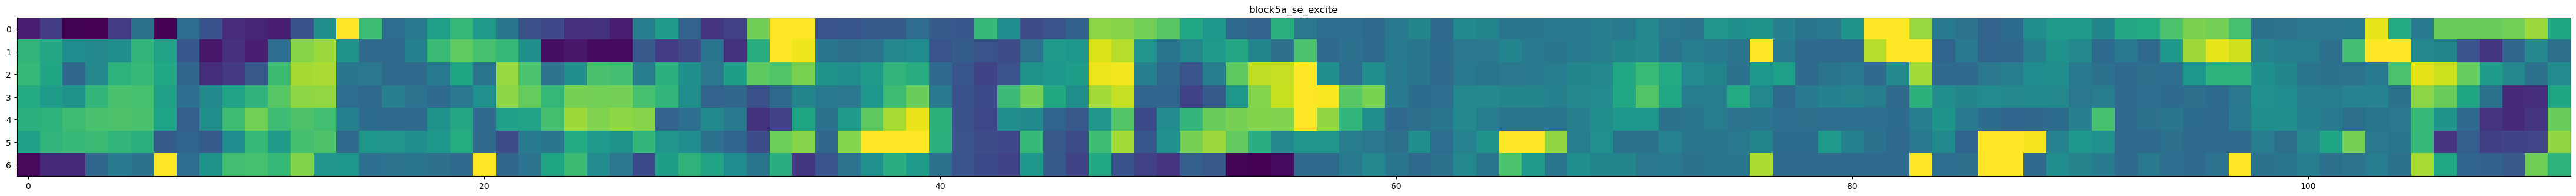

1/1 [==============================] - 0s 126ms/step


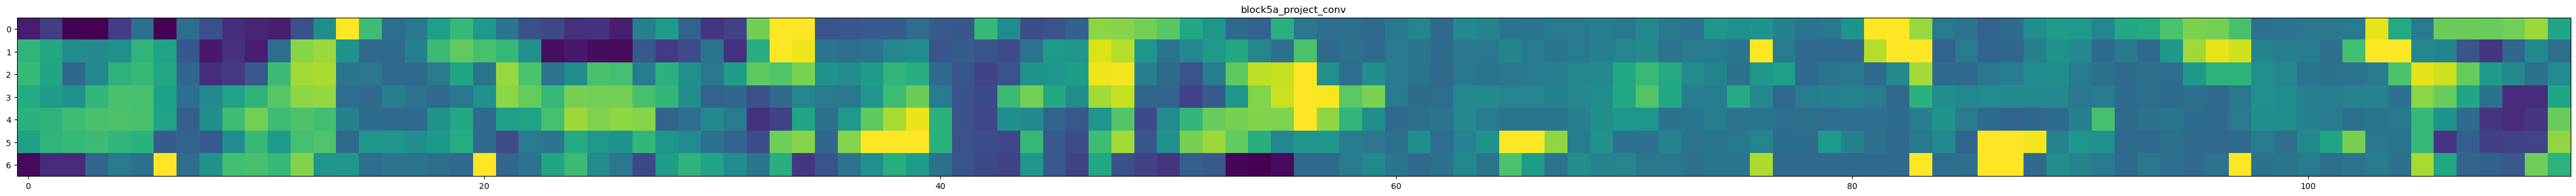

1/1 [==============================] - 0s 120ms/step


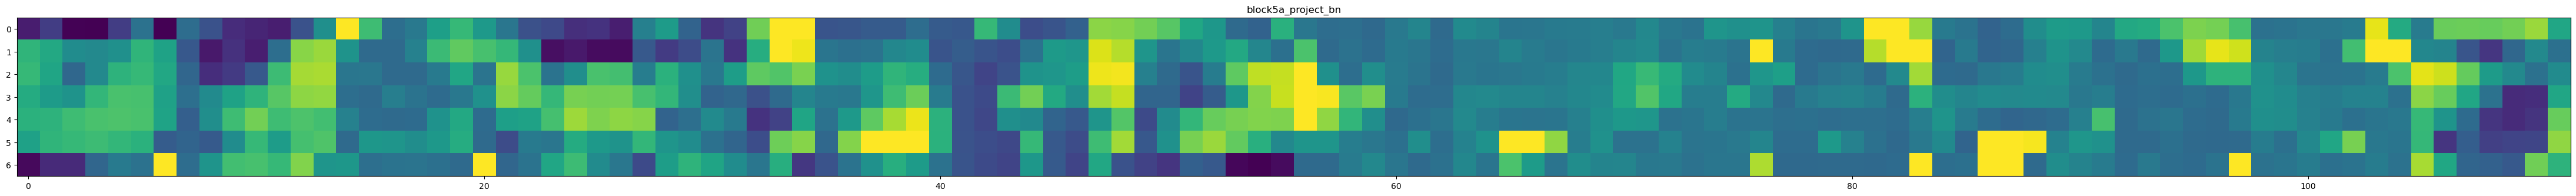

1/1 [==============================] - 0s 114ms/step


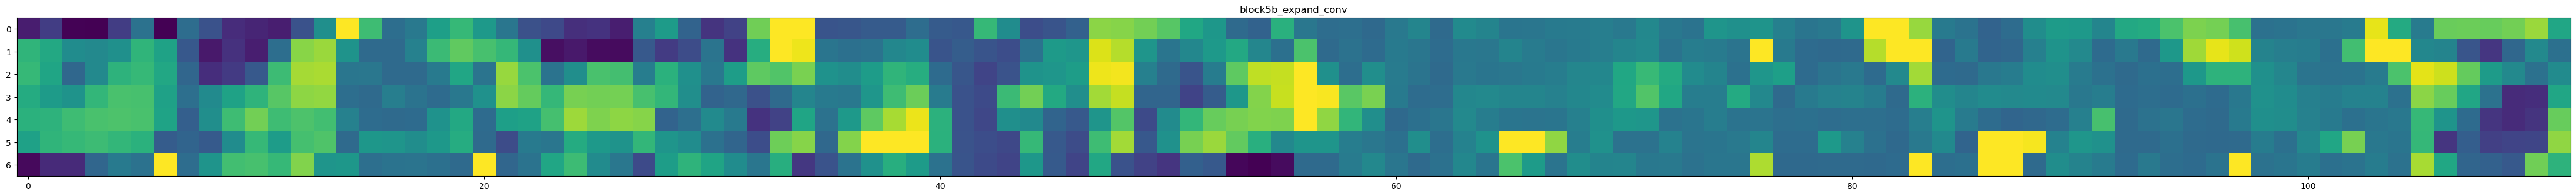

1/1 [==============================] - 0s 116ms/step


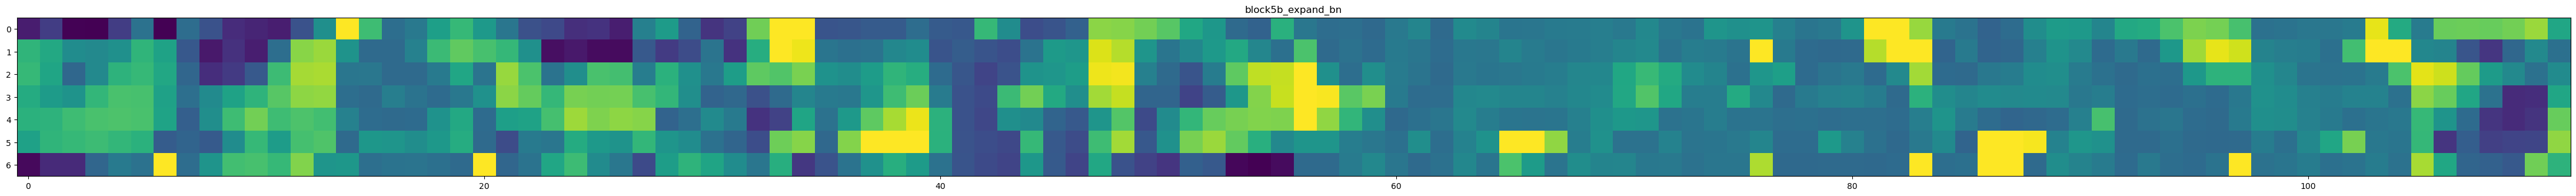

1/1 [==============================] - 0s 125ms/step


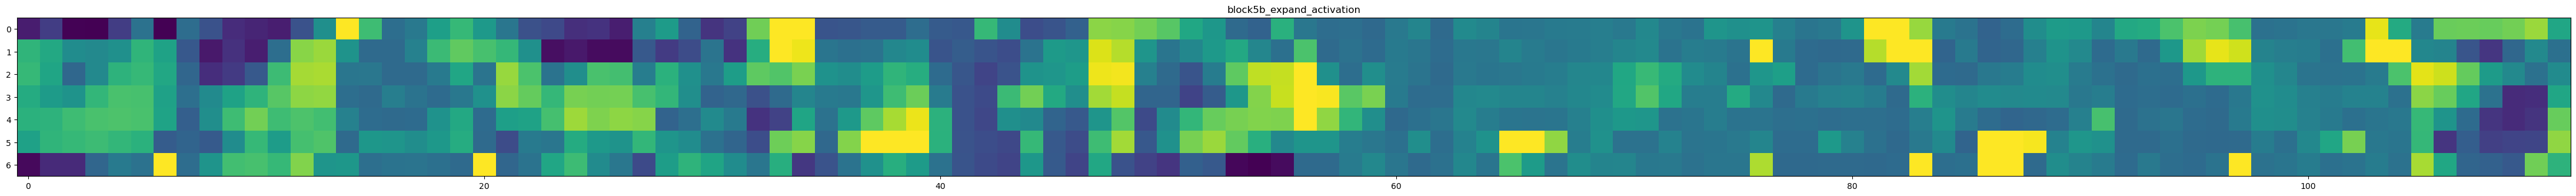

1/1 [==============================] - 0s 110ms/step


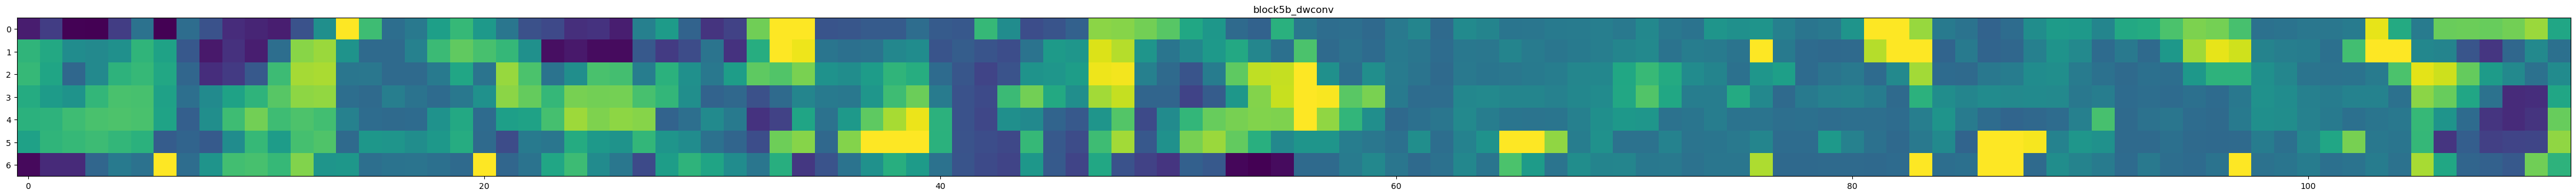

1/1 [==============================] - 0s 123ms/step


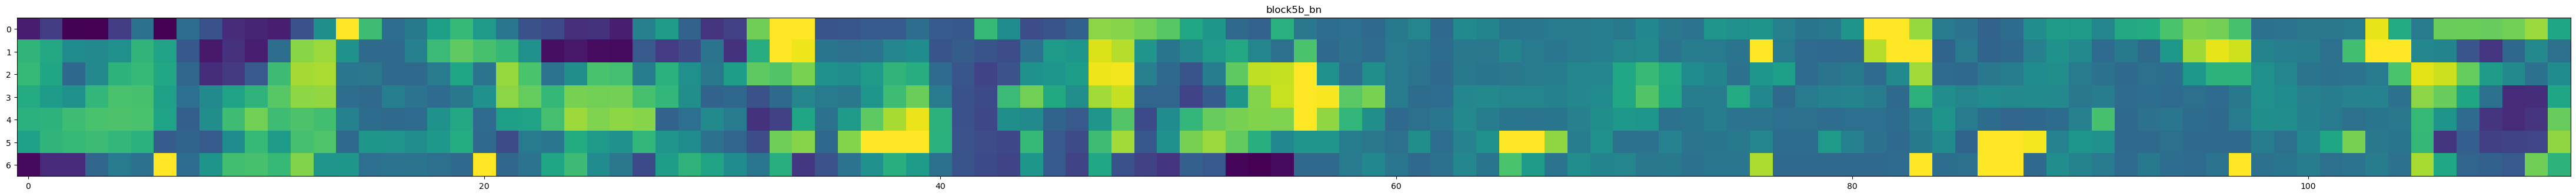

1/1 [==============================] - 0s 122ms/step


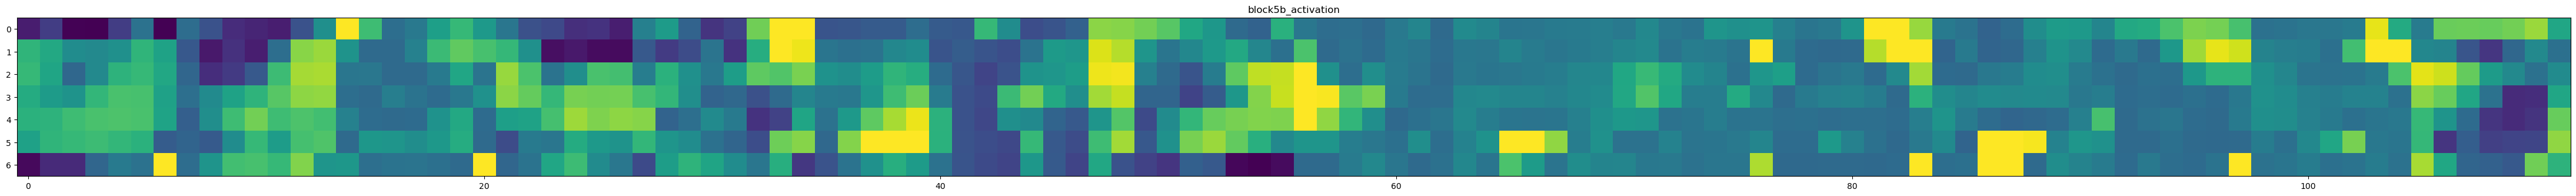

1/1 [==============================] - 0s 115ms/step


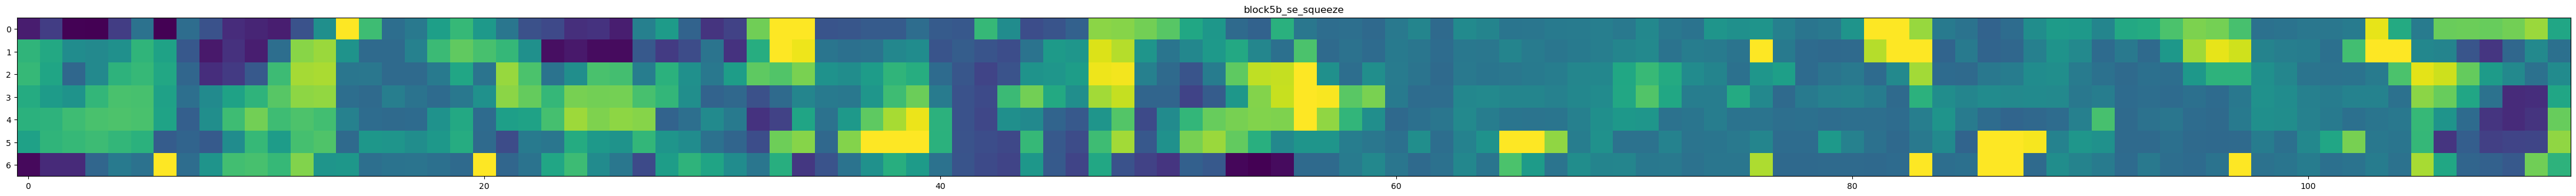

1/1 [==============================] - 0s 125ms/step


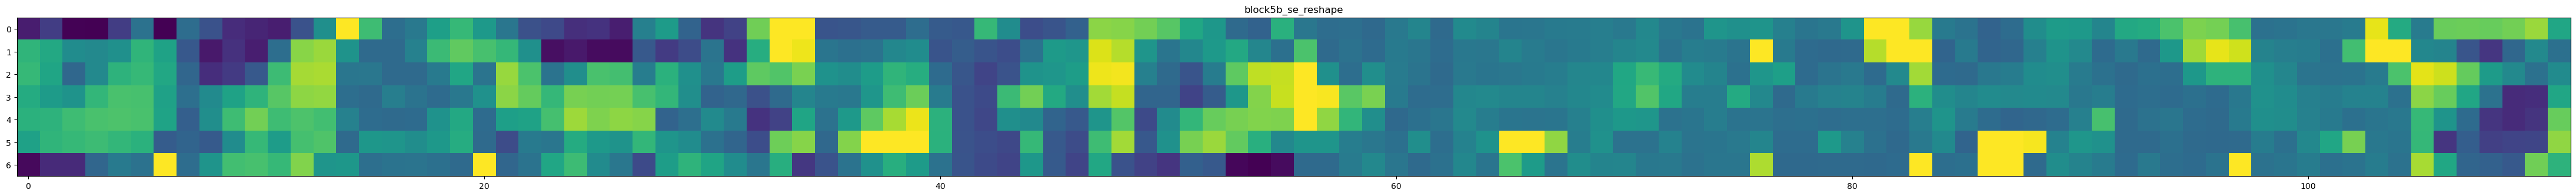

1/1 [==============================] - 0s 118ms/step


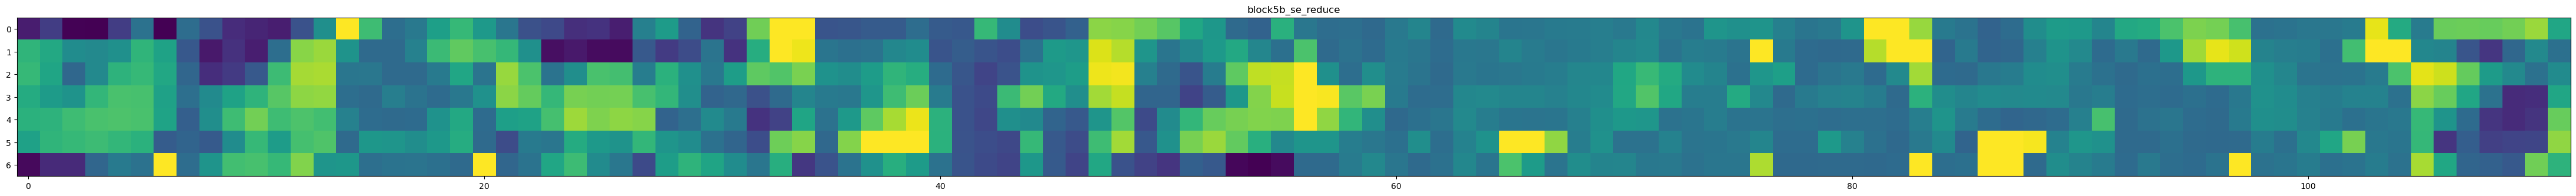

1/1 [==============================] - 0s 110ms/step


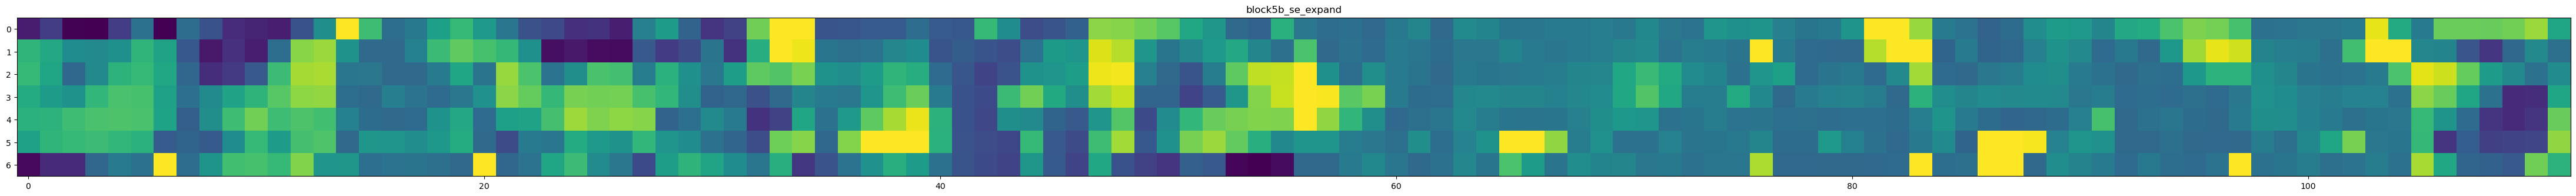

1/1 [==============================] - 0s 121ms/step


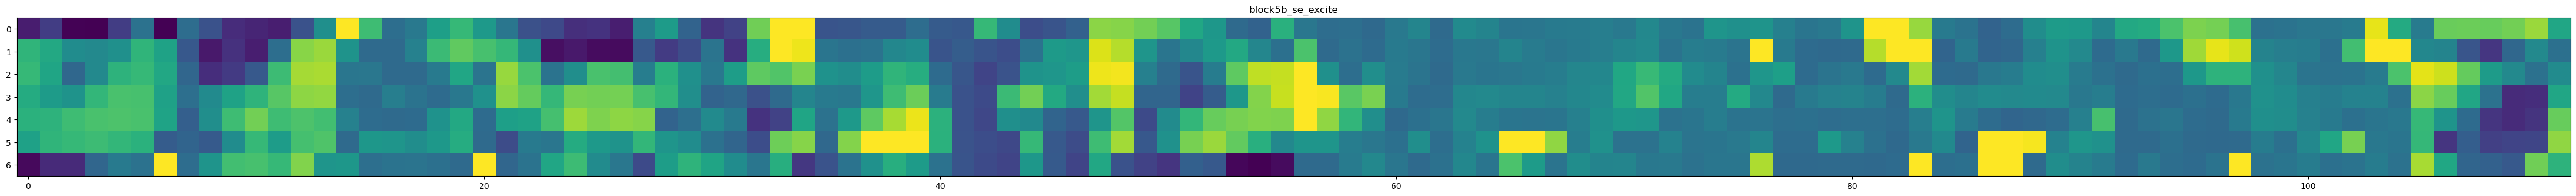

1/1 [==============================] - 0s 111ms/step


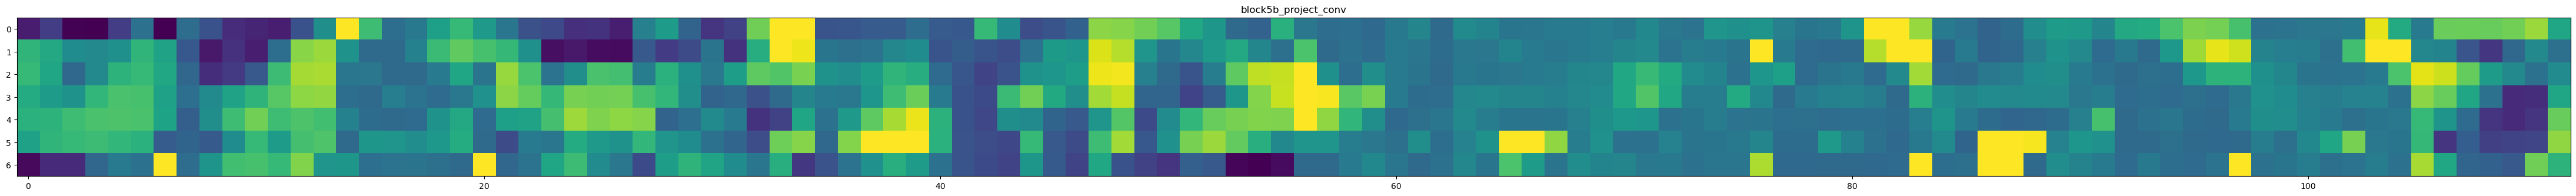

1/1 [==============================] - 0s 126ms/step


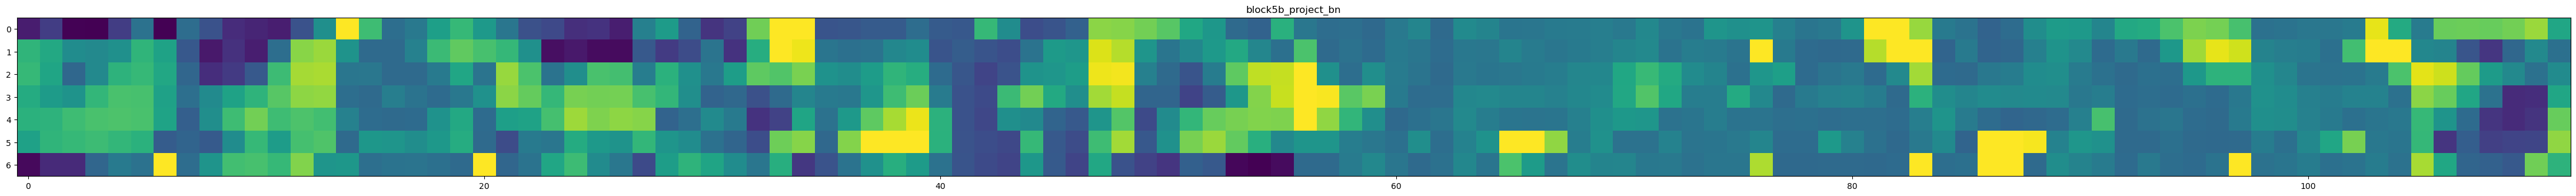

1/1 [==============================] - 0s 119ms/step


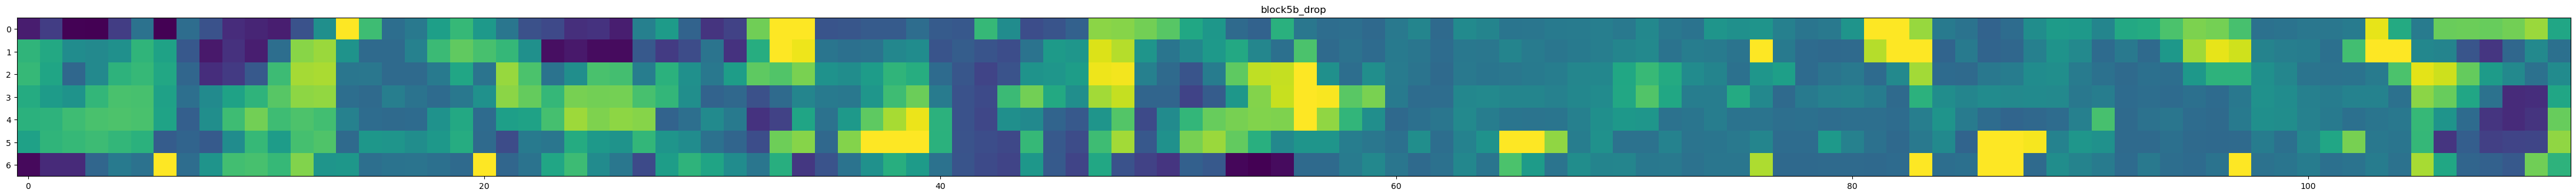

1/1 [==============================] - 0s 123ms/step


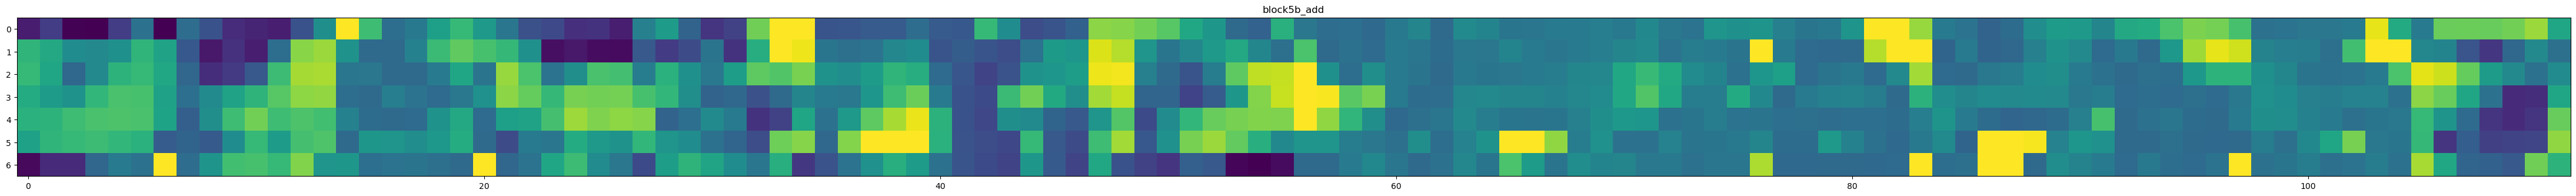

1/1 [==============================] - 0s 113ms/step


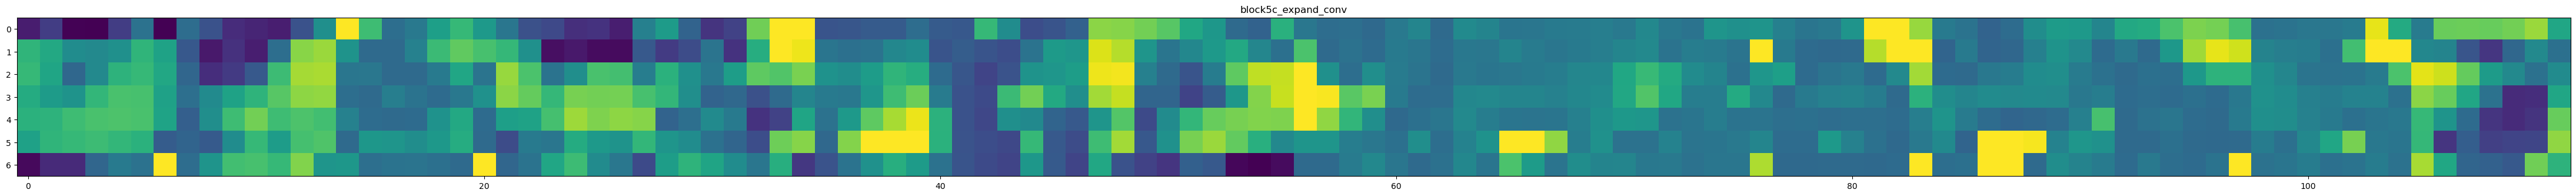

1/1 [==============================] - 0s 110ms/step


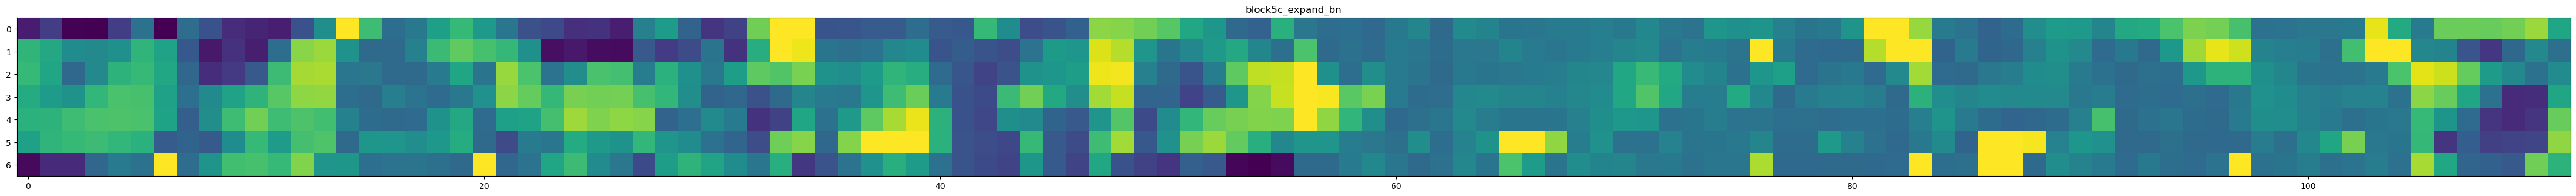

1/1 [==============================] - 0s 114ms/step


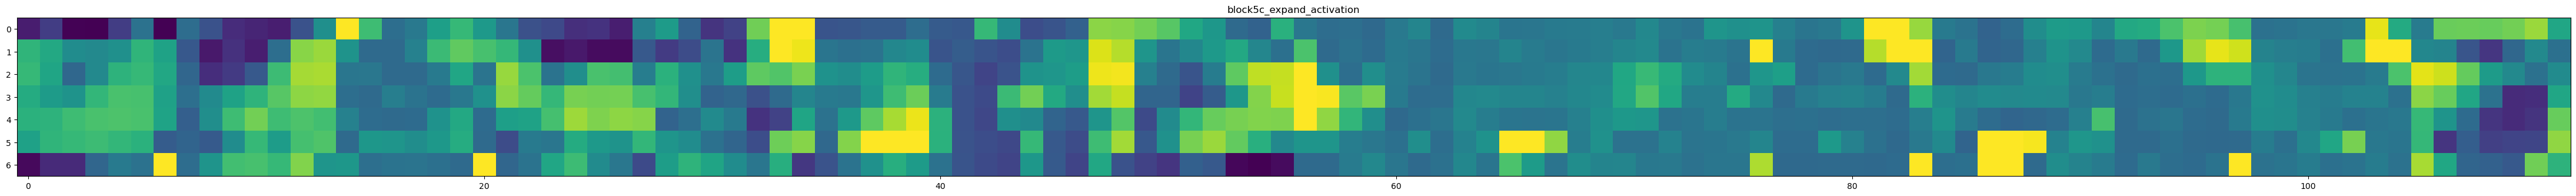

1/1 [==============================] - 0s 119ms/step


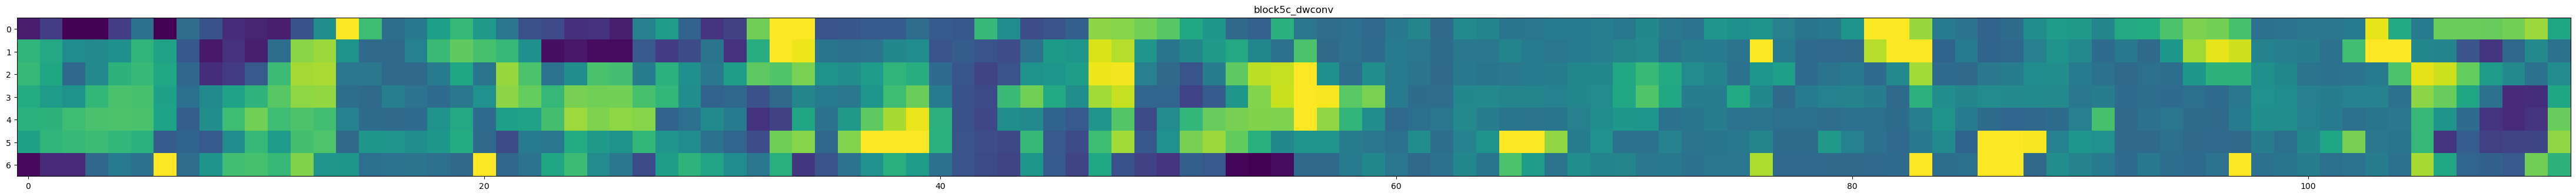

1/1 [==============================] - 0s 148ms/step


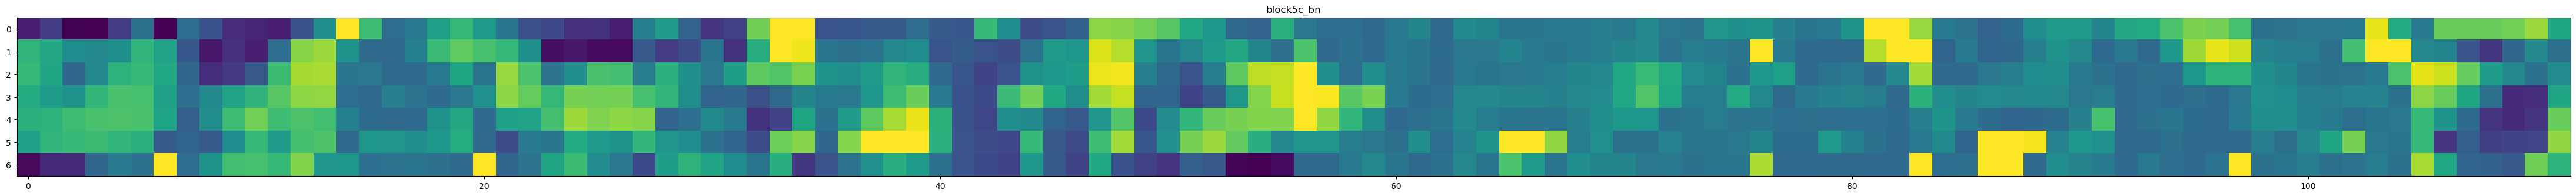

1/1 [==============================] - 0s 127ms/step


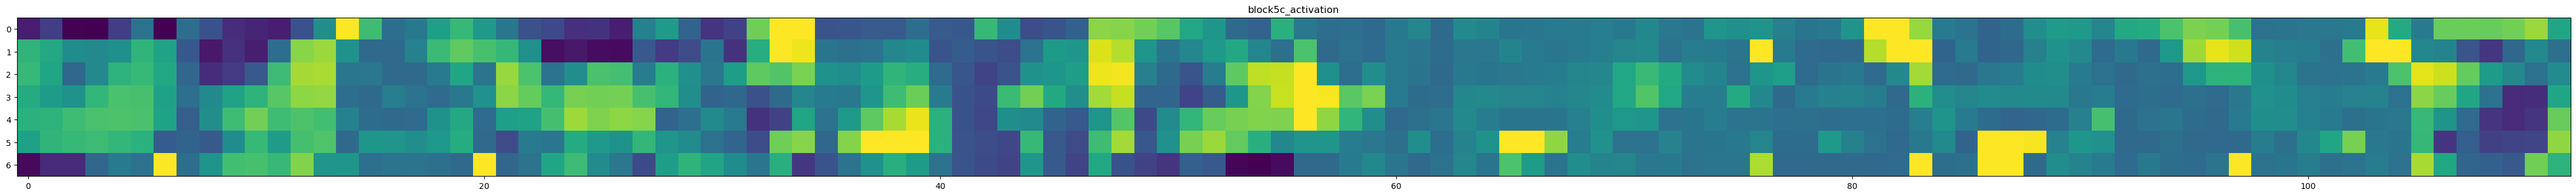

1/1 [==============================] - 0s 128ms/step


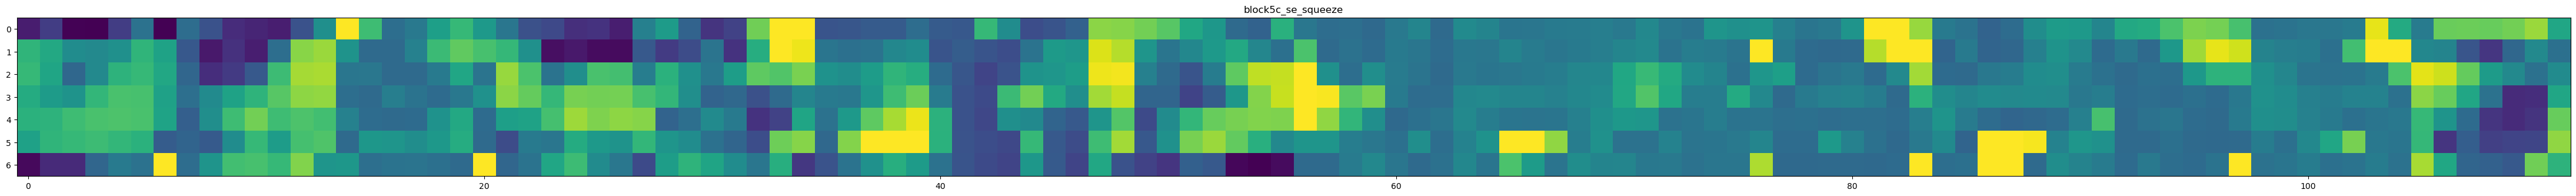

1/1 [==============================] - 0s 127ms/step


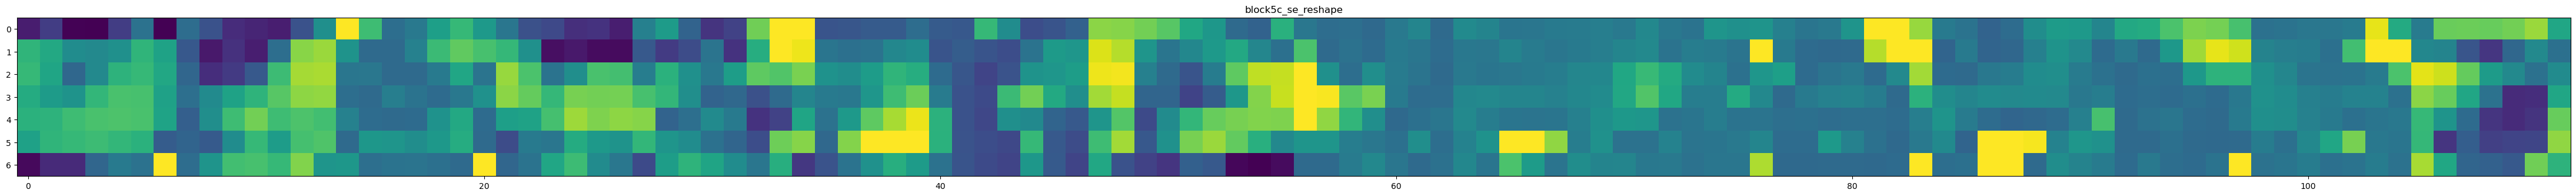

1/1 [==============================] - 0s 113ms/step


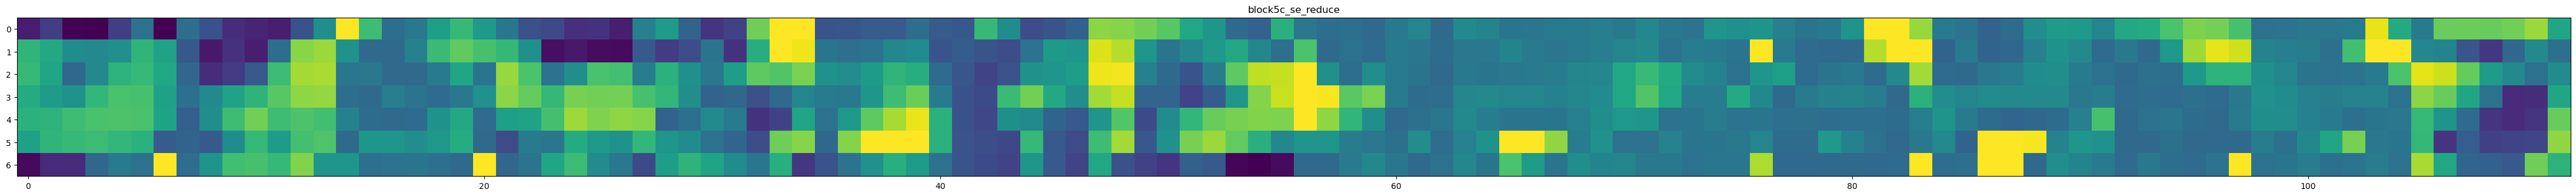

1/1 [==============================] - 0s 114ms/step


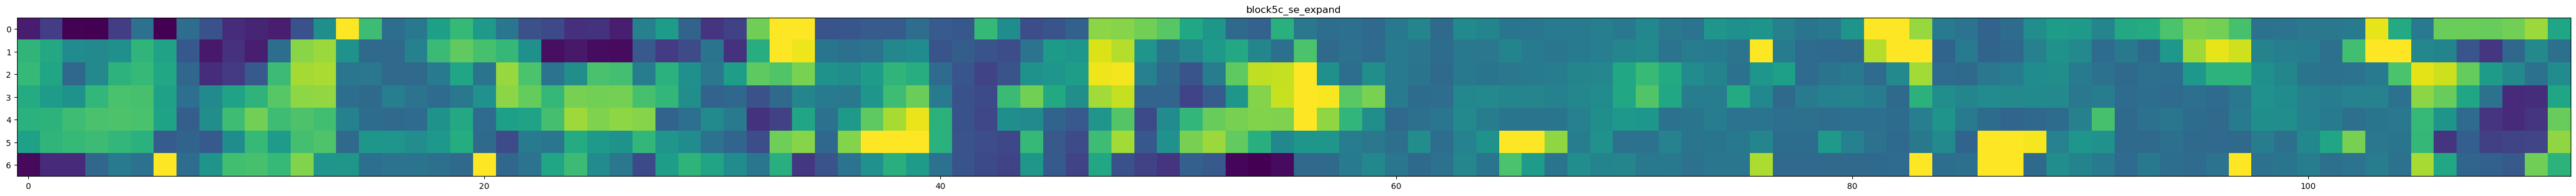

1/1 [==============================] - 0s 114ms/step


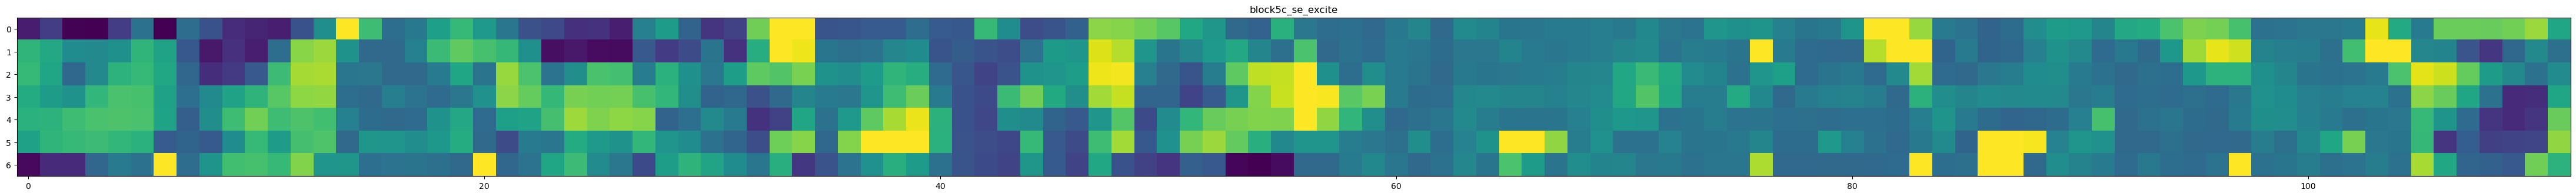

1/1 [==============================] - 0s 110ms/step


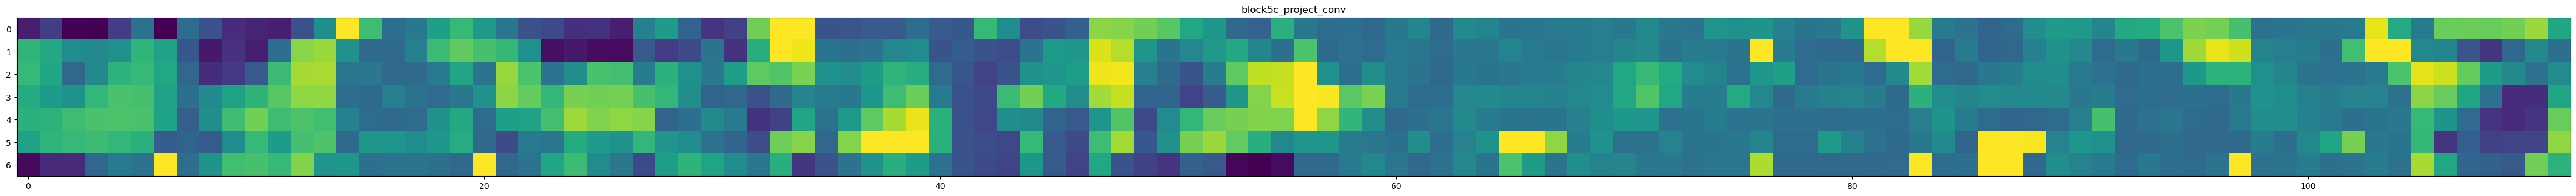

1/1 [==============================] - 0s 164ms/step


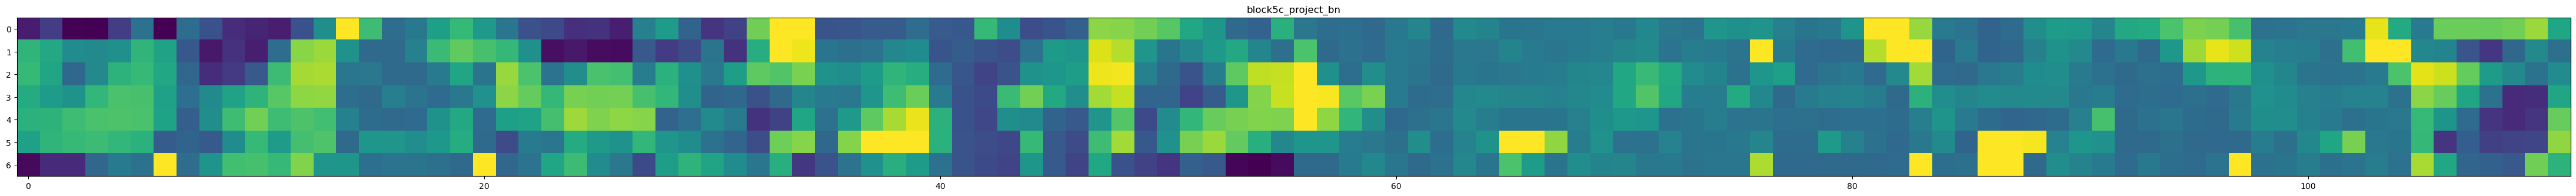

1/1 [==============================] - 0s 120ms/step


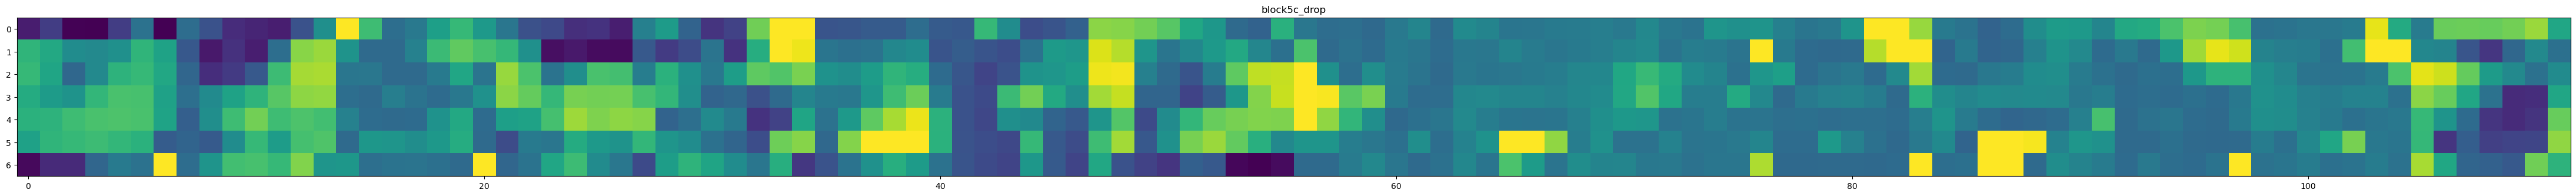

1/1 [==============================] - 0s 124ms/step


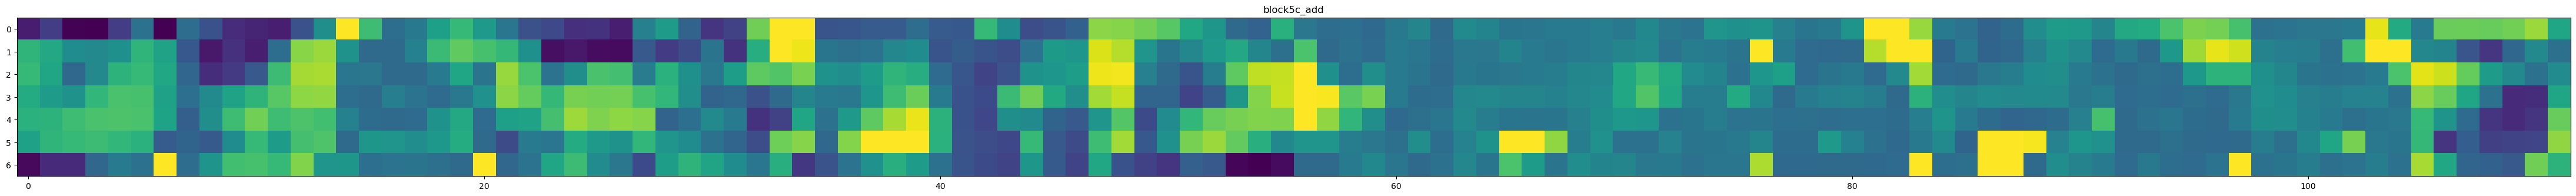

1/1 [==============================] - 0s 126ms/step


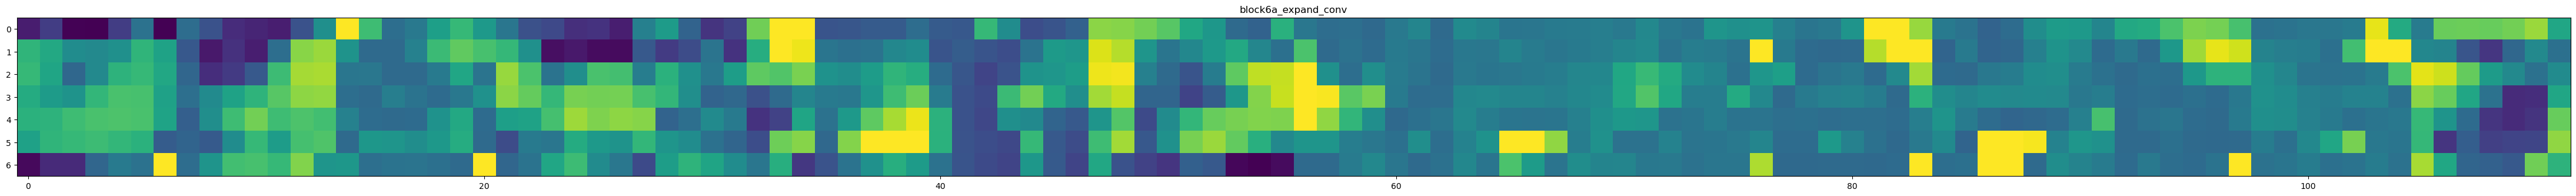

1/1 [==============================] - 0s 119ms/step


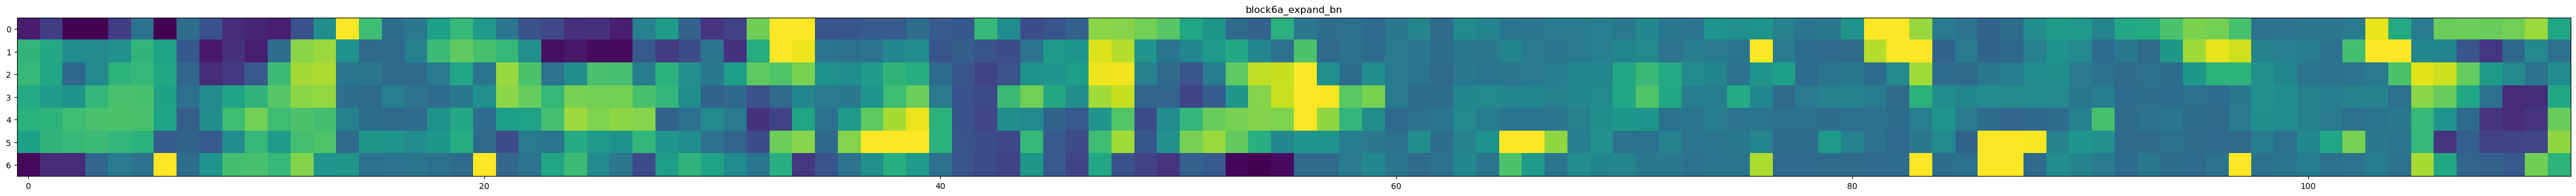

1/1 [==============================] - 0s 118ms/step


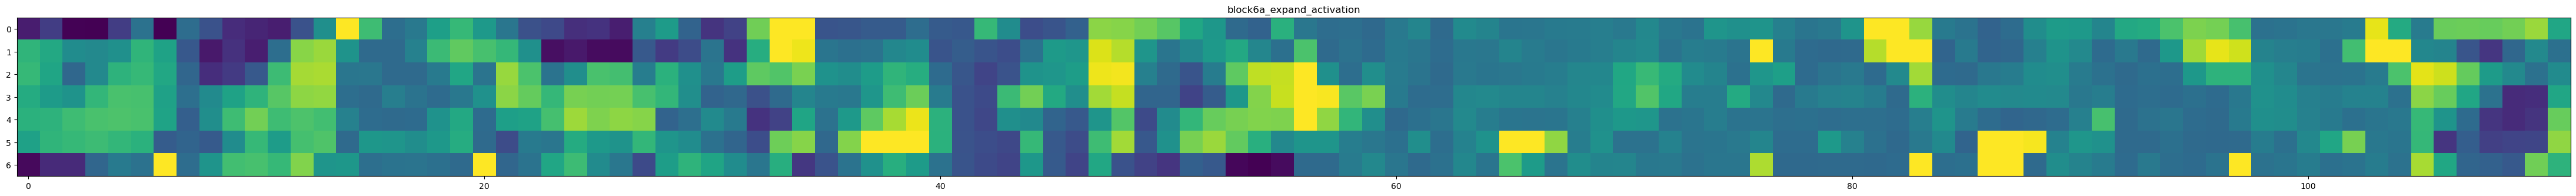

1/1 [==============================] - 0s 110ms/step


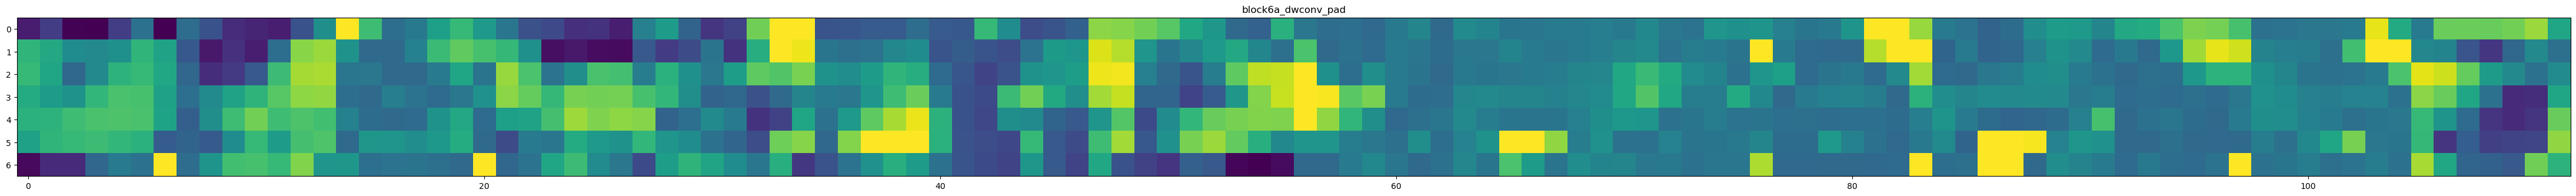

1/1 [==============================] - 0s 125ms/step


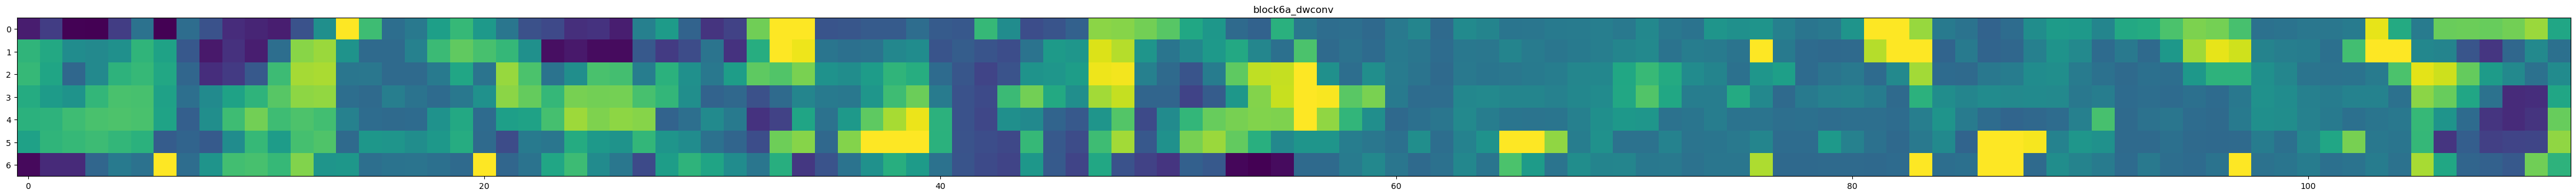

1/1 [==============================] - 0s 125ms/step


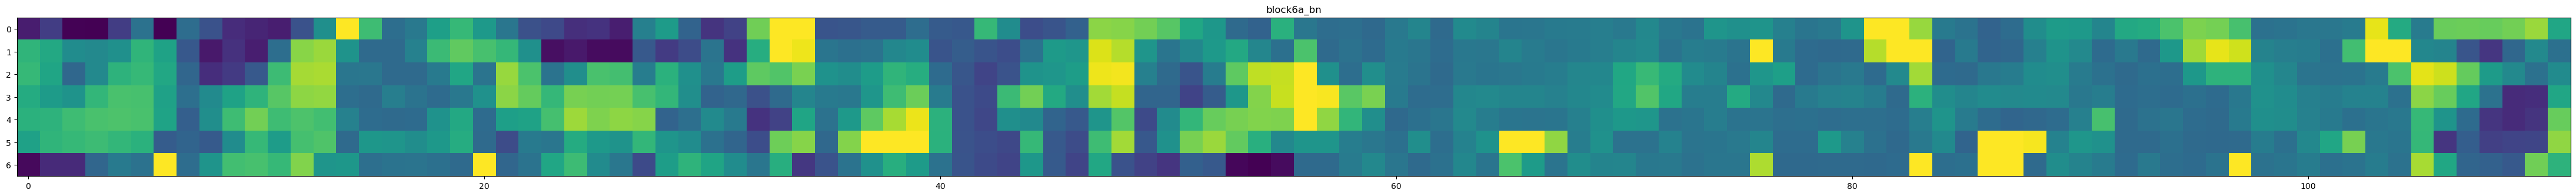

1/1 [==============================] - 0s 113ms/step


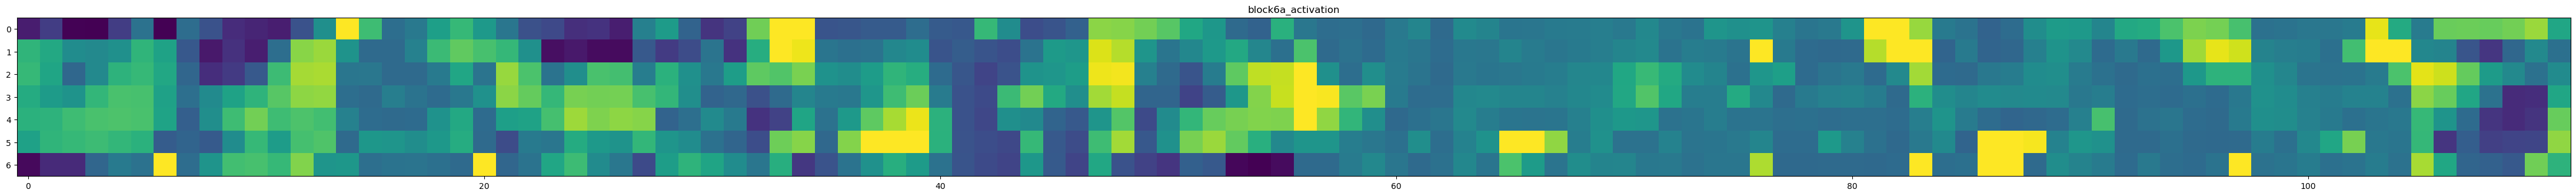

1/1 [==============================] - 0s 123ms/step


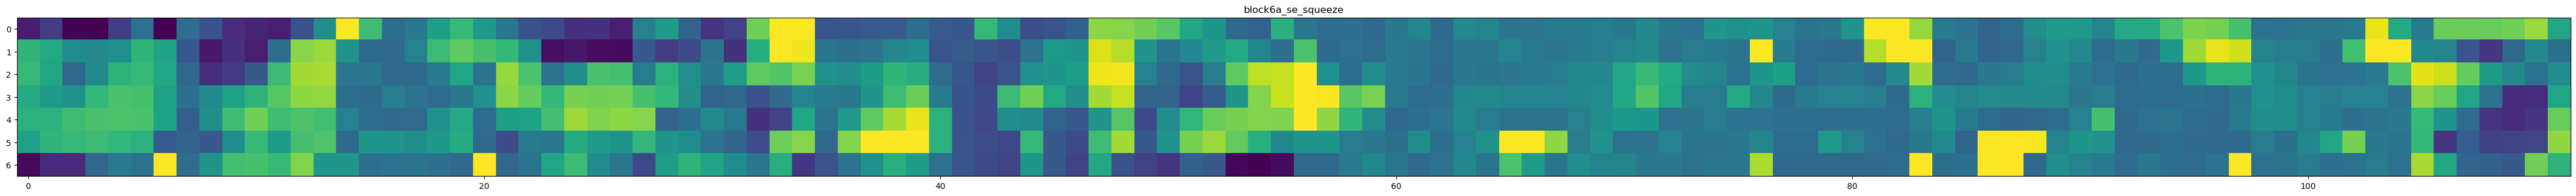

1/1 [==============================] - 0s 131ms/step


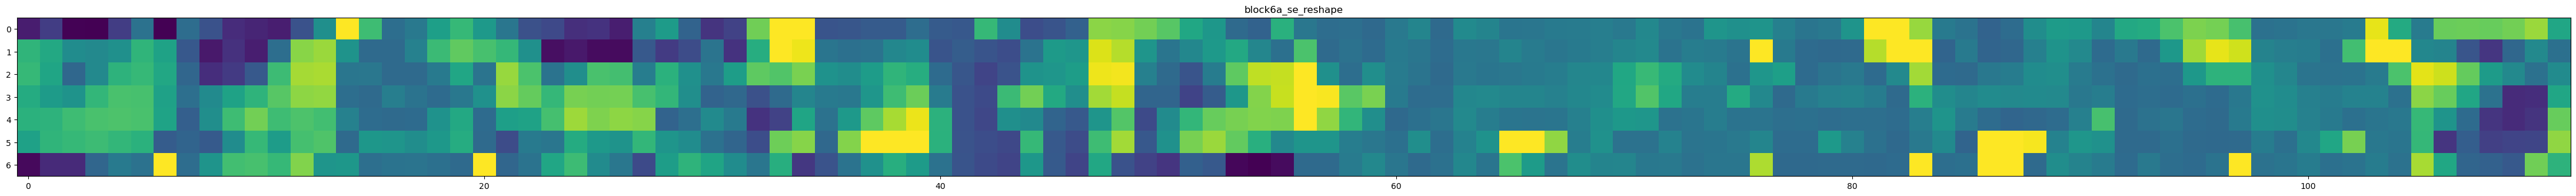

1/1 [==============================] - 0s 126ms/step


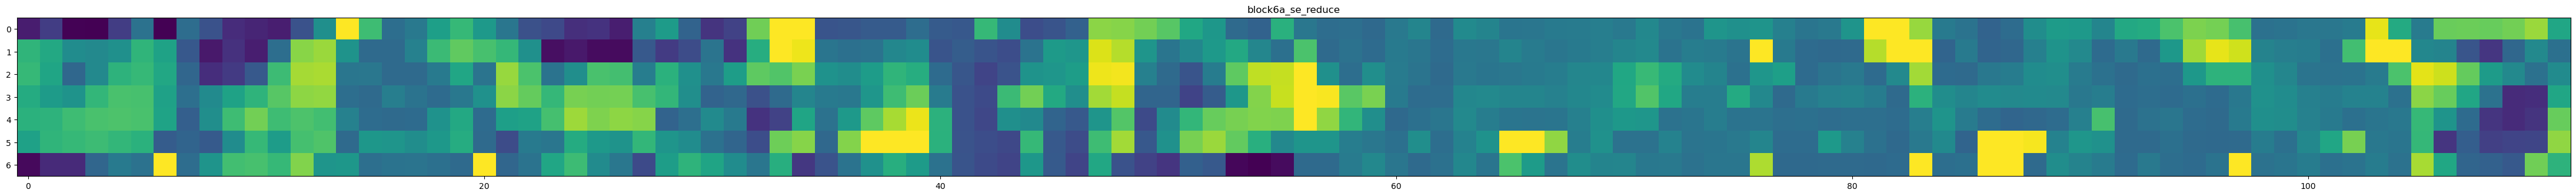

1/1 [==============================] - 0s 119ms/step


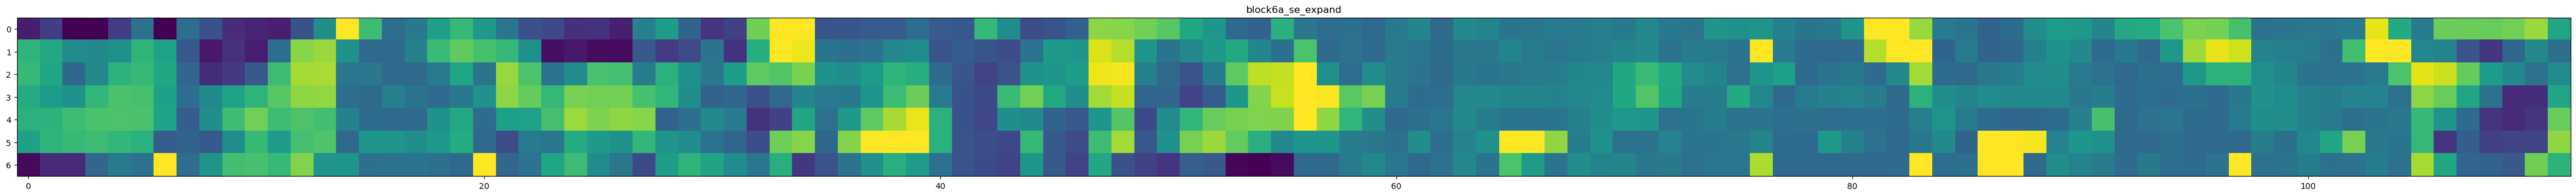

1/1 [==============================] - 0s 122ms/step


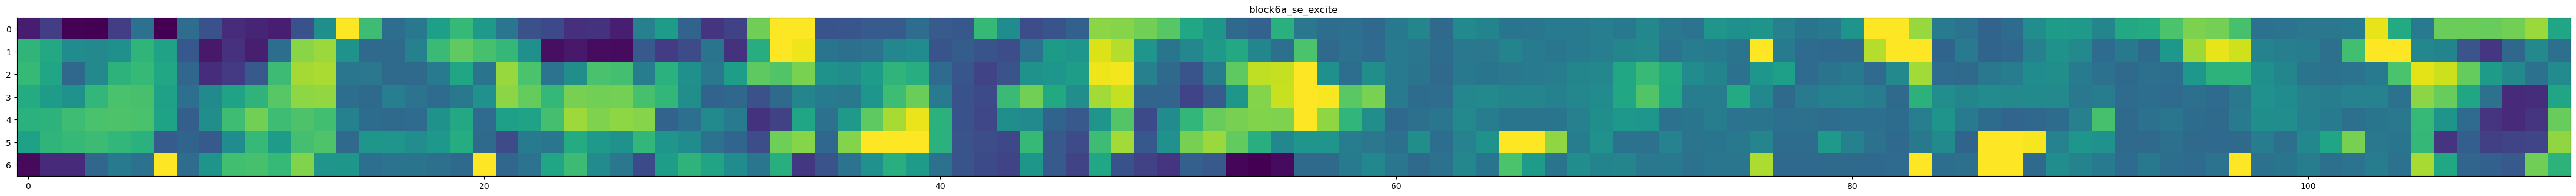

1/1 [==============================] - 0s 106ms/step


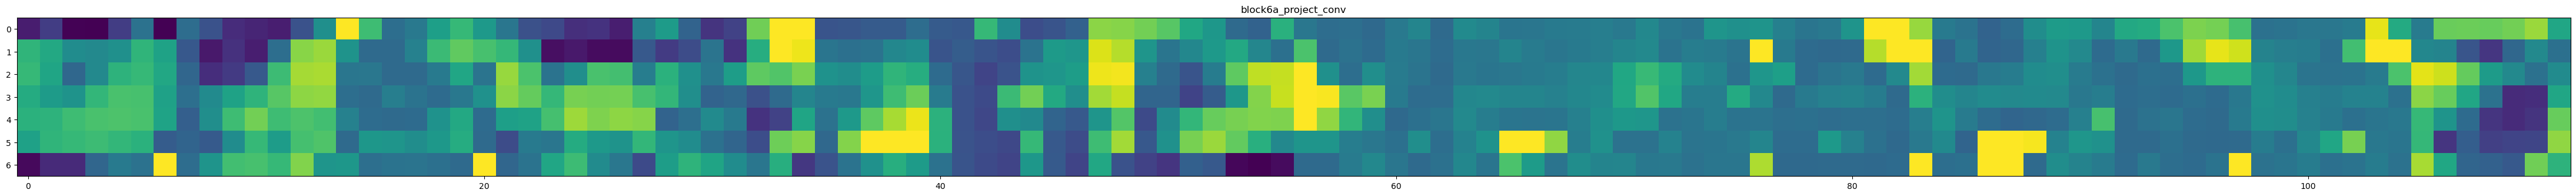

1/1 [==============================] - 0s 117ms/step


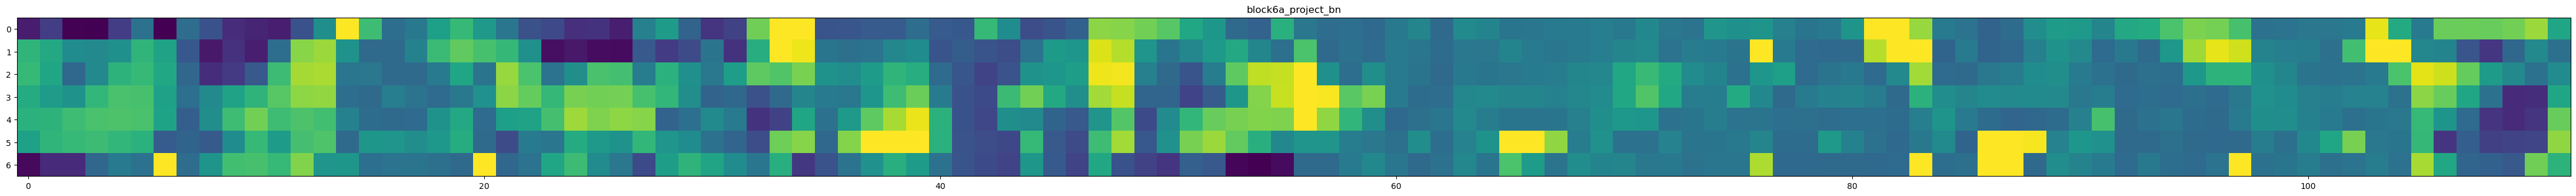

1/1 [==============================] - 0s 107ms/step


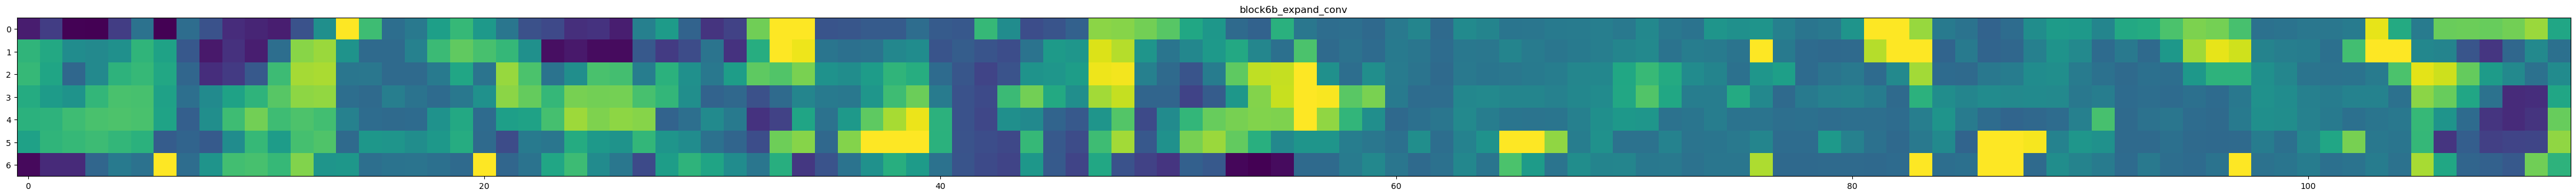

1/1 [==============================] - 0s 126ms/step


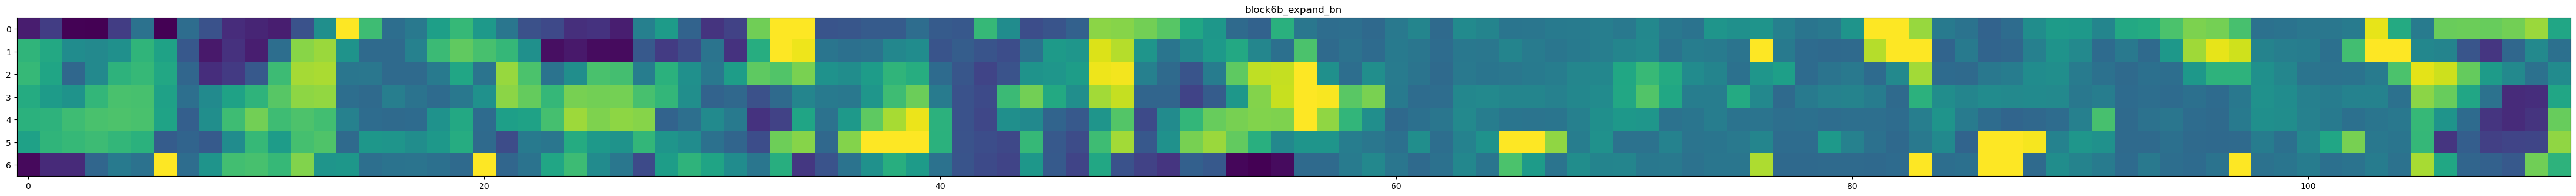

1/1 [==============================] - 0s 110ms/step


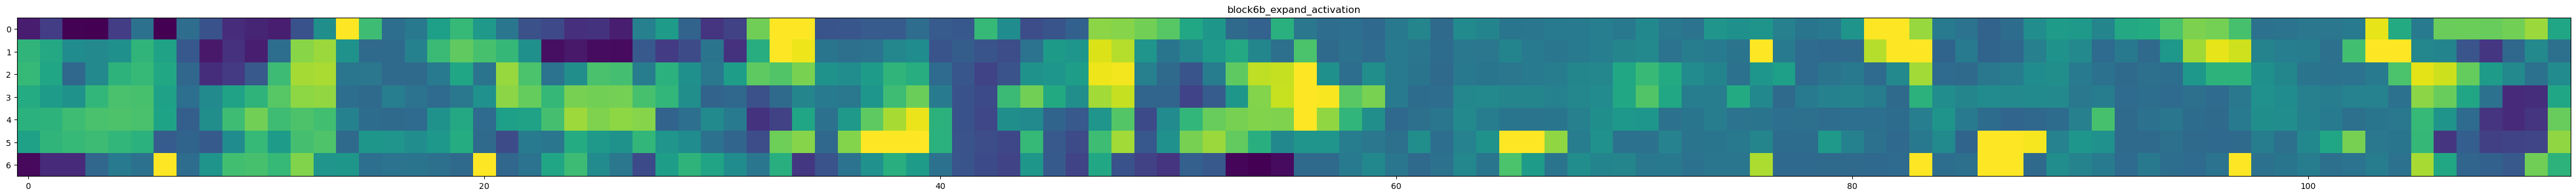

1/1 [==============================] - 0s 122ms/step


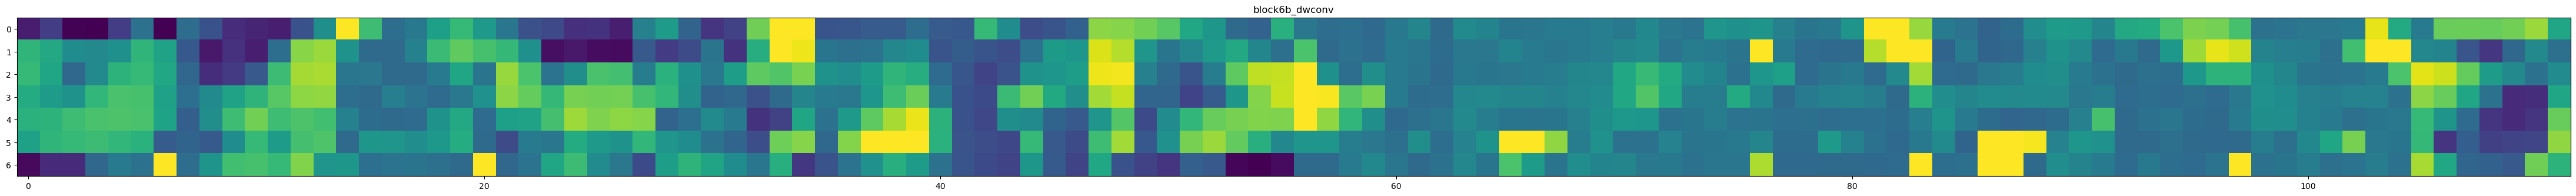

1/1 [==============================] - 0s 127ms/step


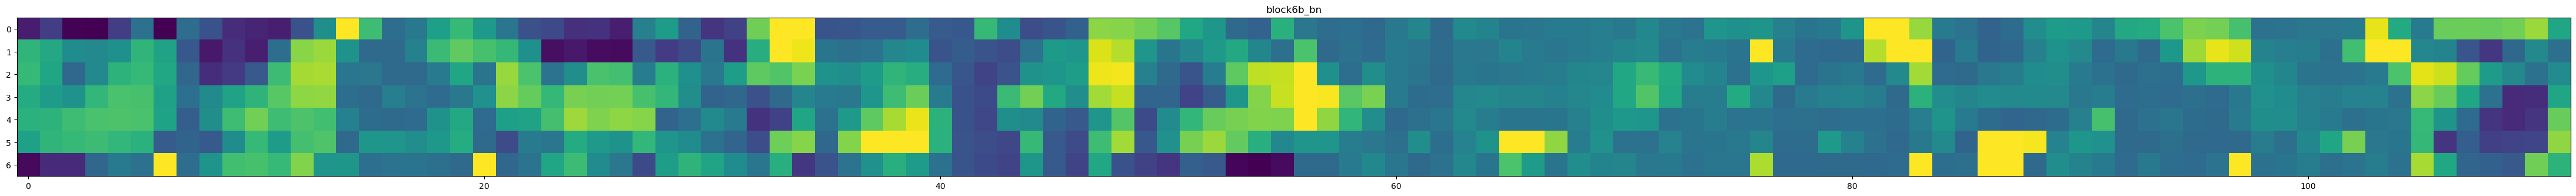

1/1 [==============================] - 0s 117ms/step


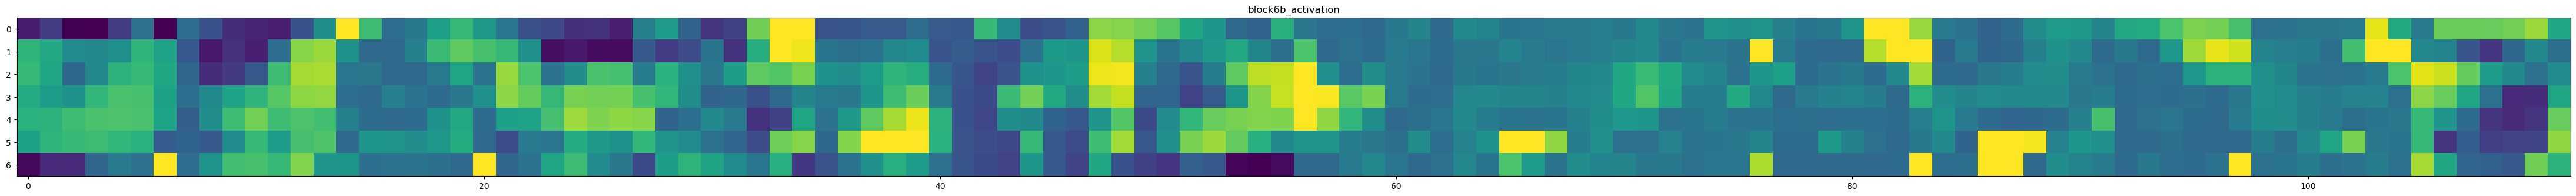

1/1 [==============================] - 0s 120ms/step


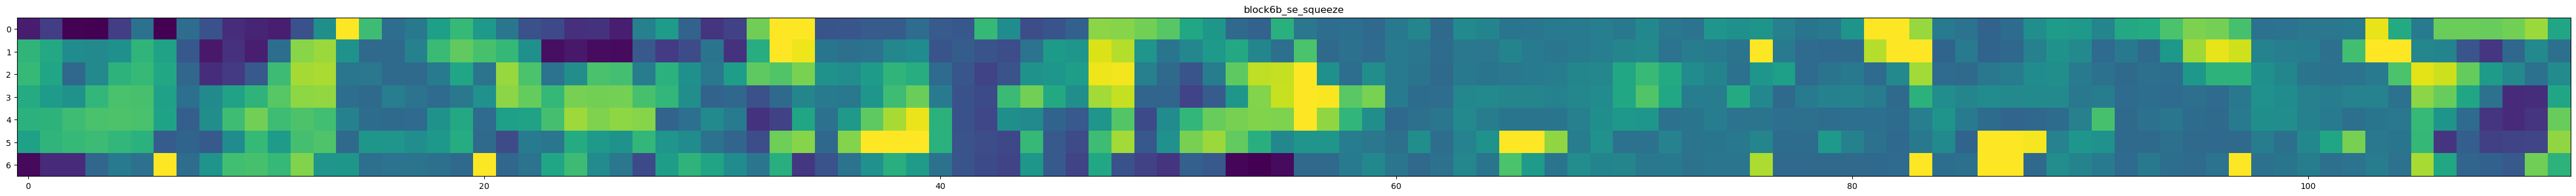

1/1 [==============================] - 0s 110ms/step


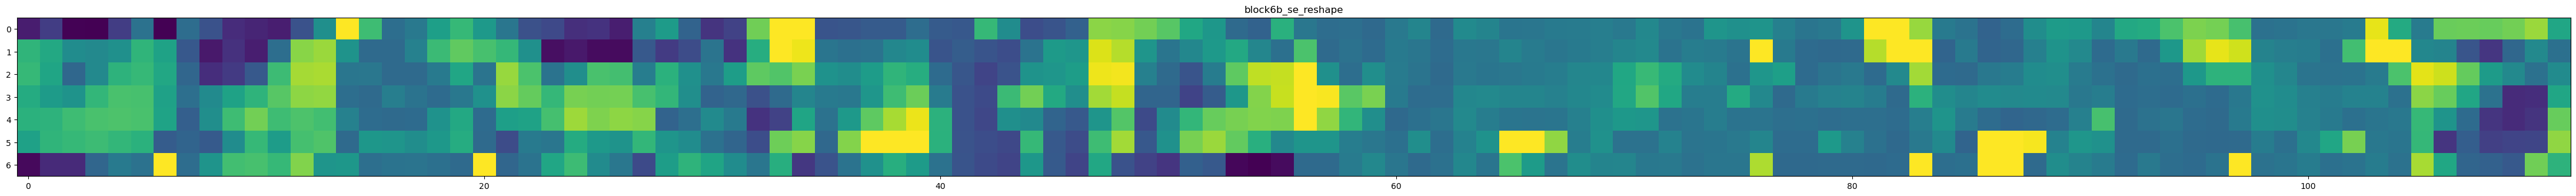

1/1 [==============================] - 0s 124ms/step


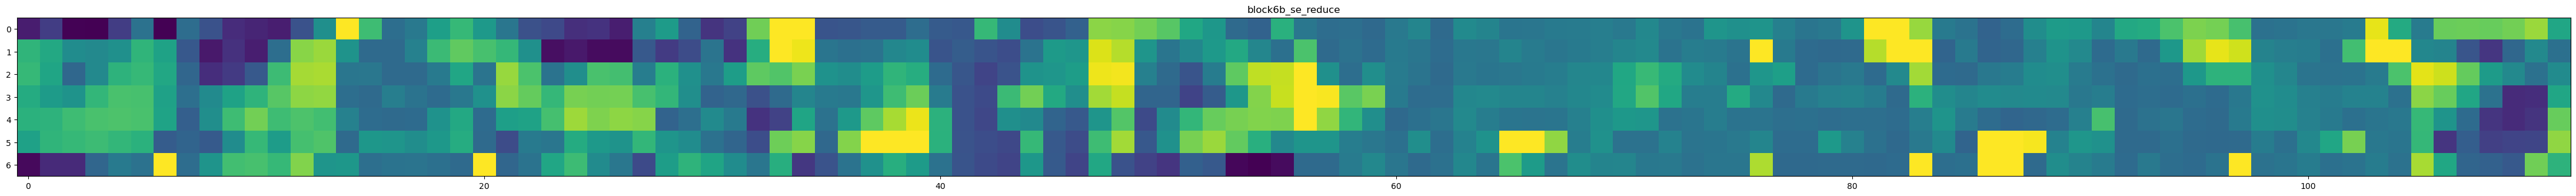

1/1 [==============================] - 0s 115ms/step


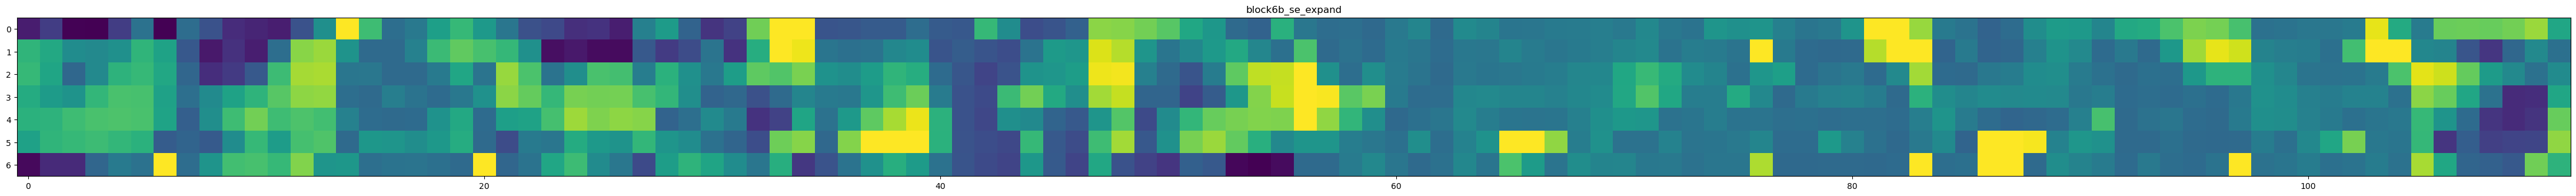

1/1 [==============================] - 0s 63ms/step


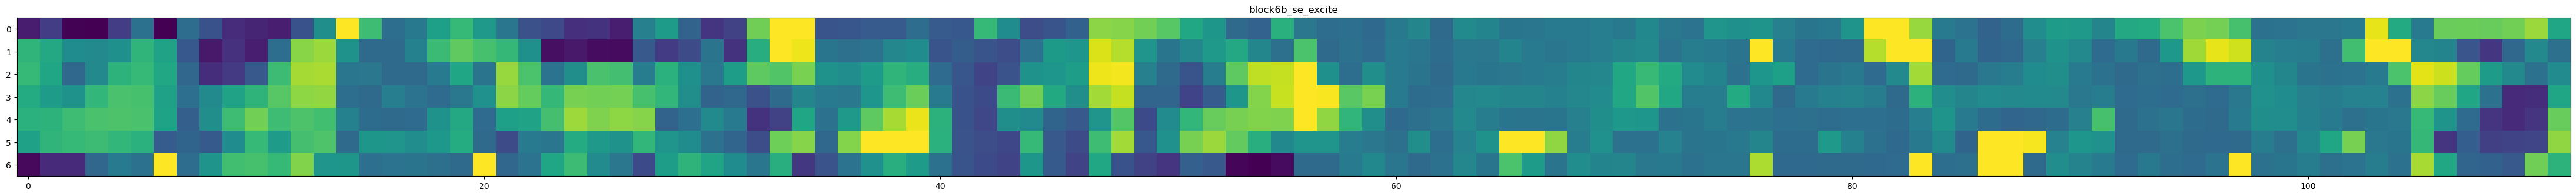

1/1 [==============================] - 0s 86ms/step


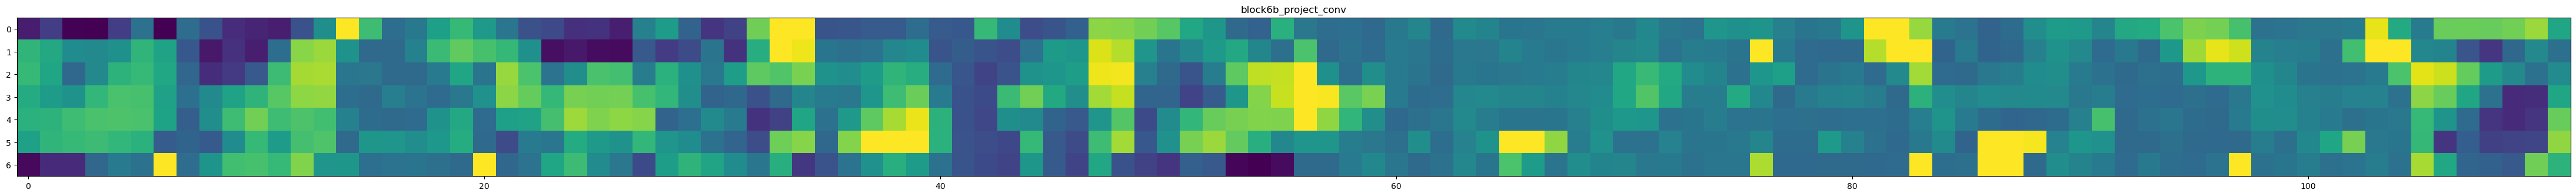

1/1 [==============================] - 0s 77ms/step


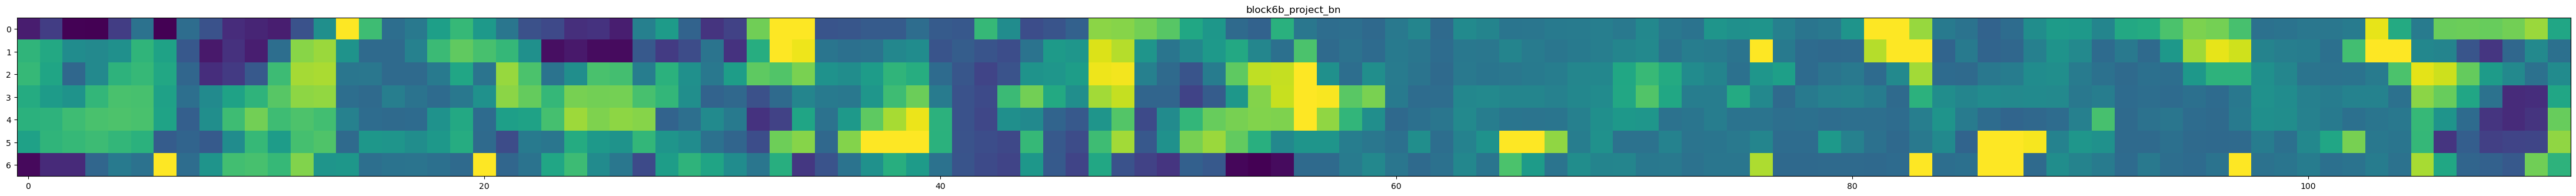

1/1 [==============================] - 0s 82ms/step


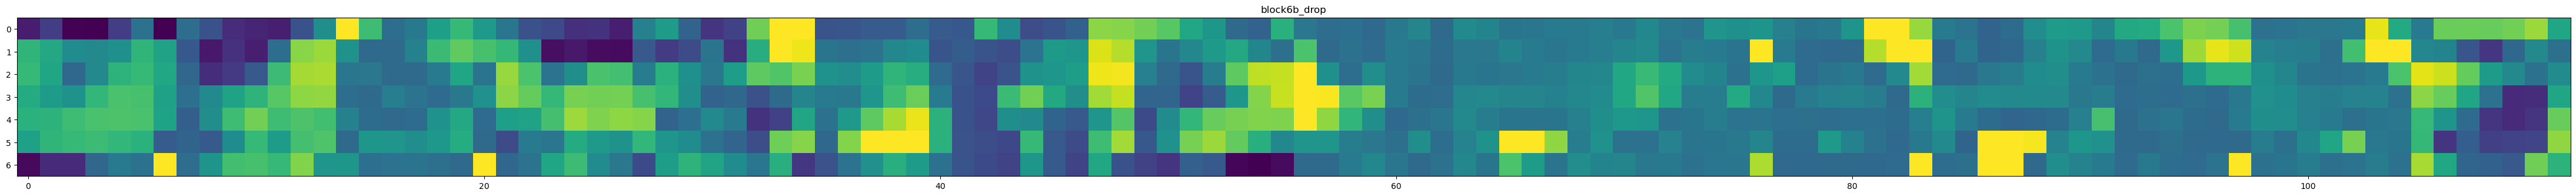

1/1 [==============================] - 0s 82ms/step


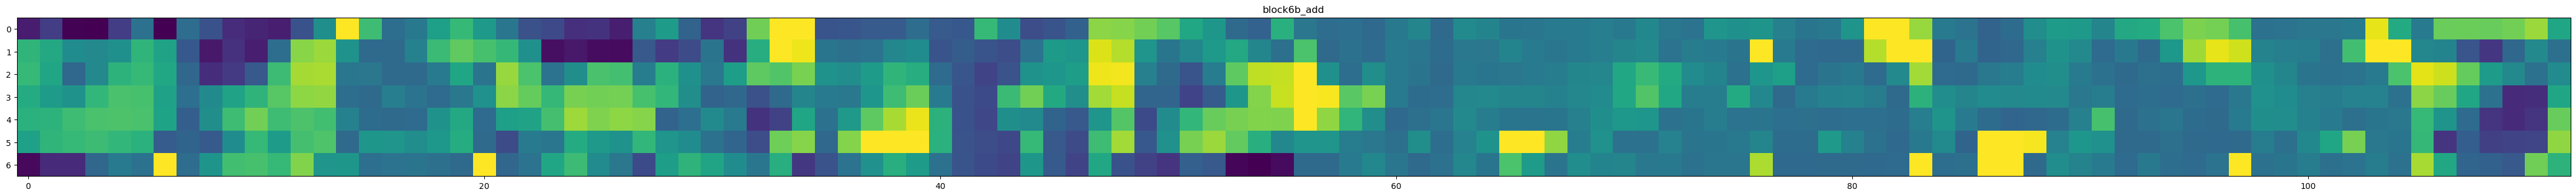

1/1 [==============================] - 0s 121ms/step


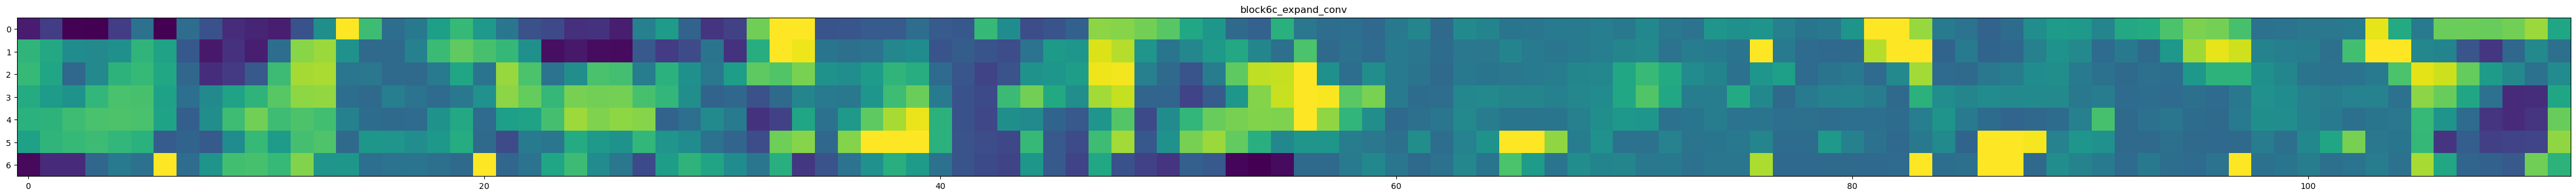

1/1 [==============================] - 0s 123ms/step


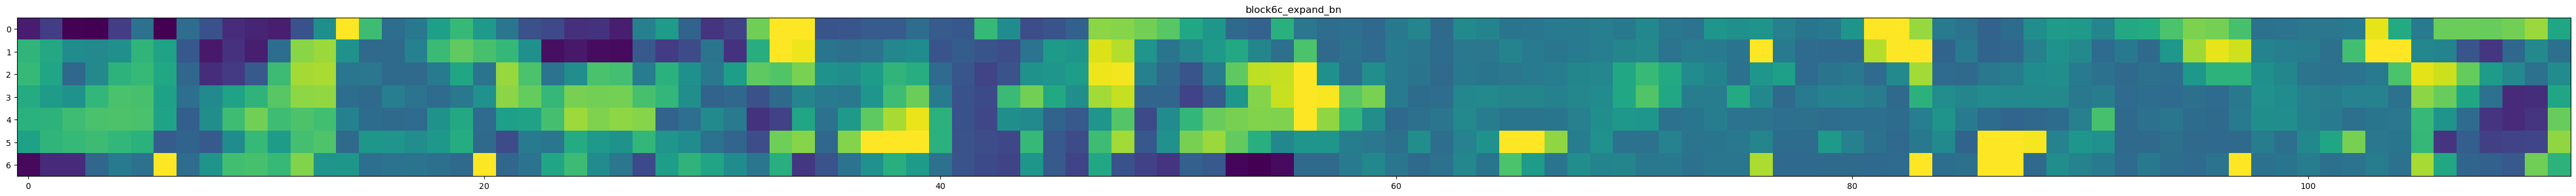

1/1 [==============================] - 0s 125ms/step


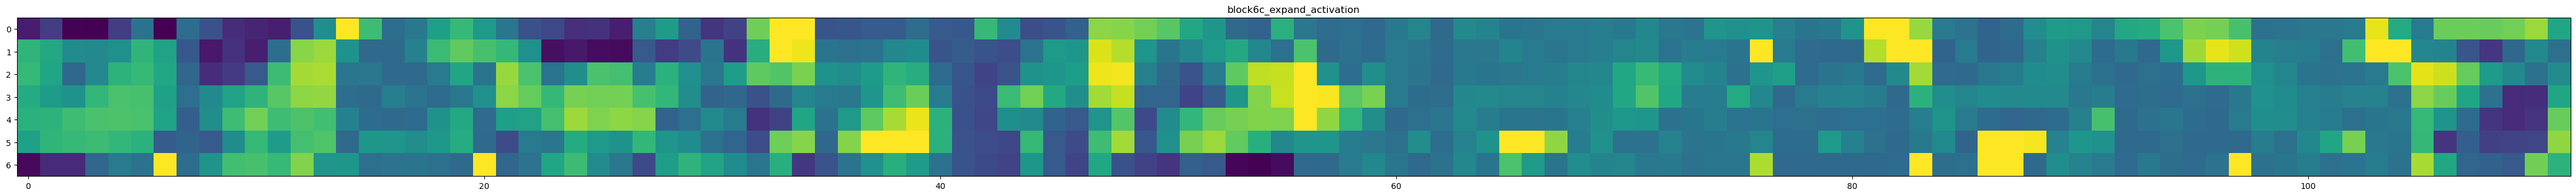

1/1 [==============================] - 0s 73ms/step


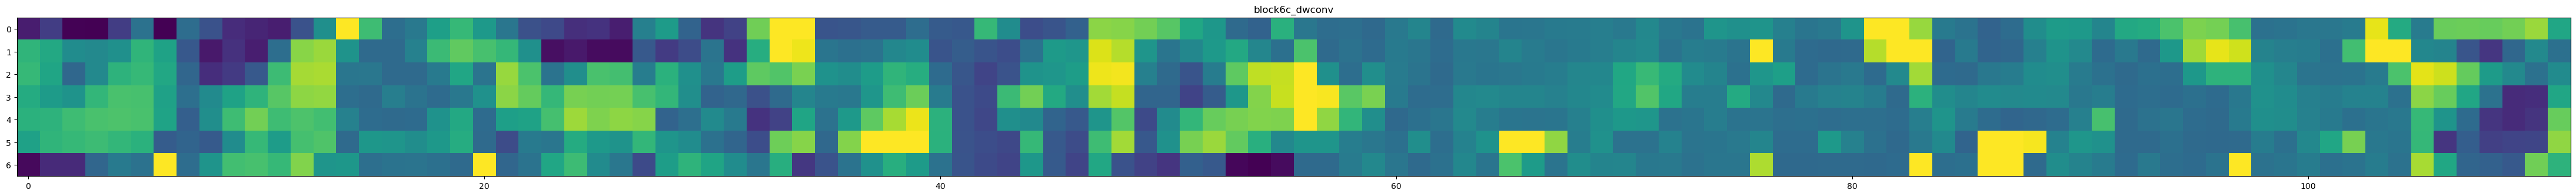

1/1 [==============================] - 0s 81ms/step


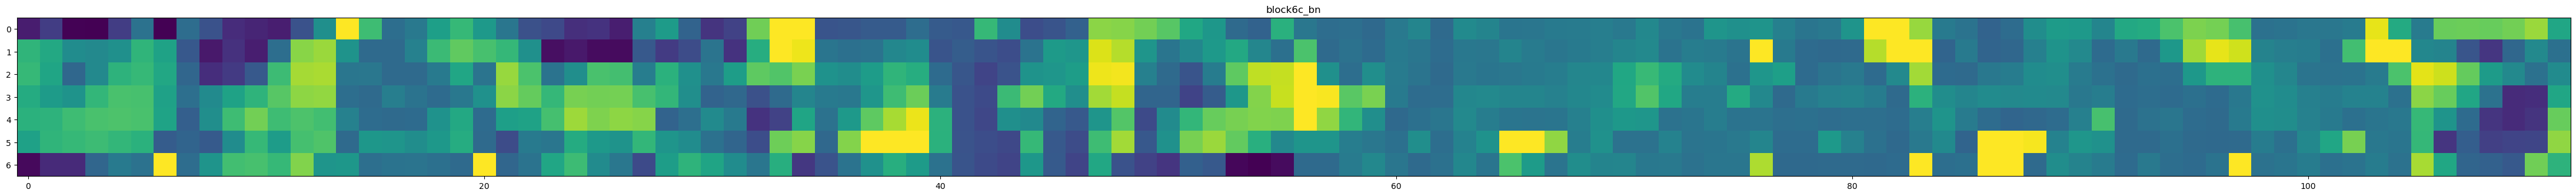

1/1 [==============================] - 0s 73ms/step


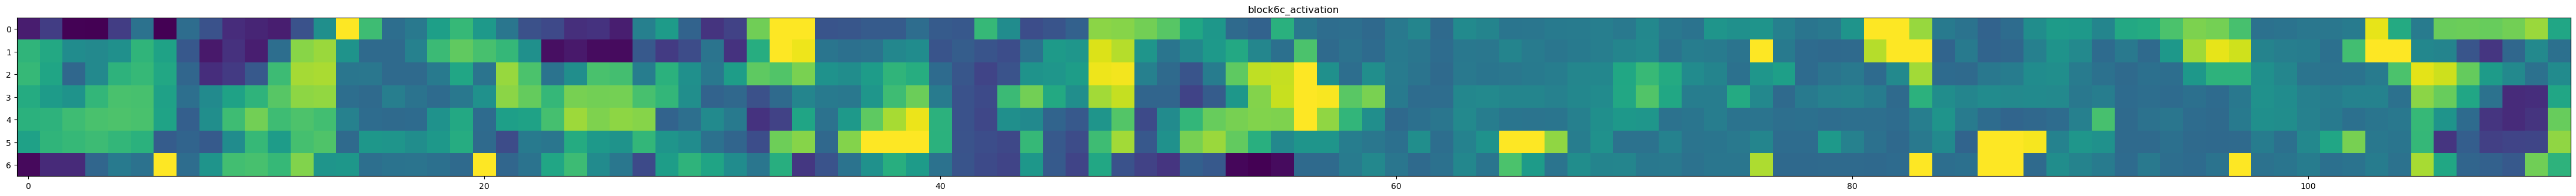

1/1 [==============================] - 0s 62ms/step


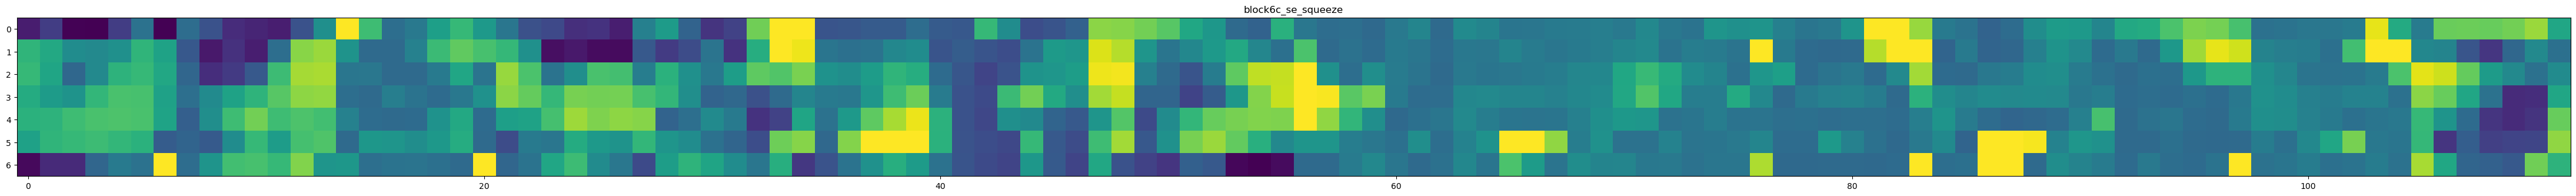

1/1 [==============================] - 0s 63ms/step


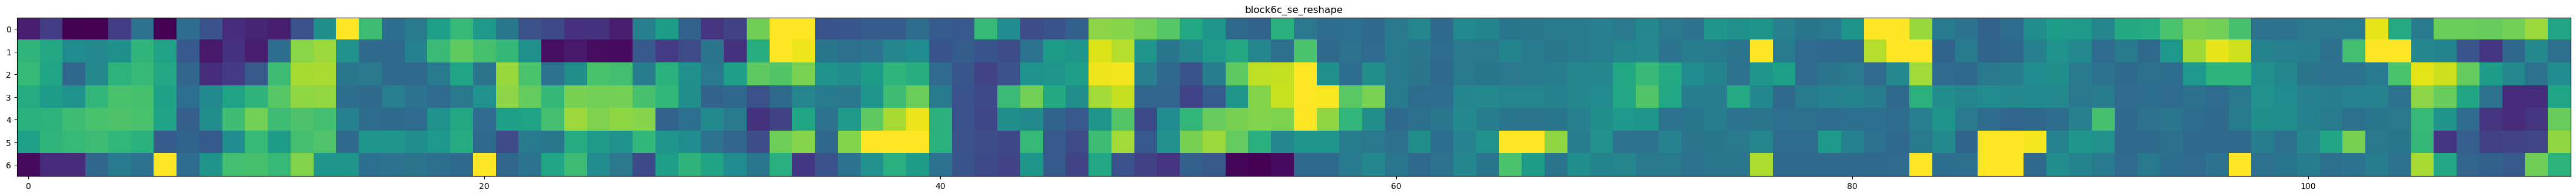

1/1 [==============================] - 0s 78ms/step


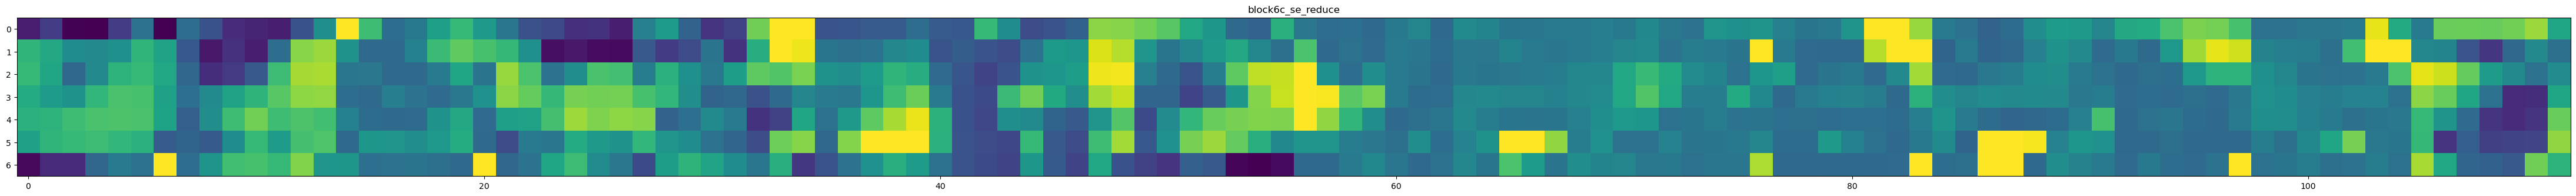

1/1 [==============================] - 0s 77ms/step


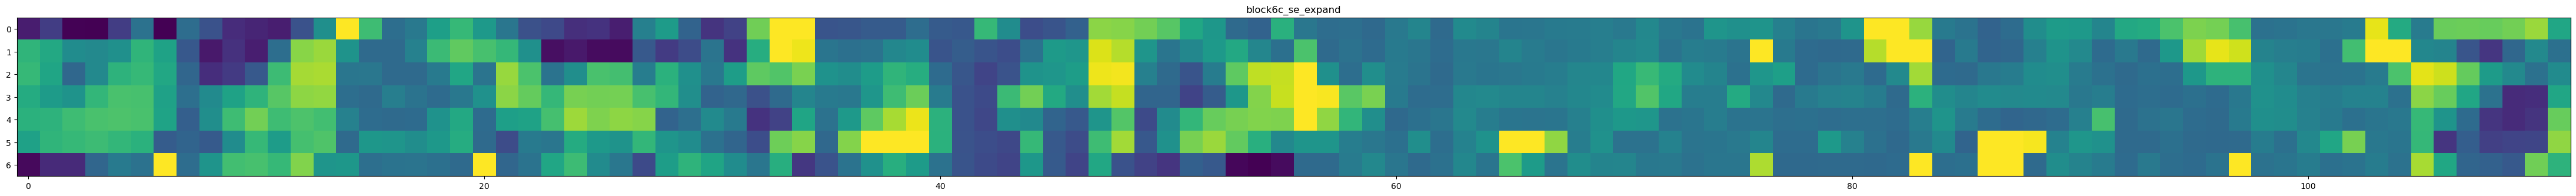

1/1 [==============================] - 0s 79ms/step


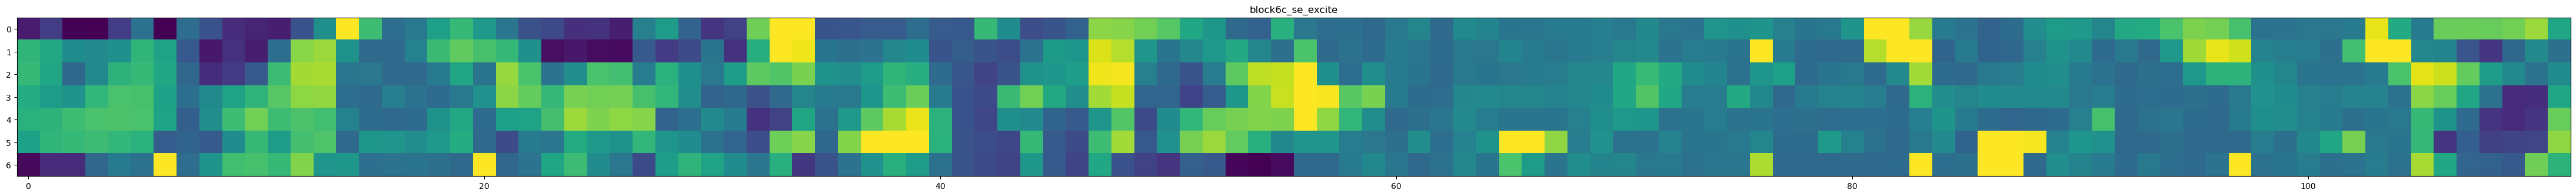

1/1 [==============================] - 0s 68ms/step


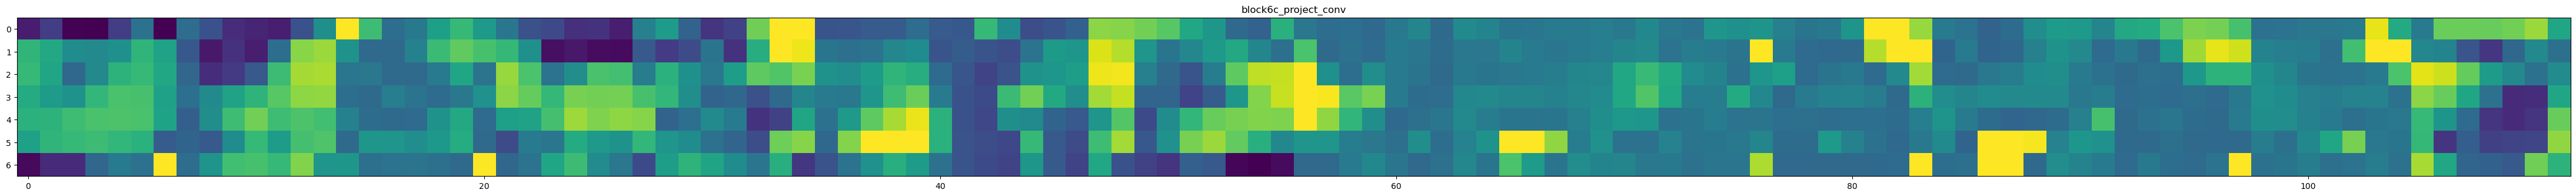

1/1 [==============================] - 0s 80ms/step


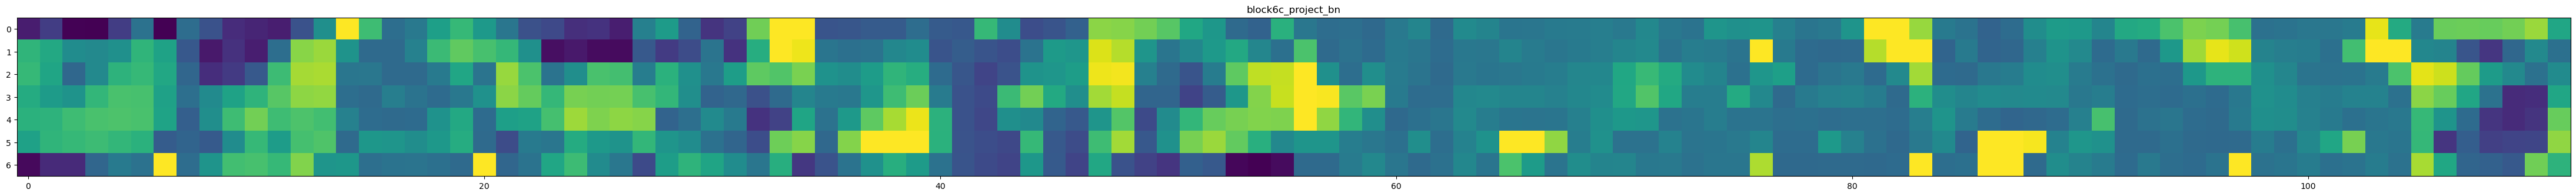

1/1 [==============================] - 0s 83ms/step


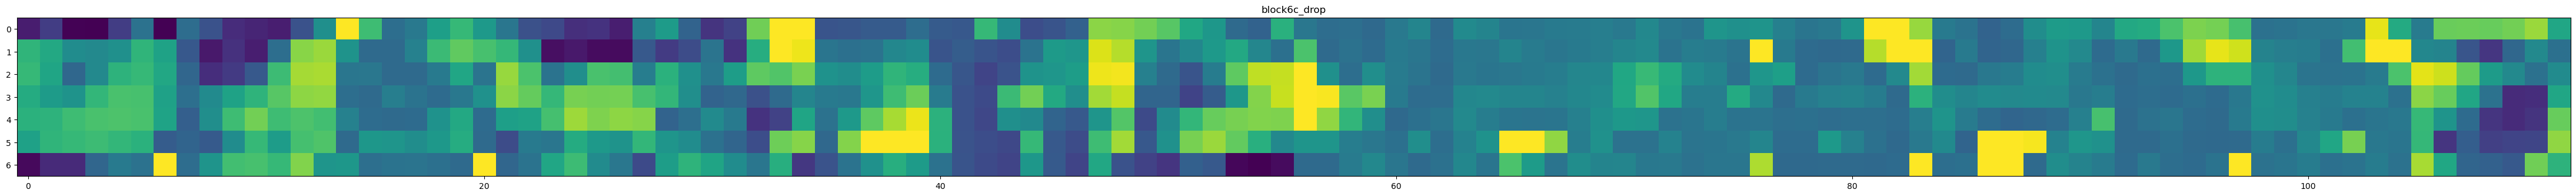

1/1 [==============================] - 0s 79ms/step


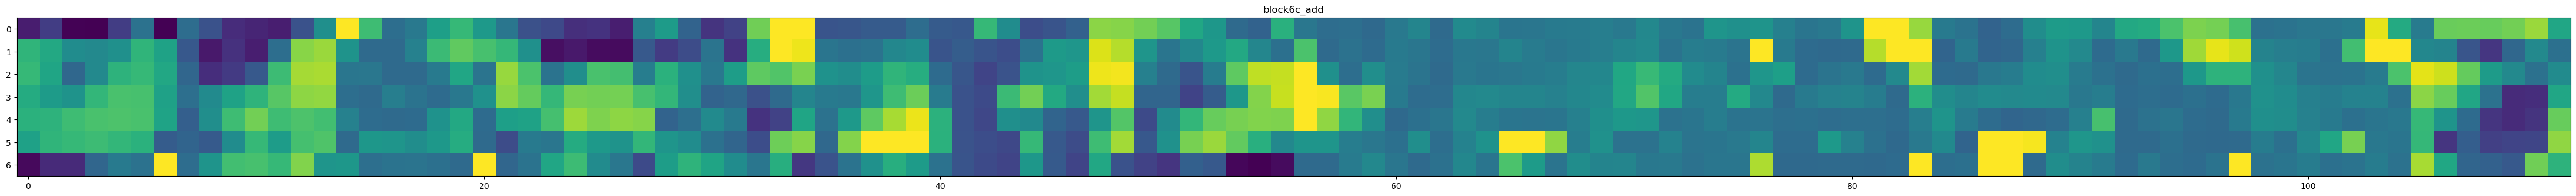

1/1 [==============================] - 0s 79ms/step


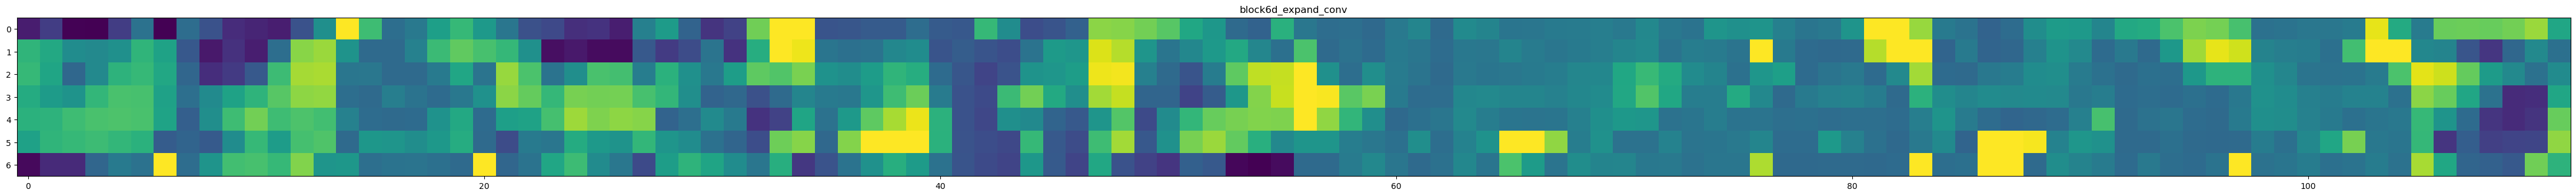

1/1 [==============================] - 0s 59ms/step


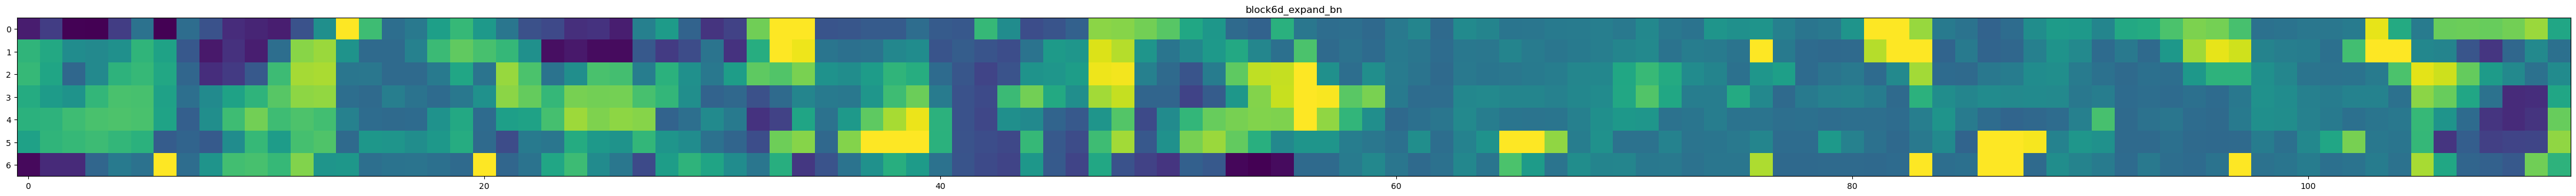

1/1 [==============================] - 0s 78ms/step


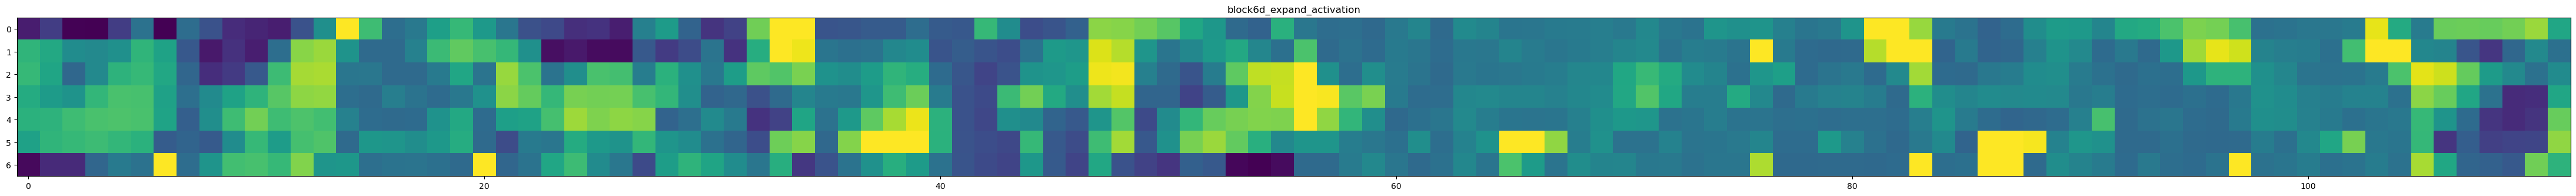

1/1 [==============================] - 0s 62ms/step


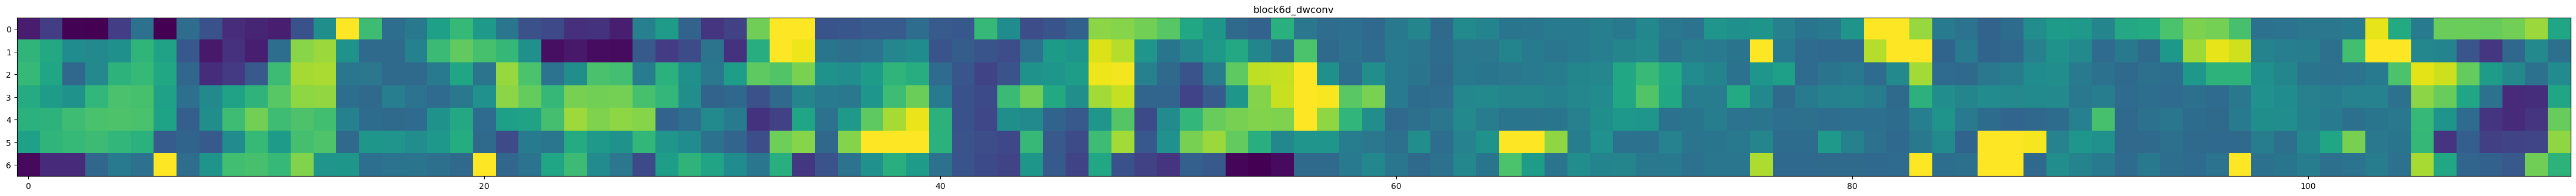

1/1 [==============================] - 0s 79ms/step


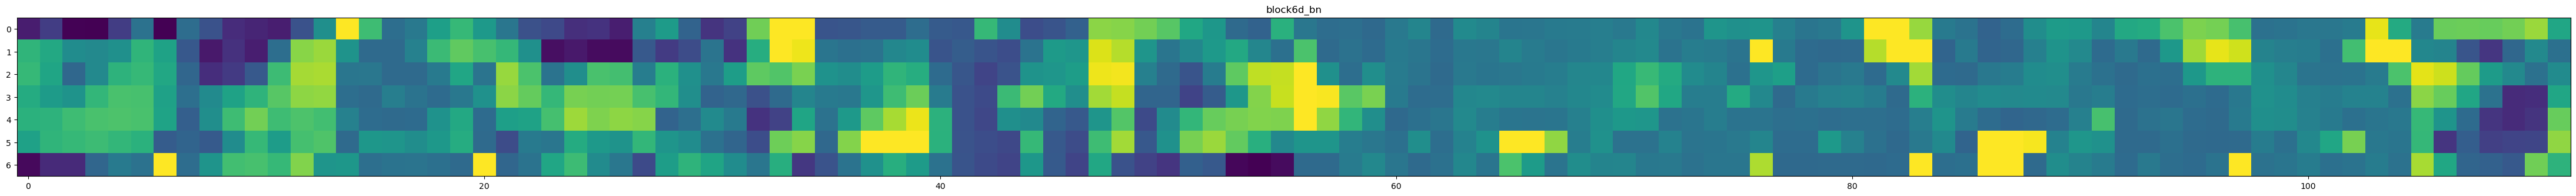

1/1 [==============================] - 0s 74ms/step


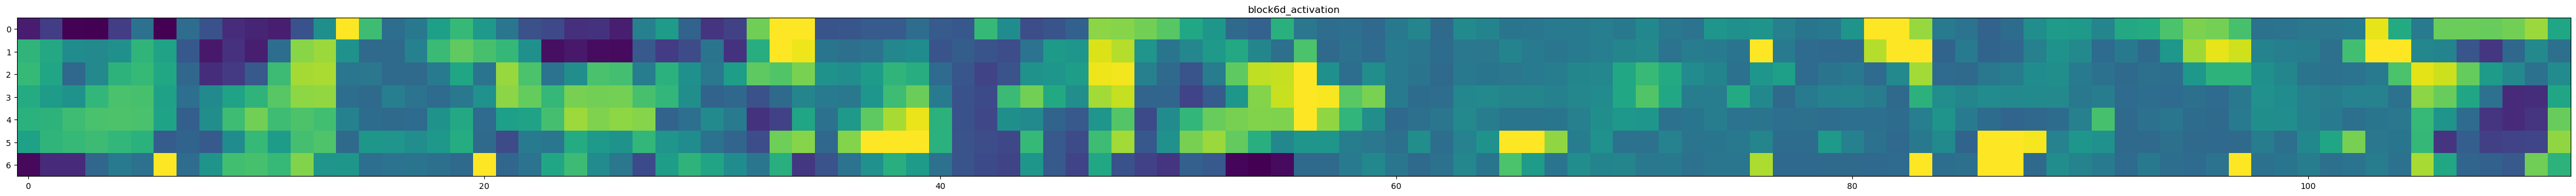

1/1 [==============================] - 0s 78ms/step


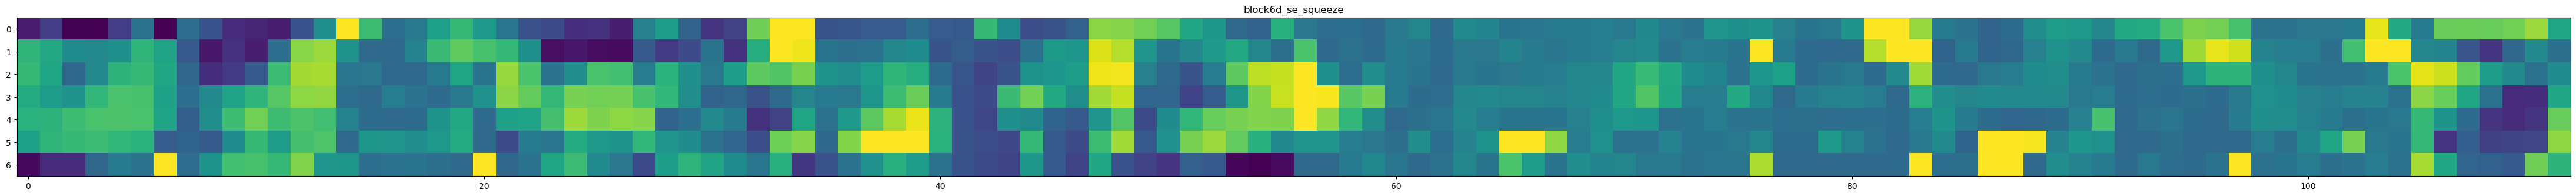

1/1 [==============================] - 0s 78ms/step


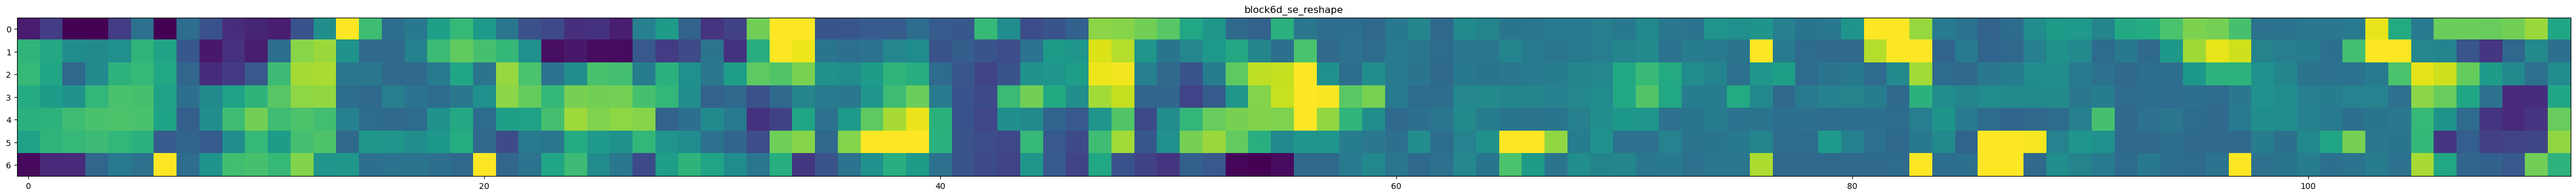

1/1 [==============================] - 0s 78ms/step


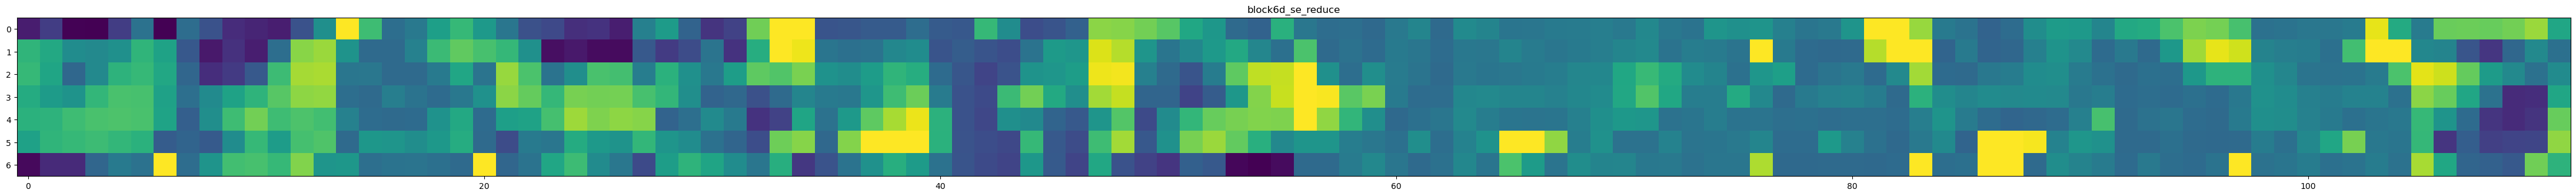

1/1 [==============================] - 0s 78ms/step


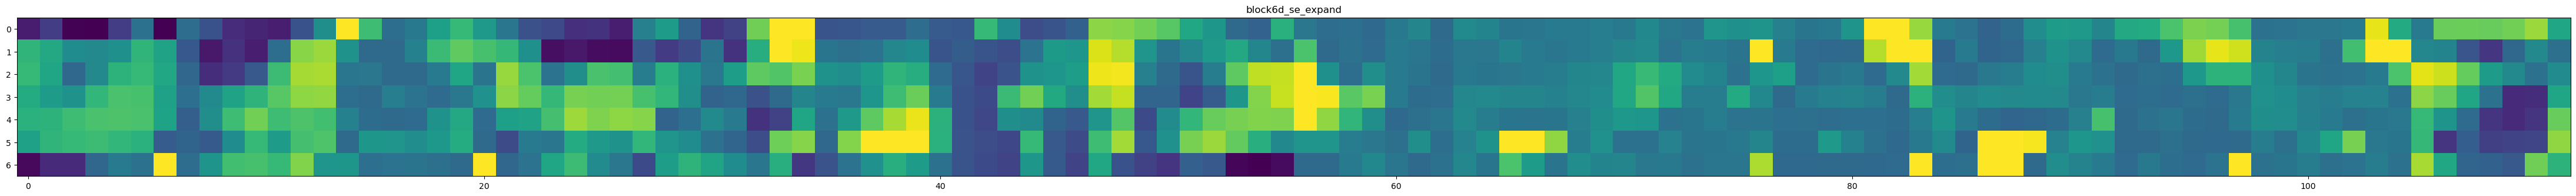

1/1 [==============================] - 0s 78ms/step


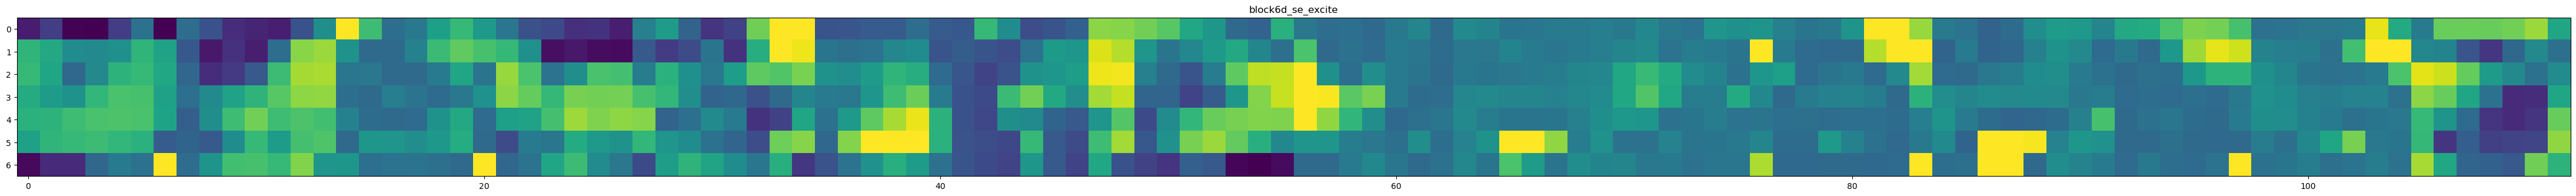

1/1 [==============================] - 0s 75ms/step


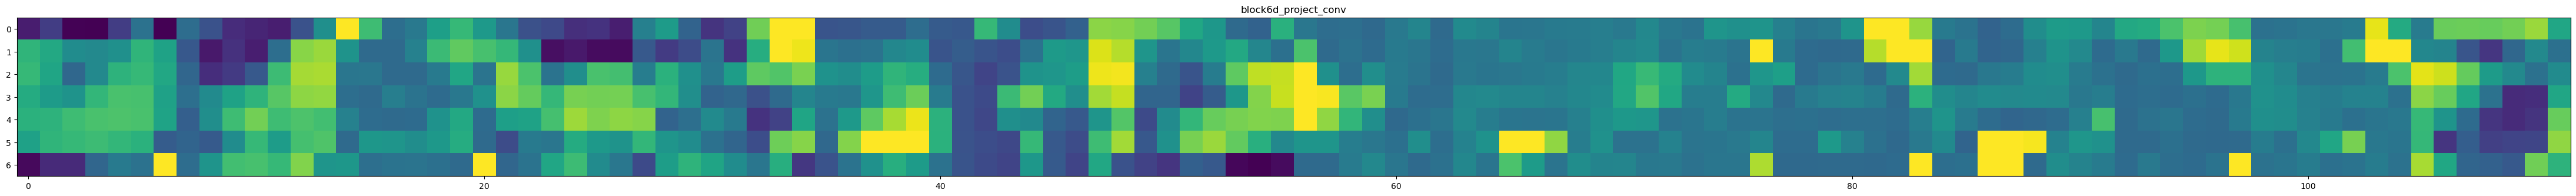

1/1 [==============================] - 0s 74ms/step


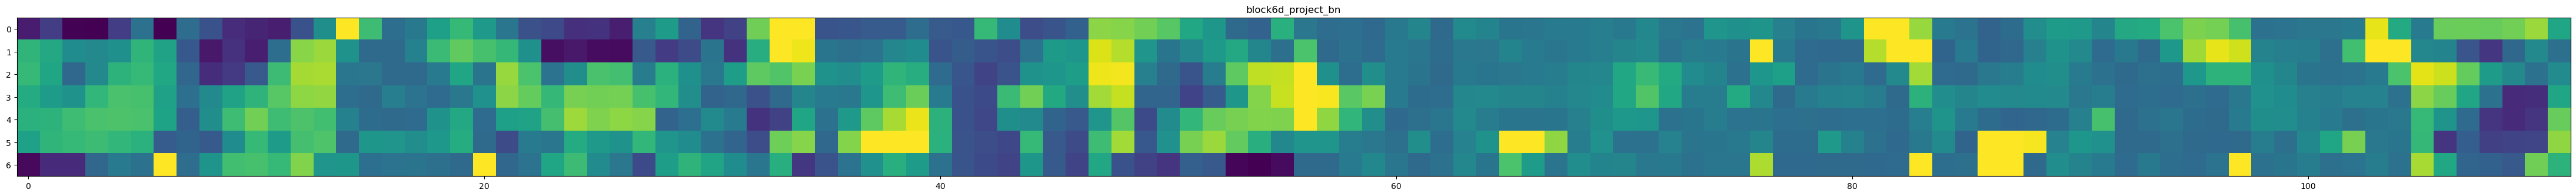

1/1 [==============================] - 0s 72ms/step


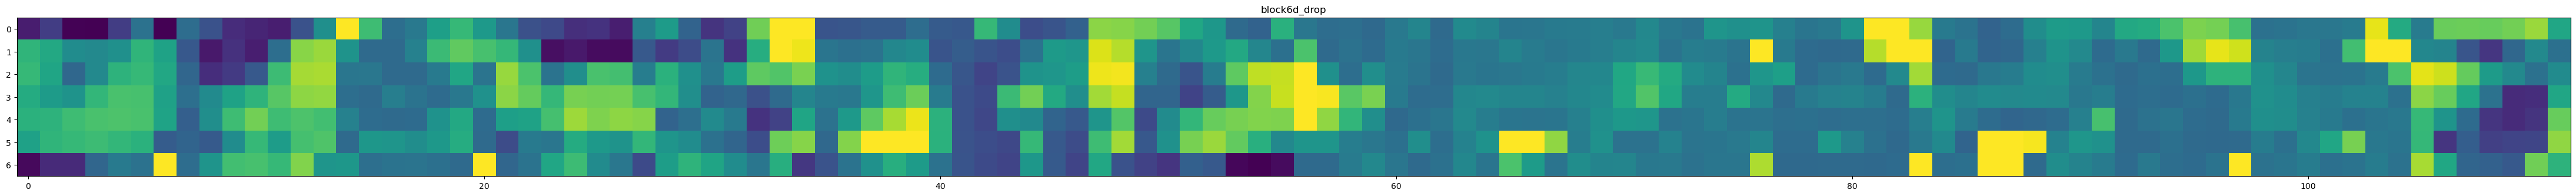

1/1 [==============================] - 0s 65ms/step


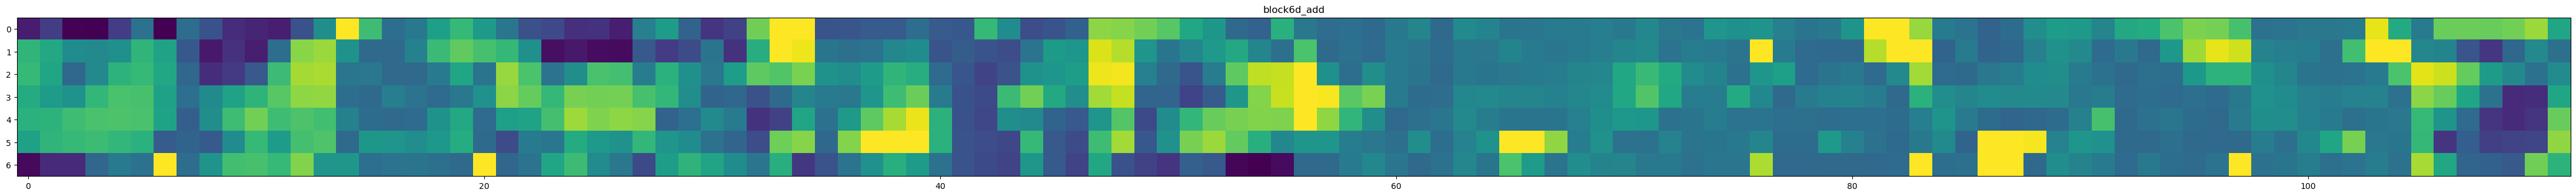

1/1 [==============================] - 0s 86ms/step


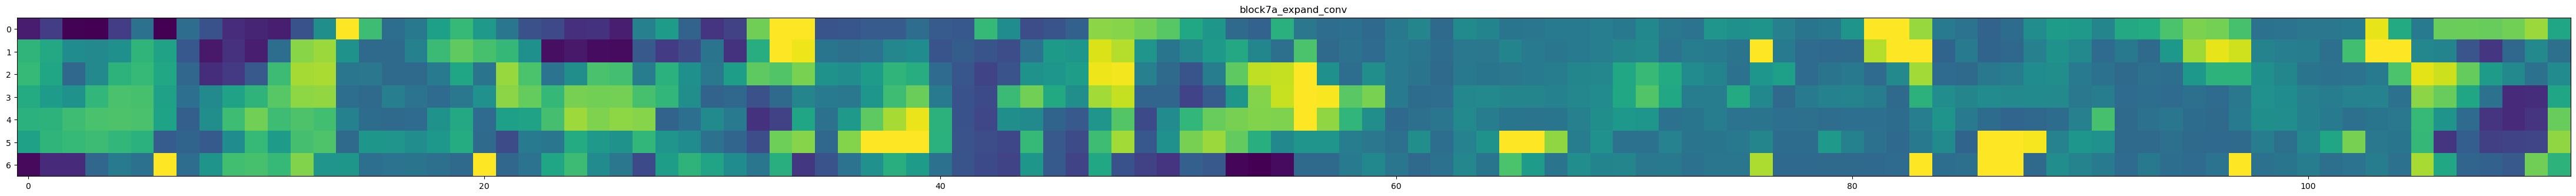

1/1 [==============================] - 0s 77ms/step


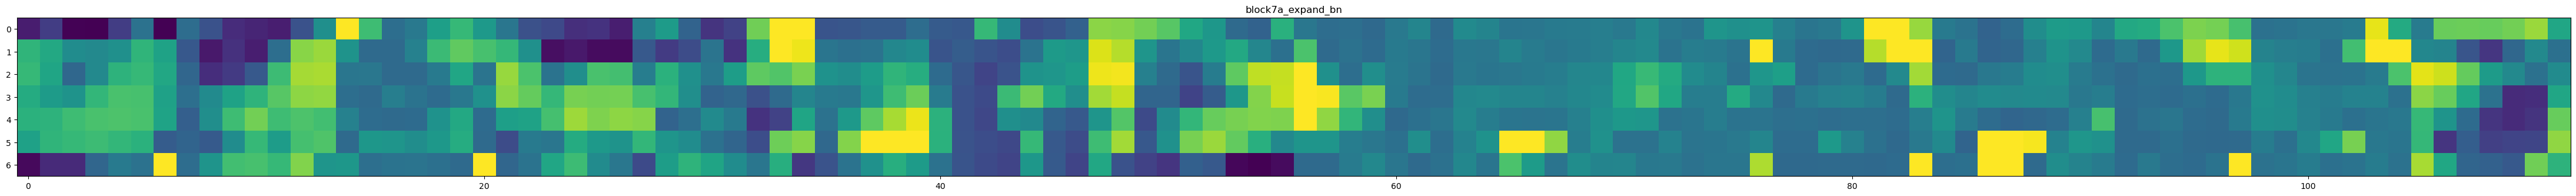

1/1 [==============================] - 0s 71ms/step


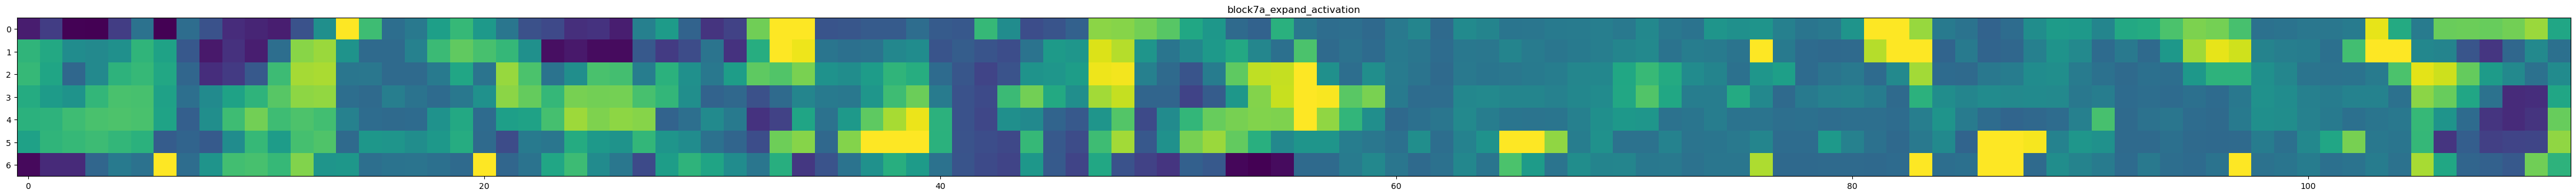

1/1 [==============================] - 0s 79ms/step


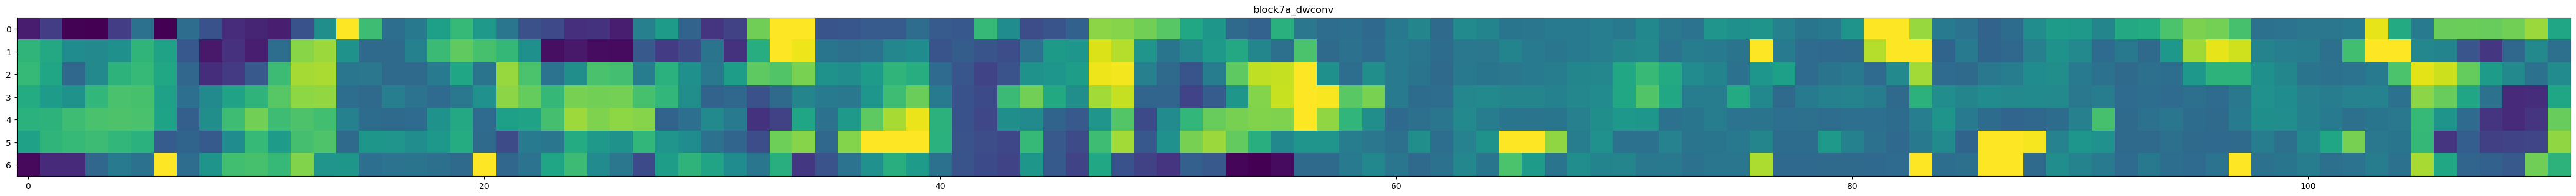

1/1 [==============================] - 0s 79ms/step


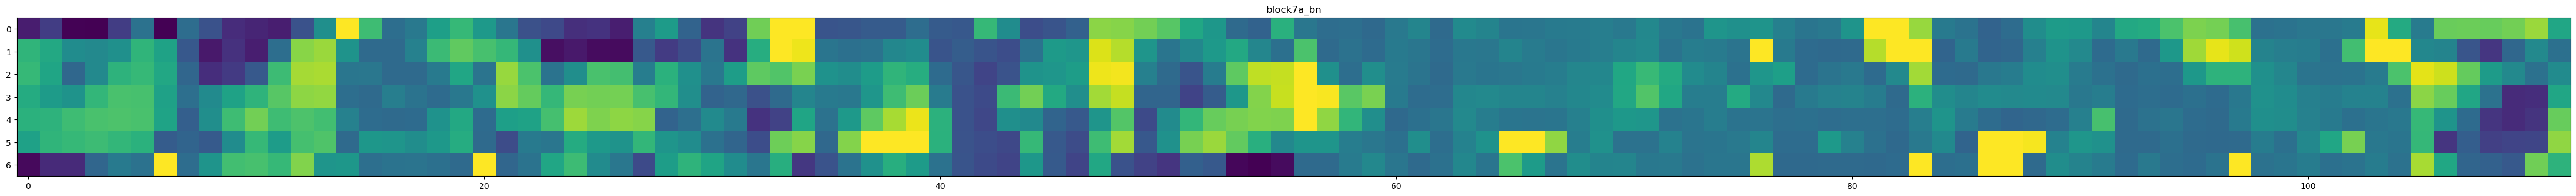

1/1 [==============================] - 0s 62ms/step


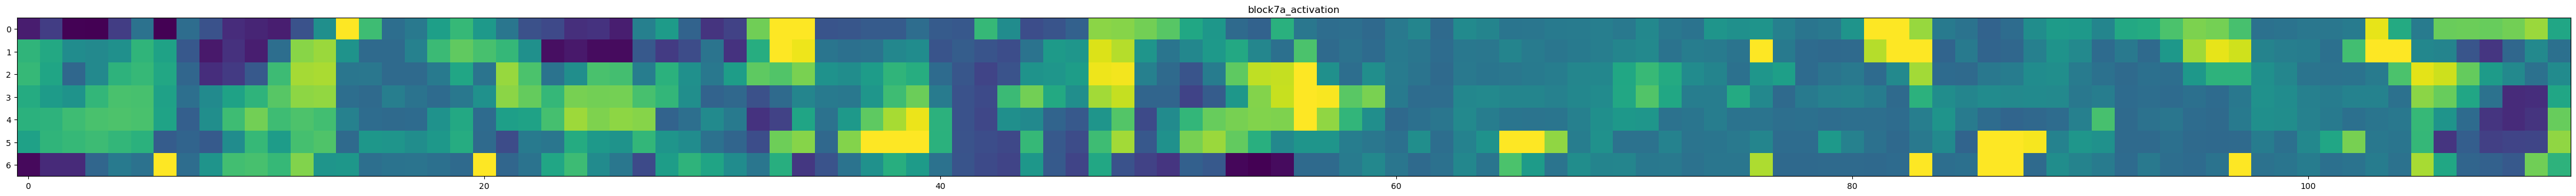

1/1 [==============================] - 0s 70ms/step


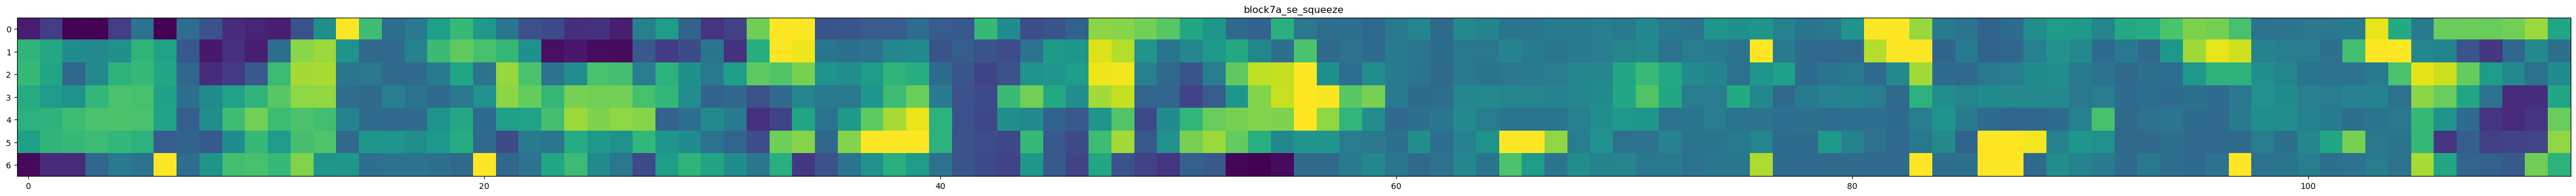

1/1 [==============================] - 0s 93ms/step


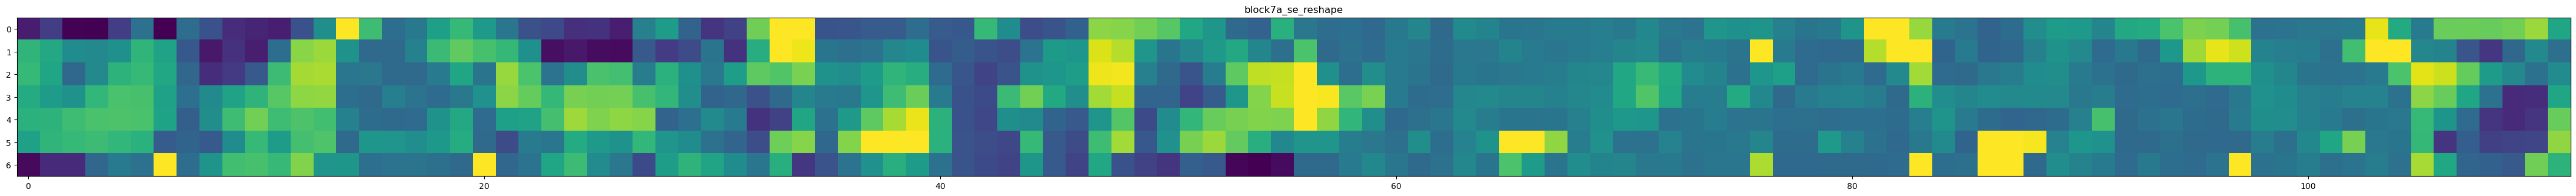

1/1 [==============================] - 0s 78ms/step


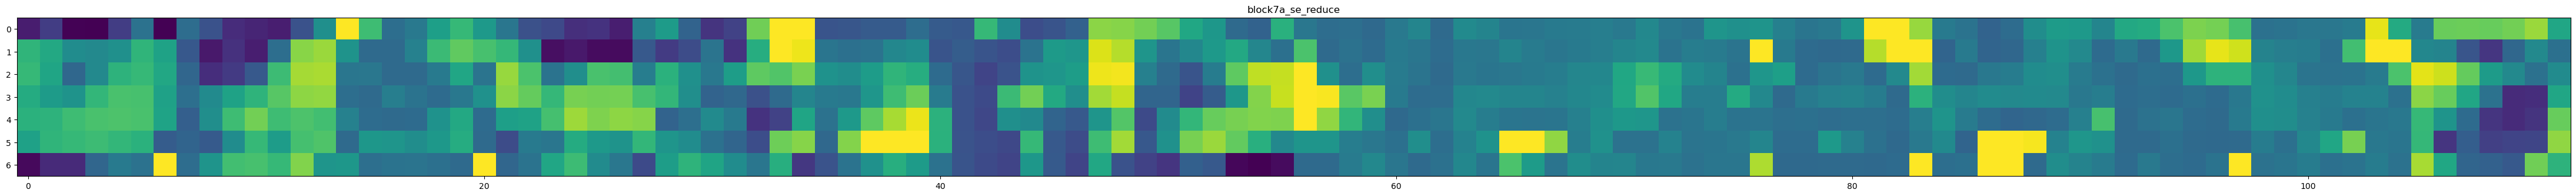

1/1 [==============================] - 0s 86ms/step


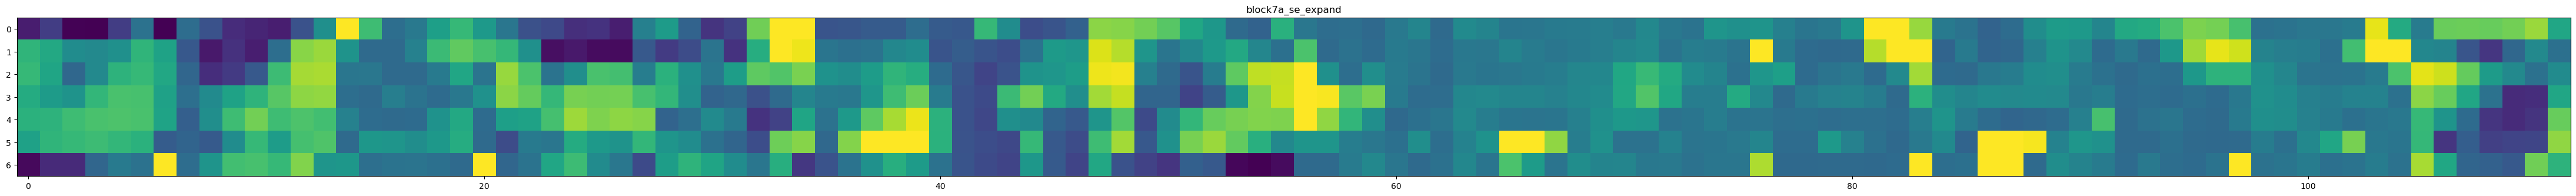

1/1 [==============================] - 0s 79ms/step


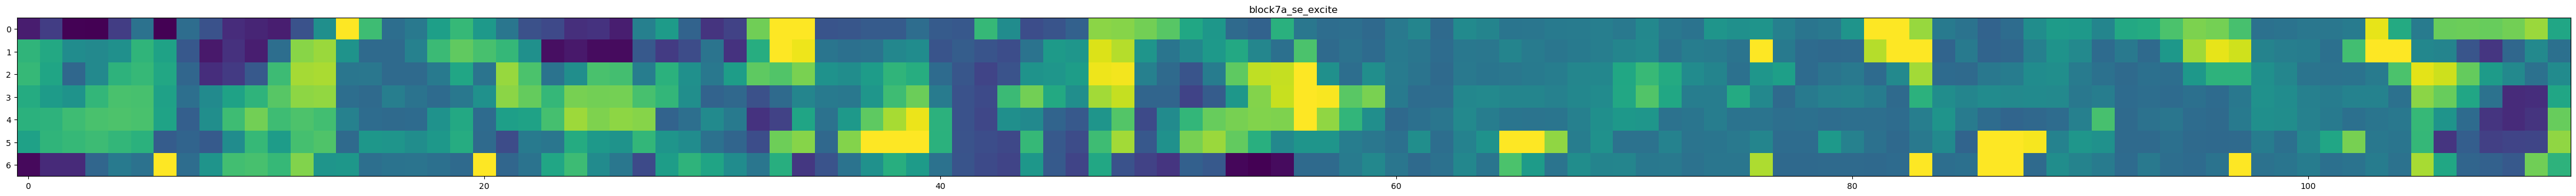

1/1 [==============================] - 0s 74ms/step


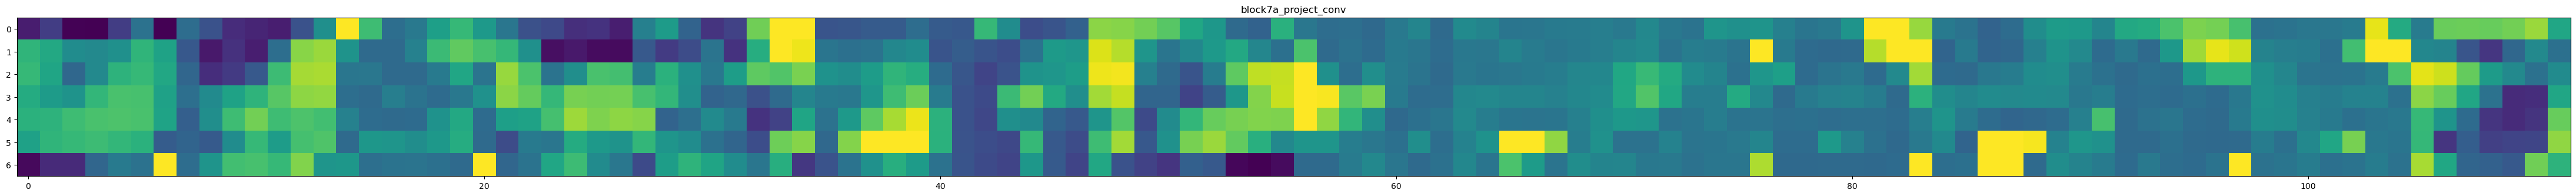

1/1 [==============================] - 0s 81ms/step


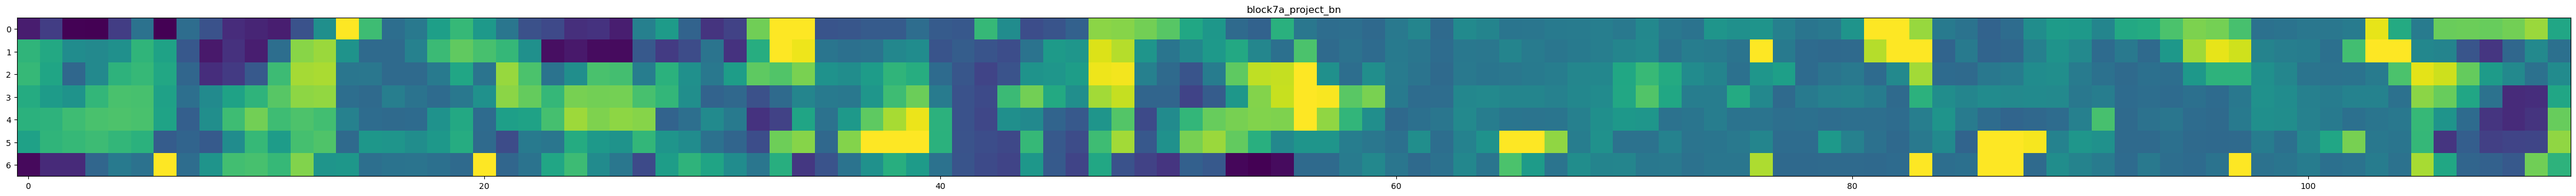

1/1 [==============================] - 0s 82ms/step


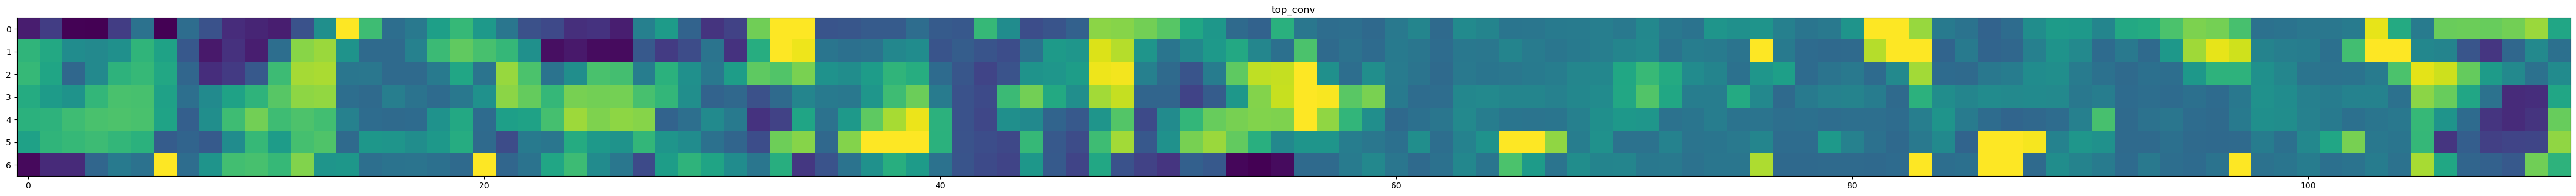

1/1 [==============================] - 0s 80ms/step


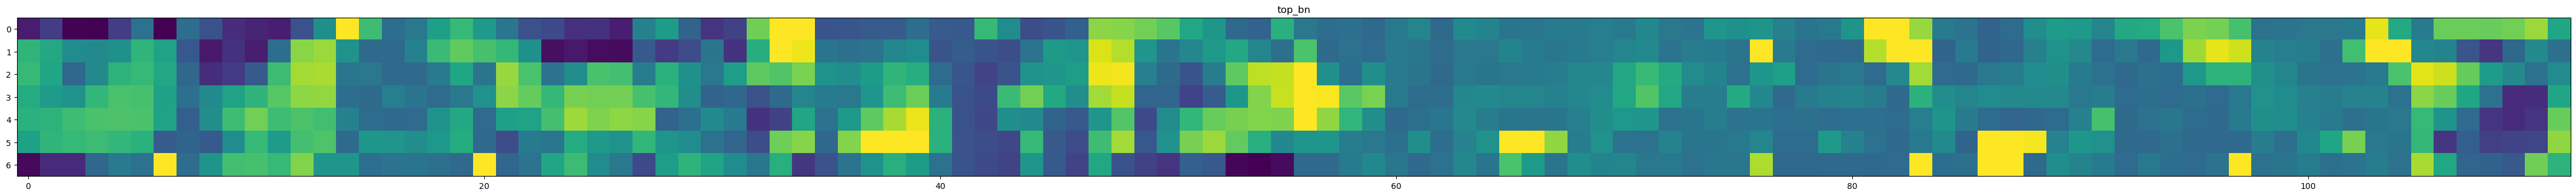

1/1 [==============================] - 0s 78ms/step


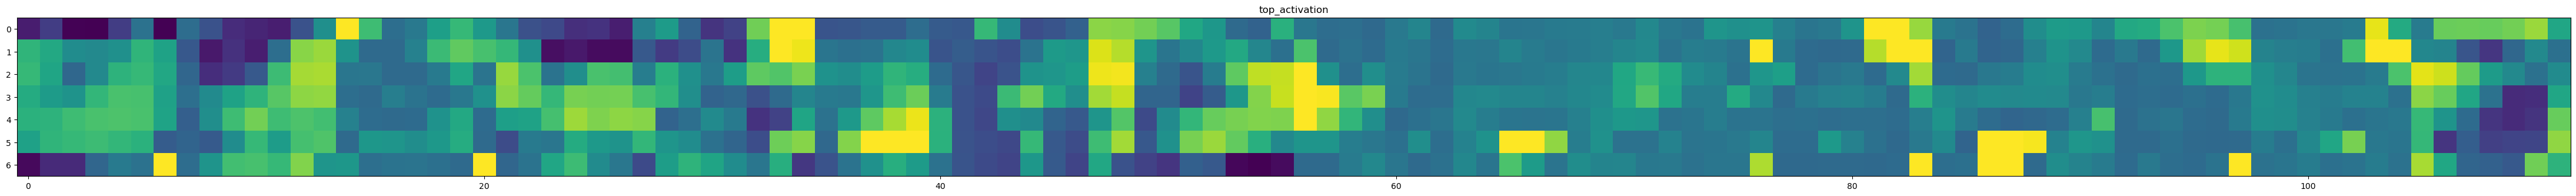

In [33]:
from tensorflow.keras.models import Model

# Find the index of the 'efficientnetb0' layer
effnet_index = -1
for i, layer in enumerate(model_classification.layers):
    if layer.name == 'efficientnetb0':
        effnet_index = i
        break

# Create an activation model excluding preprocessing layers
activation_model = Model(inputs=model_classification.layers[0].input, outputs=model_classification.layers[effnet_index].output)

# Get the layer names
layer_names = [layer.name for layer in activation_model.layers]
# Display feature maps for the first few layers
max_features = 16  # Set the maximum number of displayed features per layer

for layer_name in layer_names:
    layer_activation = activation_model.predict(example_image)
    n_features = min(layer_activation.shape[-1], max_features)
    size = layer_activation.shape[1]

    display_grid = np.zeros((size, size * n_features))

    for i in range(n_features):
        channel_image = layer_activation[0, :, :, i]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = channel_image

    scale = 0.5  # Adjust the scale factor as needed
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()